# Overview

- After the organization and splitting of the dataset into training, validation, and testing subsets
- Data augmentation techniques were applied to the training set to enhance model generalization.

The next step involves creating data loaders and training both CNN-based and Transformer-based models.

**This Notebook is for training CNN-based models**

# Importing Library

In [3]:
import torch
import gc
#import cv2
import os
import csv
import numpy as np
from tqdm import tqdm
import shutil
from helper_function import Create_dataloader
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn as nn
import torchvision
from helper_function import train
from torch.optim.lr_scheduler import ExponentialLR
from helper_function import Model_evaluate, loss_and_acc_plots,plot_roc_auc
from helper_function import plot_roc_auc,state_loader_fixer
from timm import create_model
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import timm
import SimpleITK as sitk
import radiomics.featureextractor as featureextractor
import logging
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from Hyper_model_engine import Train
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data loader

In [14]:
train_dataloader,valid_dataloader,test_dataloader= Create_dataloader(train_dir="Final_dataset/Original Data/images/Aug"
                                                                     ,valid_dir="Final_dataset/Original Data/images/valid"
                                                                     ,test_dir="Final_dataset/Original Data/images/test"
                                                                     ,batch_size=32)


helper function file was used which involves essential function for creating dataloader, training and evaluation 

# Models

## ResNet 101

In [16]:
class ResNet(torch.nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.resnet(x)


In [17]:
ResNet_Model = ResNet(num_classes=3)
device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ResNet_Model.parameters(),
                             lr=1e-3)

scheduler = ExponentialLR(optimizer, gamma=0.9)

ResNet_Model = ResNet_Model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

ResNet_Model_results = train(model=ResNet_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,
                            scheduler=scheduler)



/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|█▏                                                        | 1/50 [00:57<47:09, 57.75s/it]


Epoch 1, Training Loss: 3.4128, Training Accuracy: 0.6324, Training Precision: 0.6191, Training Recall: 0.6258, Training F1: 0.6188, Test Loss: 1.7494, Test Accuracy: 0.4547, Test Precision: 0.5138, Test Recall: 0.4266, Test F1: 0.4253, Test Sensitivity: 0.4266


  4%|██▎                                                       | 2/50 [01:56<46:38, 58.31s/it]


Epoch 2, Training Loss: 1.7413, Training Accuracy: 0.8284, Training Precision: 0.8274, Training Recall: 0.8287, Training F1: 0.8274, Test Loss: 1.9911, Test Accuracy: 0.5129, Test Precision: 0.4851, Test Recall: 0.5687, Test F1: 0.4884, Test Sensitivity: 0.5687


  6%|███▍                                                      | 3/50 [02:53<45:19, 57.86s/it]


Epoch 3, Training Loss: 1.3651, Training Accuracy: 0.9052, Training Precision: 0.9052, Training Recall: 0.9045, Training F1: 0.9048, Test Loss: 278.4144, Test Accuracy: 0.2220, Test Precision: 0.4588, Test Recall: 0.3891, Test F1: 0.1981, Test Sensitivity: 0.3891


  6%|███▎                                                    | 3/50 [03:50<1:00:09, 76.79s/it]

Early stopping at epoch 4


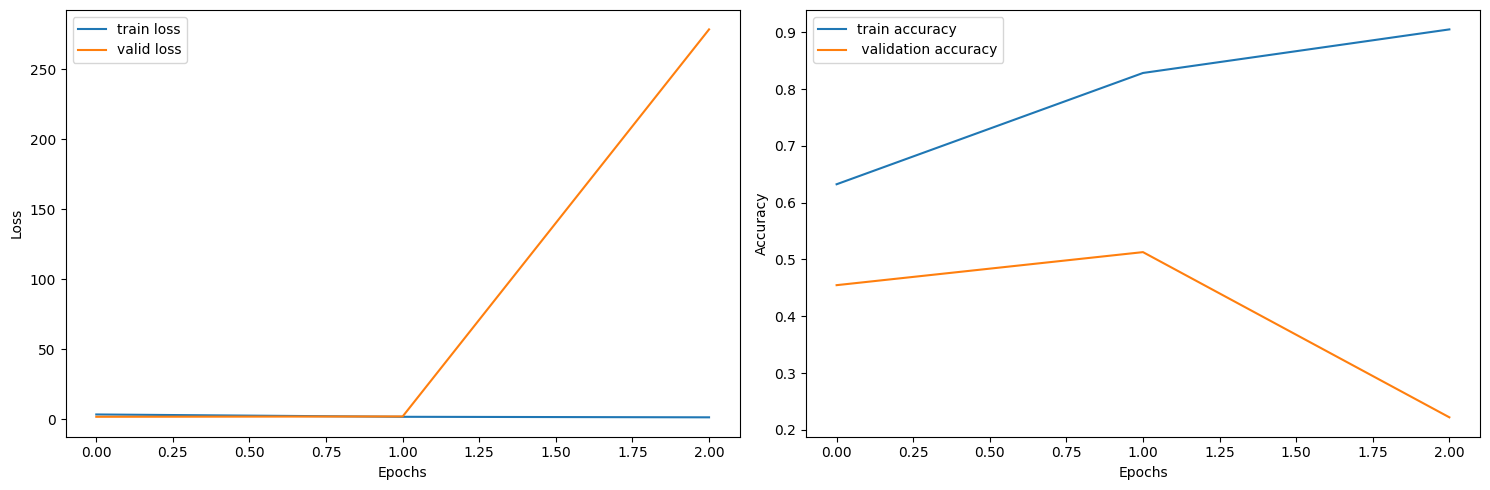

In [18]:
loss_and_acc_plots(ResNet_Model_results,True)

In [4]:
ResNet_Model.load_state_dict(torch.load('best_models/Resnet/best_model.pth'))

<All keys matched successfully>

Test Accuracy: 0.7024
Test Precision: 0.8170
Test Recall: 0.7124
Test F1 Score: 0.7101
Test Sensitivity: 0.7124


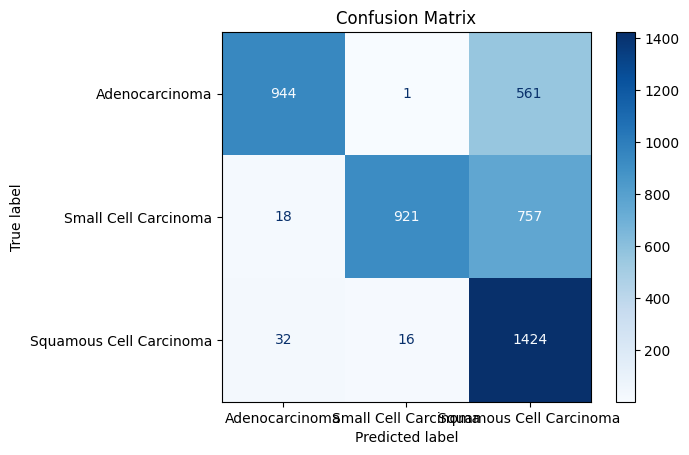

In [5]:
Model_evaluate(ResNet_Model, train_dataloader,device=device)

Test Accuracy: 0.4547
Test Precision: 0.5138
Test Recall: 0.4266
Test F1 Score: 0.4253
Test Sensitivity: 0.4266


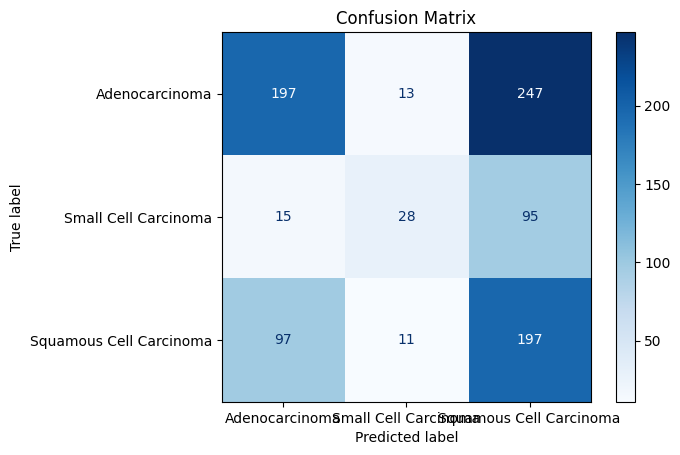

In [6]:
Model_evaluate(ResNet_Model, valid_dataloader)

Test Accuracy: 0.5161
Test Precision: 0.3621
Test Recall: 0.3800
Test F1 Score: 0.3495
Test Sensitivity: 0.3800


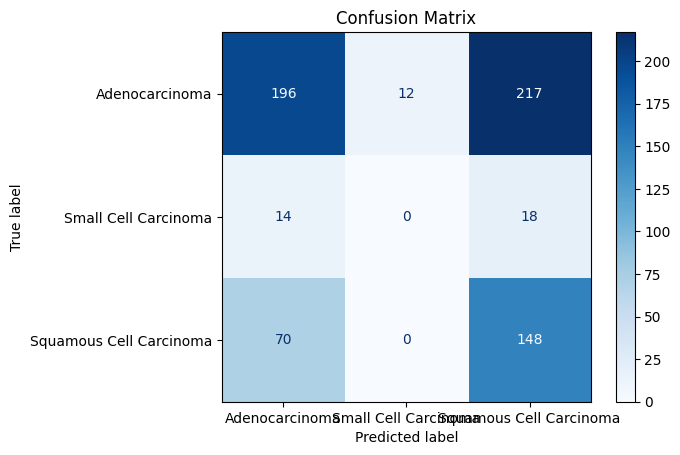

In [7]:
Model_evaluate(ResNet_Model, test_dataloader)

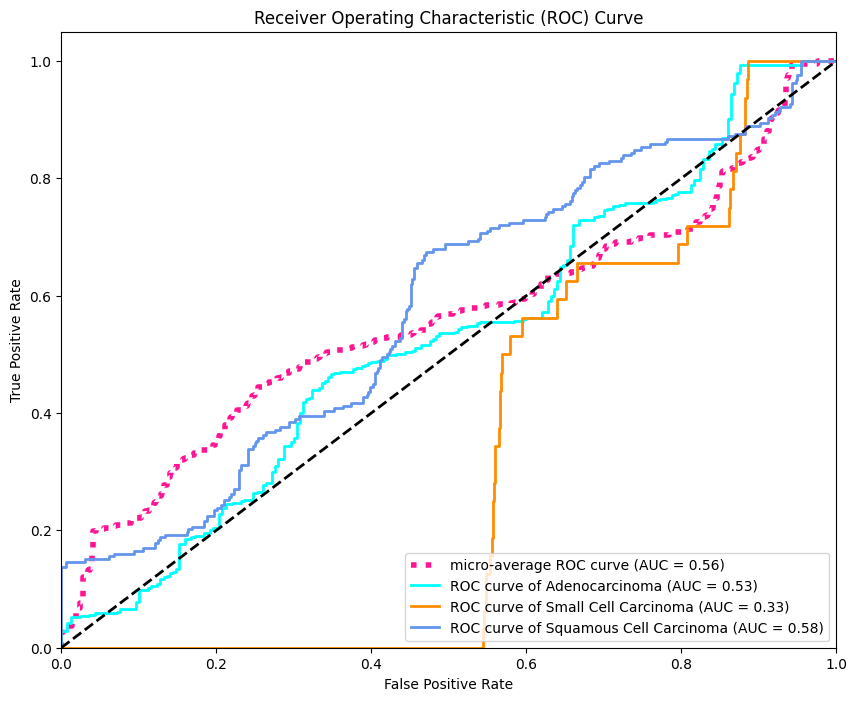

AUC Scores:
Adenocarcinoma: 0.5282
Small Cell Carcinoma: 0.3274
Squamous Cell Carcinoma: 0.5820
Micro-average: 0.5570


In [8]:
plot_roc_auc(ResNet_Model, test_dataloader,device)

## DenseNet121

In [24]:
class DenseNet(torch.nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.densenet = torchvision.models.densenet121(pretrained=True)
        
        self.densenet.classifier = nn.Sequential(
            nn.Linear(self.densenet.classifier.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.densenet(x)
    
DenseNet_Model = DenseNet(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=DenseNet_Model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

scheduler = ExponentialLR(optimizer, gamma=0.9)

DenseNet_Model = DenseNet_Model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

DenseNet_Model_results = train(model=DenseNet_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,
                            scheduler=scheduler)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|█▏                                                        | 1/50 [00:57<46:55, 57.46s/it]


Epoch 1, Training Loss: 1.7295, Training Accuracy: 0.8206, Training Precision: 0.8182, Training Recall: 0.8178, Training F1: 0.8177, Test Loss: 3.7328, Test Accuracy: 0.2845, Test Precision: 0.5370, Test Recall: 0.4311, Test F1: 0.2632, Test Sensitivity: 0.4311


  4%|██▎                                                       | 2/50 [01:54<45:43, 57.16s/it]


Epoch 2, Training Loss: 1.3271, Training Accuracy: 0.9218, Training Precision: 0.9245, Training Recall: 0.9243, Training F1: 0.9243, Test Loss: 1.5245, Test Accuracy: 0.5647, Test Precision: 0.5311, Test Recall: 0.5406, Test F1: 0.5345, Test Sensitivity: 0.5406


  6%|███▍                                                      | 3/50 [02:51<44:36, 56.95s/it]


Epoch 3, Training Loss: 1.1404, Training Accuracy: 0.9473, Training Precision: 0.9504, Training Recall: 0.9496, Training F1: 0.9499, Test Loss: 1.5911, Test Accuracy: 0.5388, Test Precision: 0.5220, Test Recall: 0.4811, Test F1: 0.4800, Test Sensitivity: 0.4811


  8%|████▋                                                     | 4/50 [03:46<43:13, 56.38s/it]


Epoch 4, Training Loss: 0.9668, Training Accuracy: 0.9651, Training Precision: 0.9651, Training Recall: 0.9646, Training F1: 0.9649, Test Loss: 1.4954, Test Accuracy: 0.5237, Test Precision: 0.4830, Test Recall: 0.4890, Test F1: 0.4776, Test Sensitivity: 0.4890


 10%|█████▊                                                    | 5/50 [04:41<42:00, 56.01s/it]


Epoch 5, Training Loss: 0.7823, Training Accuracy: 0.9872, Training Precision: 0.9870, Training Recall: 0.9870, Training F1: 0.9870, Test Loss: 1.8459, Test Accuracy: 0.5948, Test Precision: 0.5531, Test Recall: 0.5954, Test F1: 0.5494, Test Sensitivity: 0.5954


 12%|██████▉                                                   | 6/50 [05:36<40:39, 55.45s/it]


Epoch 6, Training Loss: 0.7062, Training Accuracy: 0.9843, Training Precision: 0.9874, Training Recall: 0.9873, Training F1: 0.9874, Test Loss: 1.6322, Test Accuracy: 0.5550, Test Precision: 0.5426, Test Recall: 0.6113, Test F1: 0.5474, Test Sensitivity: 0.6113


 12%|██████▉                                                   | 6/50 [06:31<47:48, 65.20s/it]

Early stopping at epoch 7


In [10]:
DenseNet_Model.load_state_dict(torch.load('best_models/Densenet/best_model.pth'))

<All keys matched successfully>

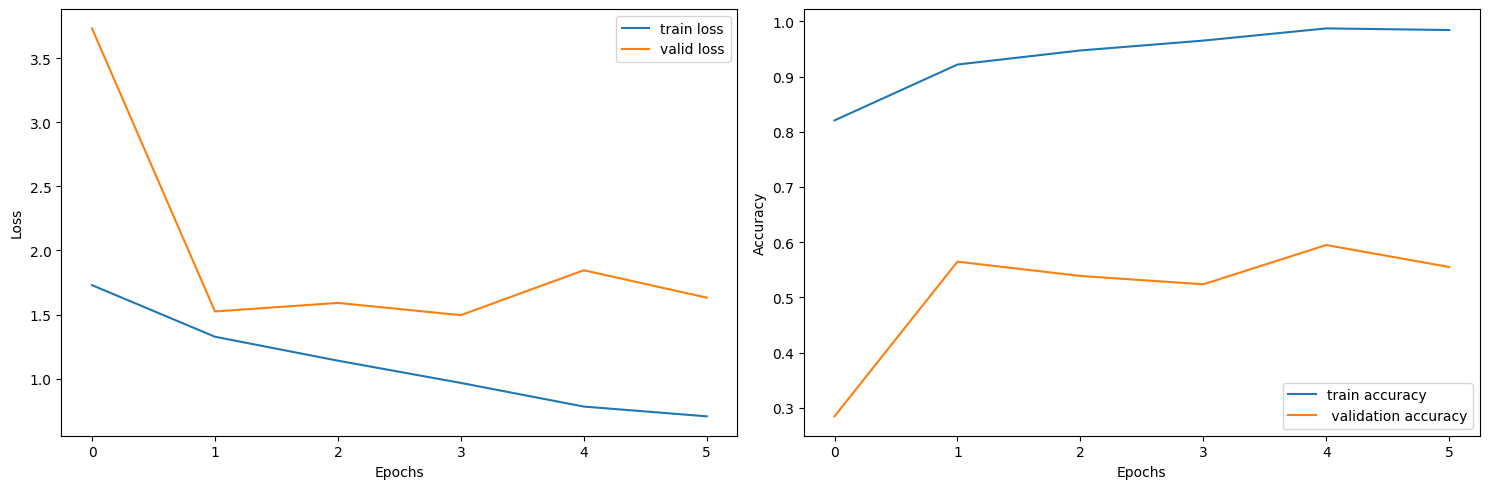

In [26]:
loss_and_acc_plots(DenseNet_Model_results,True)

Test Accuracy: 0.9787
Test Precision: 0.9811
Test Recall: 0.9776
Test F1 Score: 0.9790
Test Sensitivity: 0.9776


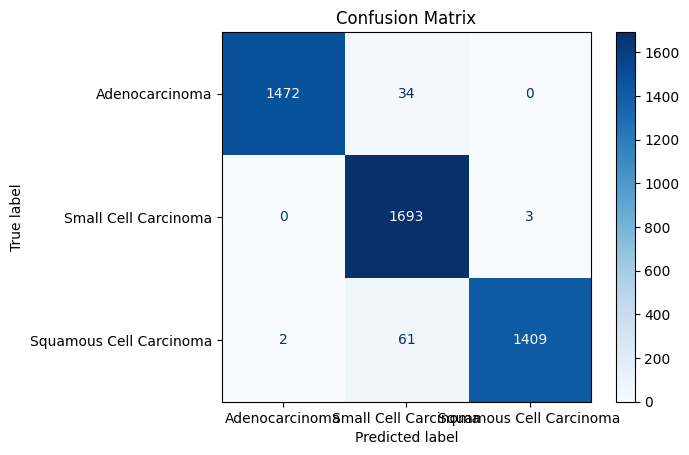

In [11]:
Model_evaluate(DenseNet_Model,train_dataloader)

Test Accuracy: 0.5237
Test Precision: 0.4830
Test Recall: 0.4890
Test F1 Score: 0.4776
Test Sensitivity: 0.4890


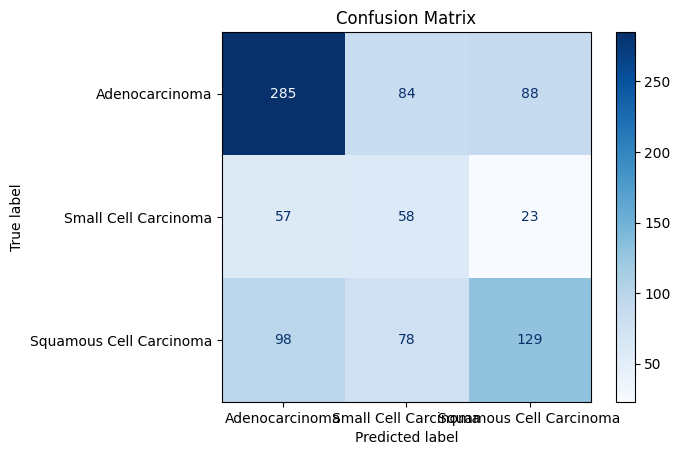

In [12]:
Model_evaluate(DenseNet_Model,valid_dataloader)

Test Accuracy: 0.5270
Test Precision: 0.5115
Test Recall: 0.5965
Test F1 Score: 0.4517
Test Sensitivity: 0.5965


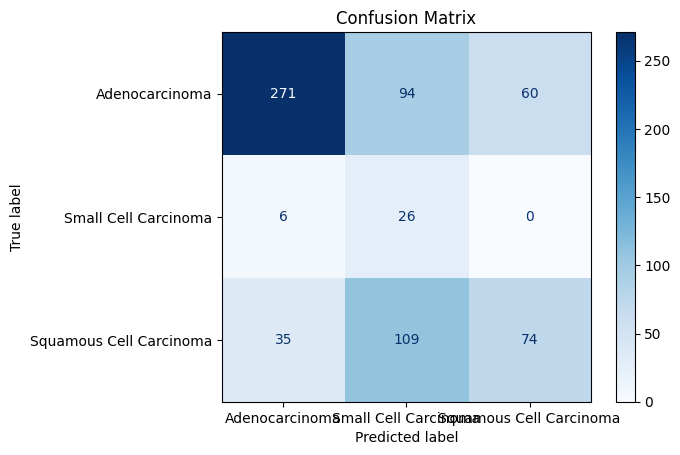

In [13]:
Model_evaluate(DenseNet_Model,test_dataloader)

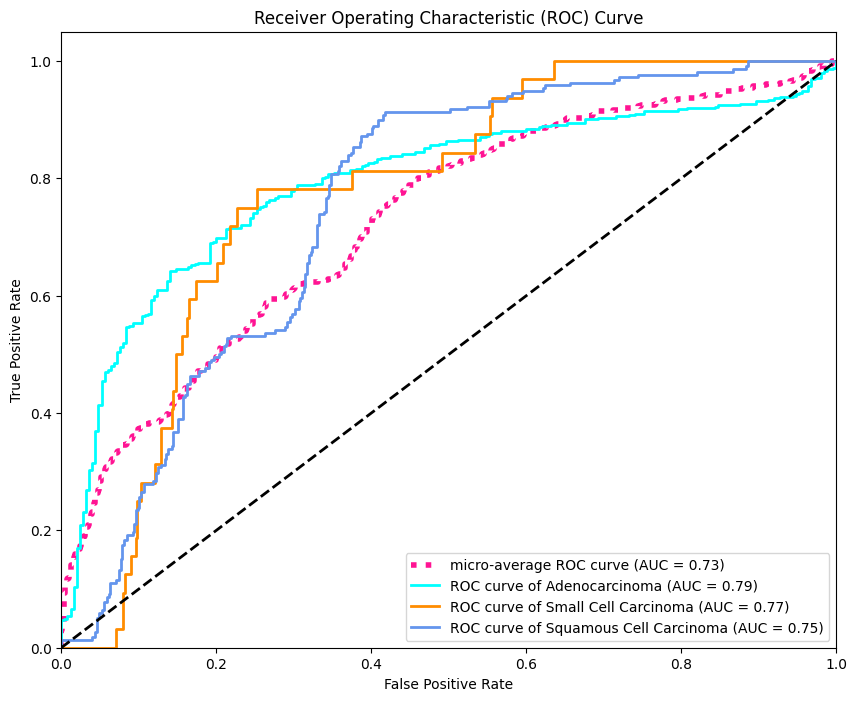

AUC Scores:
Adenocarcinoma: 0.7915
Small Cell Carcinoma: 0.7731
Squamous Cell Carcinoma: 0.7510
Micro-average: 0.7258


In [14]:
plot_roc_auc(DenseNet_Model,test_dataloader,device)

# ViT

## ViT S16

In [32]:
# Model Class
class ViT_S16(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.vits16= create_model('vit_small_patch16_224', pretrained=True)
        self.vits16.head = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self,x):
        return self.vits16(x)
# Clean GPU Memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()
   
vit_s16_model = ViT_S16(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Optimizer
optimizer = torch.optim.Adam(params=vit_s16_model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

vit_s8_model = vit_s16_model.to(device)
# Learning Rate scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)
# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

vit_s16_model_results = train(model=vit_s16_model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,patience=5,use_multiple_gpus=True)

Using 3 GPUs


  0%|                                                                  | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|█▏                                                        | 1/50 [00:56<46:19, 56.73s/it]


Epoch 1, Training Loss: 8.6091, Training Accuracy: 0.4101, Training Precision: 0.4008, Training Recall: 0.4007, Training F1: 0.3870, Test Loss: 1.1163, Test Accuracy: 0.3448, Test Precision: 0.2138, Test Recall: 0.3329, Test F1: 0.2534, Test Sensitivity: 0.3329


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|██▎                                                       | 2/50 [01:50<44:13, 55.28s/it]


Epoch 2, Training Loss: 4.6849, Training Accuracy: 0.3935, Training Precision: 0.3765, Training Recall: 0.3845, Training F1: 0.3577, Test Loss: 1.1109, Test Accuracy: 0.2877, Test Precision: 0.1943, Test Recall: 0.2942, Test F1: 0.2190, Test Sensitivity: 0.2942


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|███▍                                                      | 3/50 [02:46<43:27, 55.47s/it]


Epoch 3, Training Loss: 3.0265, Training Accuracy: 0.4503, Training Precision: 0.4278, Training Recall: 0.4340, Training F1: 0.3833, Test Loss: 1.2237, Test Accuracy: 0.3060, Test Precision: 0.1961, Test Recall: 0.3066, Test F1: 0.2295, Test Sensitivity: 0.3066


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|████▋                                                     | 4/50 [03:39<41:41, 54.38s/it]


Epoch 4, Training Loss: 2.2932, Training Accuracy: 0.4664, Training Precision: 0.4217, Training Recall: 0.4516, Training F1: 0.3798, Test Loss: 1.1454, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|█████▊                                                    | 5/50 [04:35<41:11, 54.92s/it]


Epoch 5, Training Loss: 1.9224, Training Accuracy: 0.4955, Training Precision: 0.4365, Training Recall: 0.4729, Training F1: 0.3954, Test Loss: 1.5907, Test Accuracy: 0.3093, Test Precision: 0.2425, Test Recall: 0.3527, Test F1: 0.2490, Test Sensitivity: 0.3527


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|██████▉                                                   | 6/50 [05:30<40:24, 55.10s/it]


Epoch 6, Training Loss: 1.5760, Training Accuracy: 0.5629, Training Precision: 0.4952, Training Recall: 0.5457, Training F1: 0.4522, Test Loss: 1.1804, Test Accuracy: 0.4159, Test Precision: 0.1985, Test Recall: 0.2950, Test F1: 0.2373, Test Sensitivity: 0.2950


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|██████▉                                                   | 6/50 [06:26<47:14, 64.42s/it]

Early stopping at epoch 7


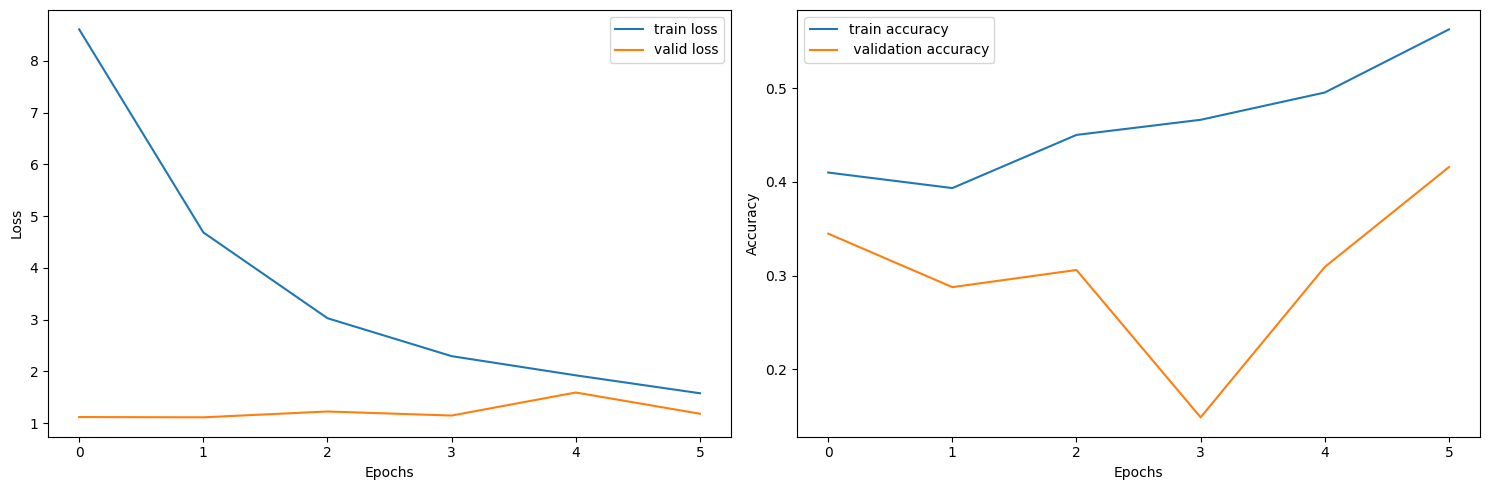

In [33]:
loss_and_acc_plots(vit_s16_model_results, save_result=True)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


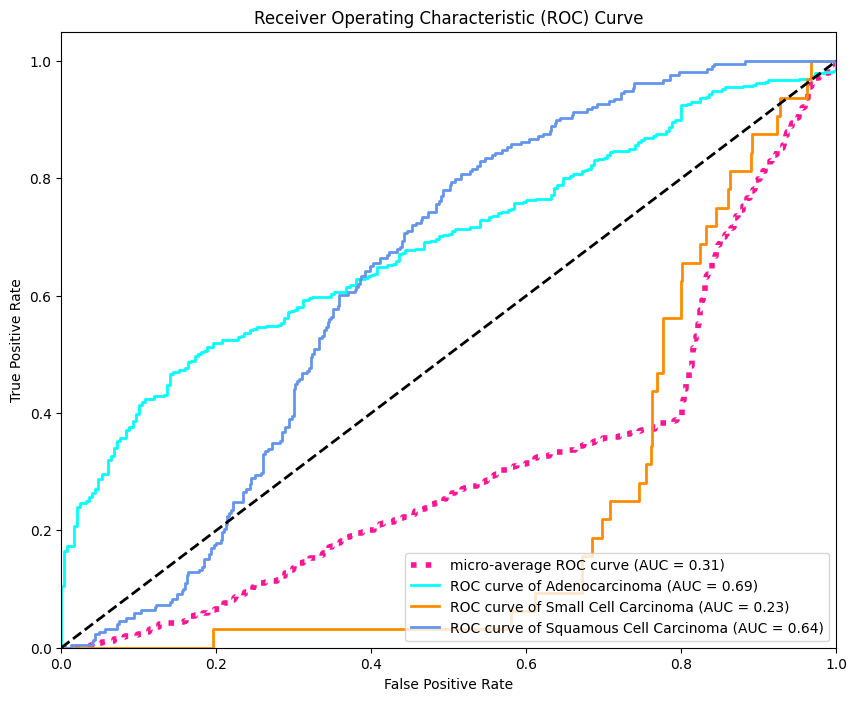

AUC Scores:
Adenocarcinoma: 0.6873
Small Cell Carcinoma: 0.2297
Squamous Cell Carcinoma: 0.6357
Micro-average: 0.3107


In [16]:
vit_s16_model.state_dict(torch.load("best_models/ViTS16/best_model.pth"))
plot_roc_auc(vit_s16_model, test_dataloader, device)

Test Accuracy: 0.3682
Test Precision: 0.5612
Test Recall: 0.3483
Test F1 Score: 0.2659
Test Sensitivity: 0.3483


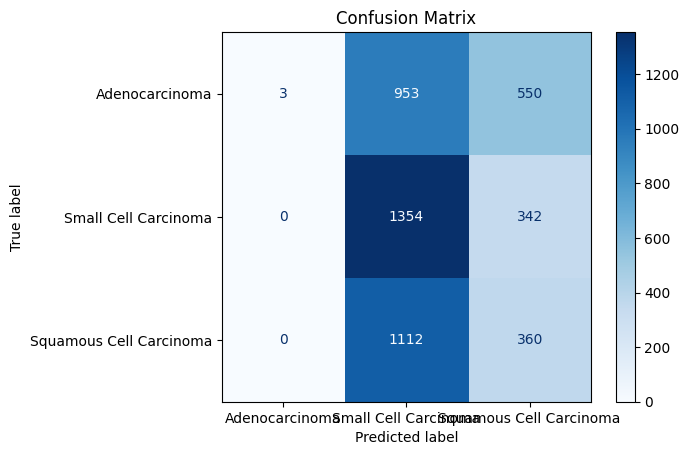

In [17]:
Model_evaluate(vit_s16_model,train_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.2069
Test Precision: 0.1384
Test Recall: 0.2731
Test F1 Score: 0.1653
Test Sensitivity: 0.2731


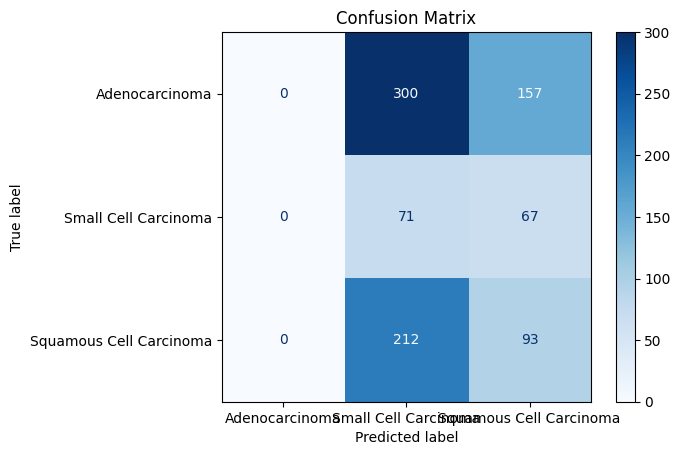

In [18]:
Model_evaluate(vit_s16_model,valid_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.1591
Test Precision: 0.1229
Test Recall: 0.2601
Test F1 Score: 0.1481
Test Sensitivity: 0.2601


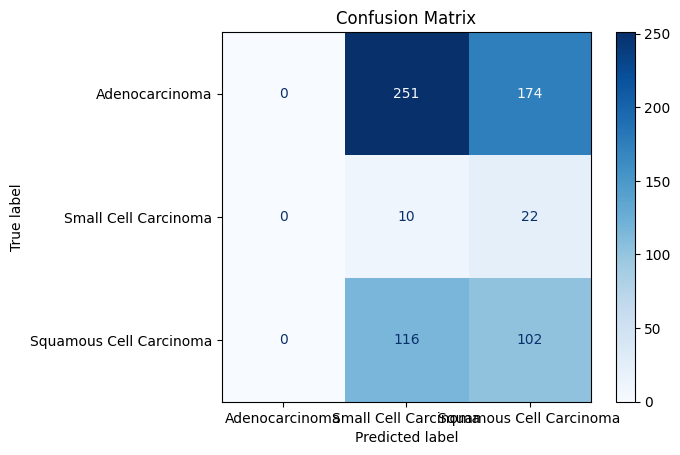

In [19]:
Model_evaluate(vit_s16_model,test_dataloader)

## ViT B8

In [40]:
class ViT_B8(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.vitb8= create_model('vit_base_patch8_224', pretrained=True)
        self.vitb8.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self,x):
        return self.vitb8(x)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()
   
vit_B8_model = ViT_B8(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=vit_B8_model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

vit_B8_model = vit_B8_model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

vit_B8_model_results = train(model=vit_B8_model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,
                            patience=5,use_multiple_gpus=True)


Using 3 GPUs


  0%|                                                                  | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|█                                                      | 1/50 [02:33<2:05:06, 153.19s/it]


Epoch 1, Training Loss: 9.0827, Training Accuracy: 0.3355, Training Precision: 0.3233, Training Recall: 0.3257, Training F1: 0.3161, Test Loss: 1.0900, Test Accuracy: 0.4925, Test Precision: 0.1693, Test Recall: 0.3333, Test F1: 0.2245, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|██▏                                                    | 2/50 [05:09<2:04:06, 155.13s/it]


Epoch 2, Training Loss: 3.6131, Training Accuracy: 0.3418, Training Precision: 0.3321, Training Recall: 0.3319, Training F1: 0.3110, Test Loss: 1.0926, Test Accuracy: 0.4925, Test Precision: 0.1693, Test Recall: 0.3333, Test F1: 0.2245, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|███▎                                                   | 3/50 [07:51<2:03:57, 158.23s/it]


Epoch 3, Training Loss: 2.8934, Training Accuracy: 0.3465, Training Precision: 0.3344, Training Recall: 0.3323, Training F1: 0.3064, Test Loss: 1.1172, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|████▍                                                  | 4/50 [10:29<2:01:19, 158.25s/it]


Epoch 4, Training Loss: 2.5121, Training Accuracy: 0.3631, Training Precision: 0.3546, Training Recall: 0.3486, Training F1: 0.3067, Test Loss: 1.1229, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|█████▌                                                 | 5/50 [13:07<1:58:24, 157.89s/it]


Epoch 5, Training Loss: 2.3637, Training Accuracy: 0.3686, Training Precision: 0.3353, Training Recall: 0.3525, Training F1: 0.3030, Test Loss: 1.1426, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|█████▌                                                 | 5/50 [15:44<2:21:38, 188.86s/it]

Early stopping at epoch 6


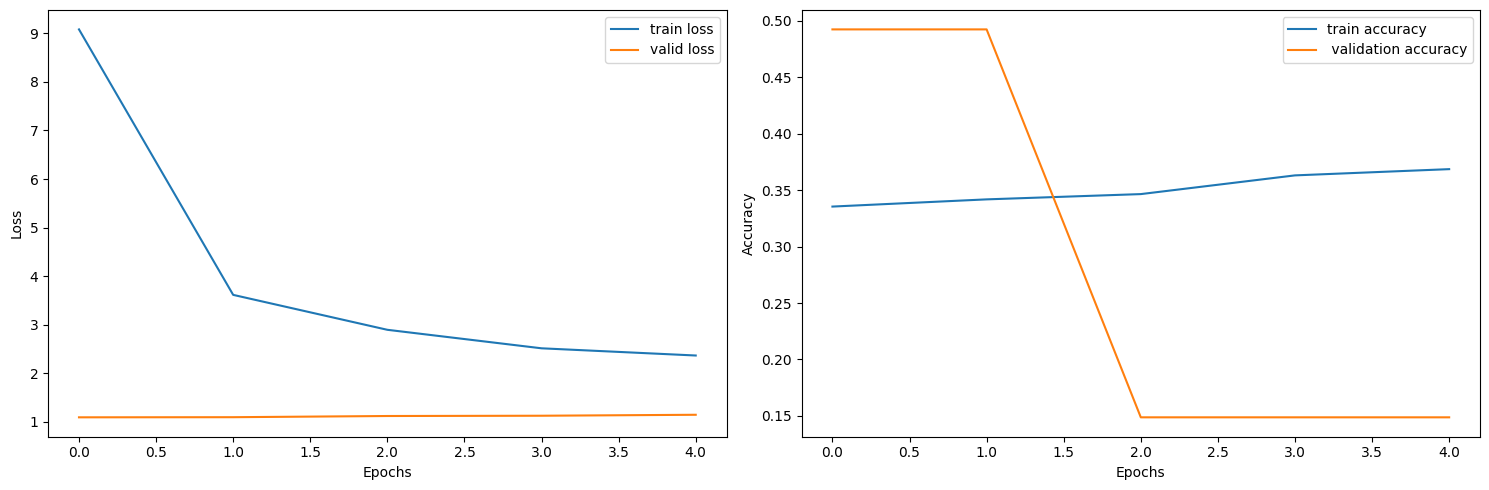

In [41]:
loss_and_acc_plots(vit_B8_model_results, save_result=True)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


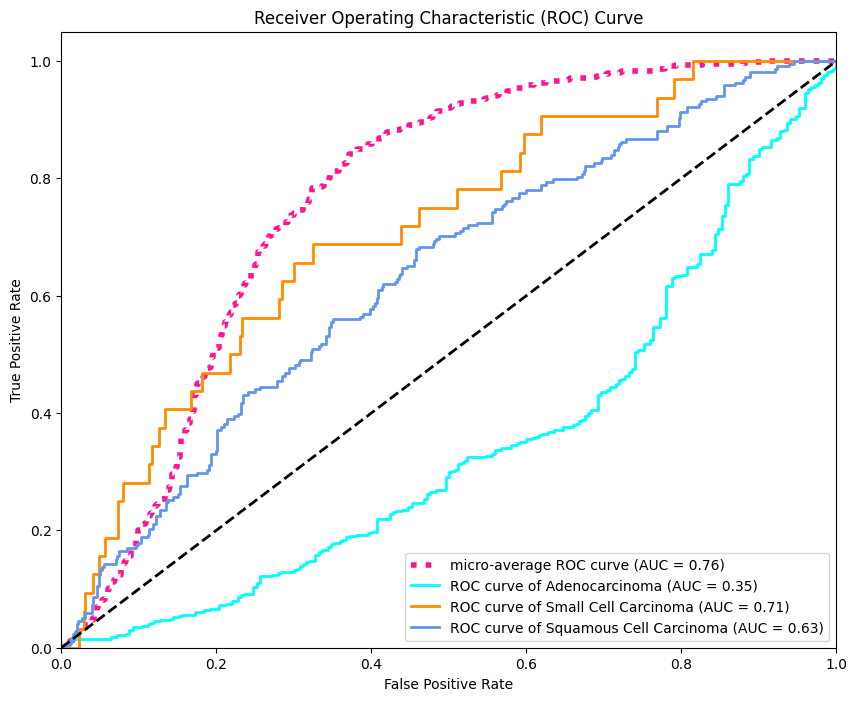

AUC Scores:
Adenocarcinoma: 0.3456
Small Cell Carcinoma: 0.7085
Squamous Cell Carcinoma: 0.6318
Micro-average: 0.7642


In [21]:
vit_B8_model.state_dict(torch.load("best_models/ViTB8/best_model.pth"))
plot_roc_auc(vit_B8_model, test_dataloader, device)

Test Accuracy: 0.3363
Test Precision: 0.3427
Test Recall: 0.3516
Test F1 Score: 0.2551
Test Sensitivity: 0.3516


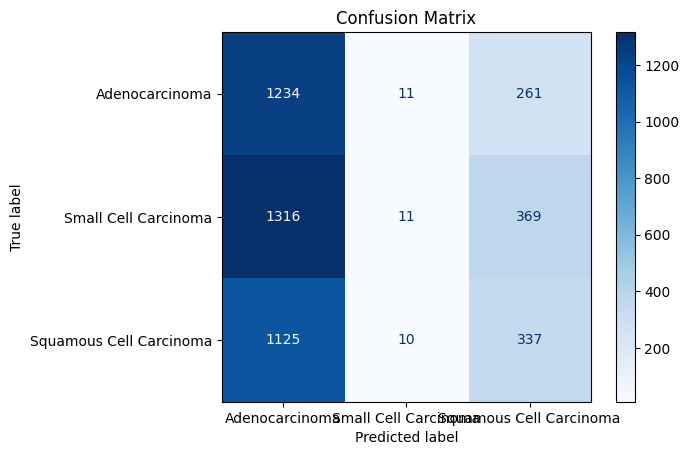

In [22]:
Model_evaluate(vit_B8_model,train_dataloader)

Test Accuracy: 0.4386
Test Precision: 0.2105
Test Recall: 0.3005
Test F1 Score: 0.2241
Test Sensitivity: 0.3005


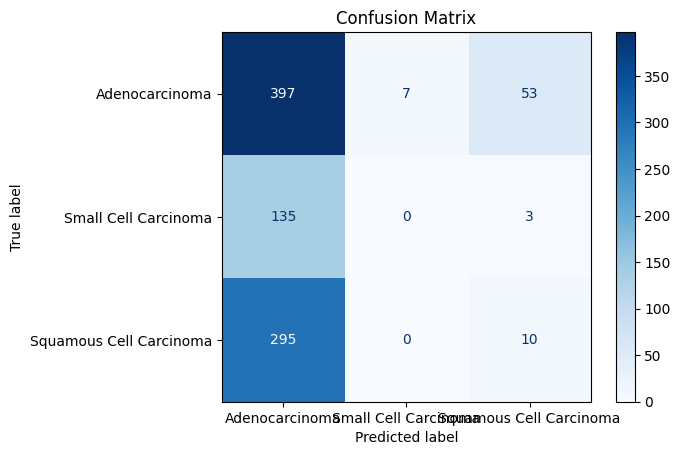

In [23]:
Model_evaluate(vit_B8_model,valid_dataloader)

Test Accuracy: 0.5848
Test Precision: 0.3722
Test Recall: 0.3435
Test F1 Score: 0.3195
Test Sensitivity: 0.3435


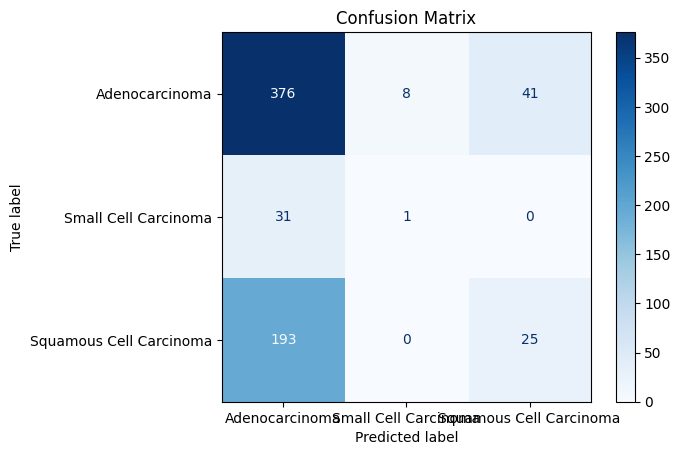

In [24]:
Model_evaluate(vit_B8_model,test_dataloader)

## ViT B16

In [46]:
class ViT_B16(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.vitb16= create_model('vit_base_patch16_224', pretrained=True)
        self.vitb16.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self,x):
        return self.vitb16(x)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()
   
ViT_B16_model = ViT_B16(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ViT_B16_model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

ViT_B16_model = ViT_B16_model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

ViT_B16_model_results = train(model=ViT_B16_model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,
                            patience=5,use_multiple_gpus=True)


Using 3 GPUs


  0%|                                                                  | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|█                                                       | 1/50 [01:23<1:07:48, 83.03s/it]


Epoch 1, Training Loss: 9.4051, Training Accuracy: 0.3542, Training Precision: 0.3476, Training Recall: 0.3478, Training F1: 0.3452, Test Loss: 1.1248, Test Accuracy: 0.3588, Test Precision: 0.1130, Test Recall: 0.3333, Test F1: 0.1687, Test Sensitivity: 0.3333


  4%|██▏                                                     | 2/50 [02:43<1:05:18, 81.64s/it]


Epoch 2, Training Loss: 3.9274, Training Accuracy: 0.4077, Training Precision: 0.3866, Training Recall: 0.3953, Training F1: 0.3701, Test Loss: 1.1661, Test Accuracy: 0.3405, Test Precision: 0.2120, Test Recall: 0.3300, Test F1: 0.2509, Test Sensitivity: 0.3300


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|███▎                                                    | 3/50 [04:01<1:02:33, 79.86s/it]


Epoch 3, Training Loss: 2.8851, Training Accuracy: 0.4564, Training Precision: 0.4285, Training Recall: 0.4452, Training F1: 0.4065, Test Loss: 1.4440, Test Accuracy: 0.4246, Test Precision: 0.1609, Test Recall: 0.2874, Test F1: 0.2063, Test Sensitivity: 0.2874


  8%|████▍                                                   | 4/50 [05:18<1:00:31, 78.94s/it]


Epoch 4, Training Loss: 2.4675, Training Accuracy: 0.4877, Training Precision: 0.4568, Training Recall: 0.4782, Training F1: 0.4318, Test Loss: 1.1319, Test Accuracy: 0.4149, Test Precision: 0.1550, Test Recall: 0.2808, Test F1: 0.1997, Test Sensitivity: 0.2808


 10%|█████▊                                                    | 5/50 [06:37<59:08, 78.85s/it]


Epoch 5, Training Loss: 2.2148, Training Accuracy: 0.5276, Training Precision: 0.4732, Training Recall: 0.5180, Training F1: 0.4459, Test Loss: 0.8700, Test Accuracy: 0.4558, Test Precision: 0.3201, Test Recall: 0.4974, Test F1: 0.3568, Test Sensitivity: 0.4974


 12%|██████▉                                                   | 6/50 [07:56<57:47, 78.81s/it]


Epoch 6, Training Loss: 2.0224, Training Accuracy: 0.5712, Training Precision: 0.5147, Training Recall: 0.5594, Training F1: 0.5094, Test Loss: 1.0377, Test Accuracy: 0.4655, Test Precision: 0.4350, Test Recall: 0.3524, Test F1: 0.3043, Test Sensitivity: 0.3524


 14%|████████                                                  | 7/50 [09:14<56:13, 78.44s/it]


Epoch 7, Training Loss: 1.8917, Training Accuracy: 0.6237, Training Precision: 0.5455, Training Recall: 0.6065, Training F1: 0.5267, Test Loss: 1.4061, Test Accuracy: 0.4181, Test Precision: 0.2890, Test Recall: 0.3836, Test F1: 0.3137, Test Sensitivity: 0.3836


 16%|█████████▎                                                | 8/50 [10:32<54:49, 78.33s/it]


Epoch 8, Training Loss: 1.8066, Training Accuracy: 0.6367, Training Precision: 0.5944, Training Recall: 0.6229, Training F1: 0.5770, Test Loss: 1.1762, Test Accuracy: 0.3578, Test Precision: 0.3406, Test Recall: 0.3660, Test F1: 0.3469, Test Sensitivity: 0.3660


 18%|██████████▍                                               | 9/50 [11:52<54:00, 79.05s/it]


Epoch 9, Training Loss: 1.6691, Training Accuracy: 0.6684, Training Precision: 0.6433, Training Recall: 0.6550, Training F1: 0.6255, Test Loss: 1.1200, Test Accuracy: 0.2953, Test Precision: 0.3310, Test Recall: 0.3206, Test F1: 0.3022, Test Sensitivity: 0.3206


 18%|██████████                                              | 9/50 [13:19<1:00:40, 88.79s/it]

Early stopping at epoch 10


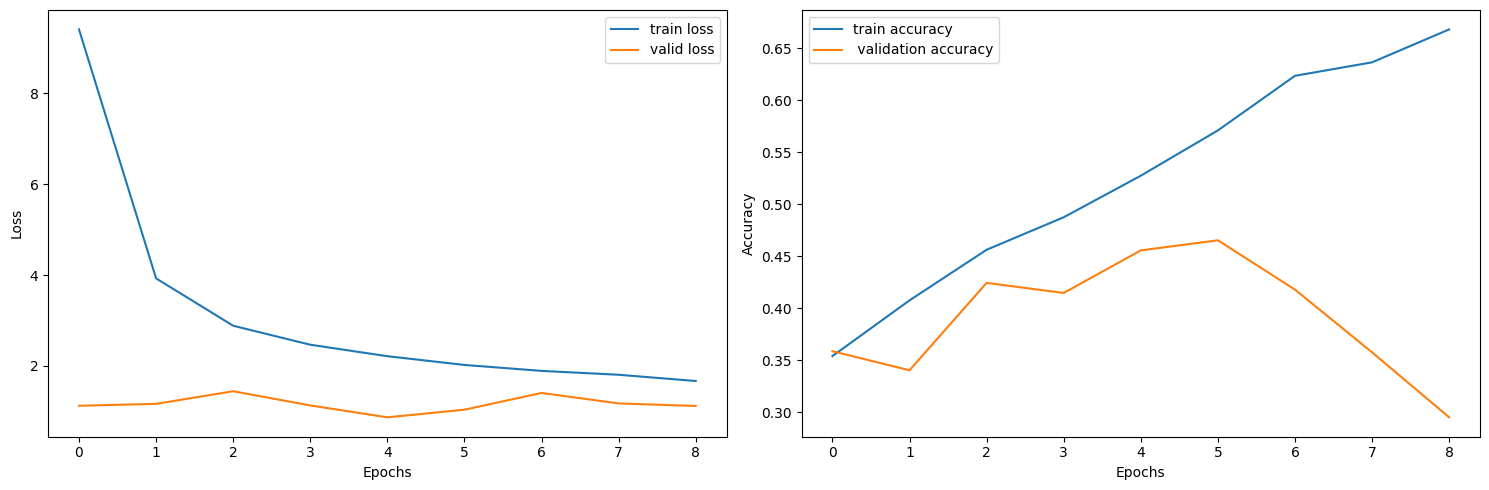

In [47]:
loss_and_acc_plots(ViT_B16_model_results, save_result=True)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


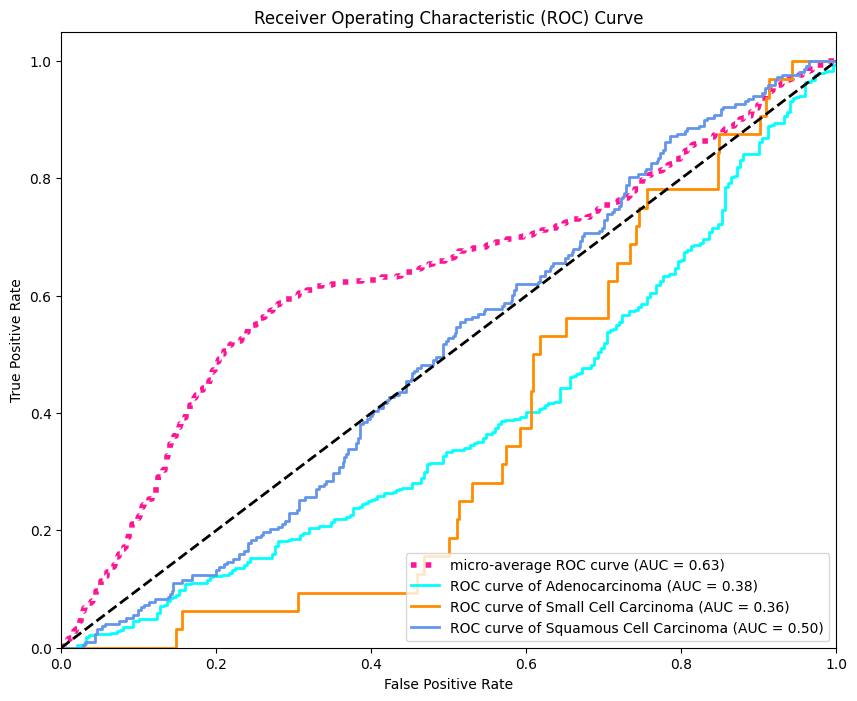

AUC Scores:
Adenocarcinoma: 0.3842
Small Cell Carcinoma: 0.3644
Squamous Cell Carcinoma: 0.5004
Micro-average: 0.6324


In [26]:
ViT_B16_model.state_dict(torch.load("best_models/ViTB16/best_model.pth"))
plot_roc_auc(ViT_B16_model, test_dataloader, device)

Test Accuracy: 0.3131
Test Precision: 0.5329
Test Recall: 0.3253
Test F1 Score: 0.1712
Test Sensitivity: 0.3253


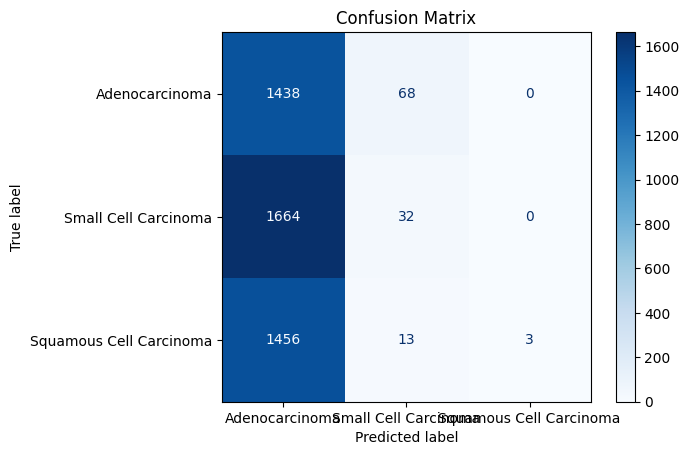

In [27]:
Model_evaluate(ViT_B16_model,train_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.4537
Test Precision: 0.1624
Test Recall: 0.3071
Test F1 Score: 0.2125
Test Sensitivity: 0.3071


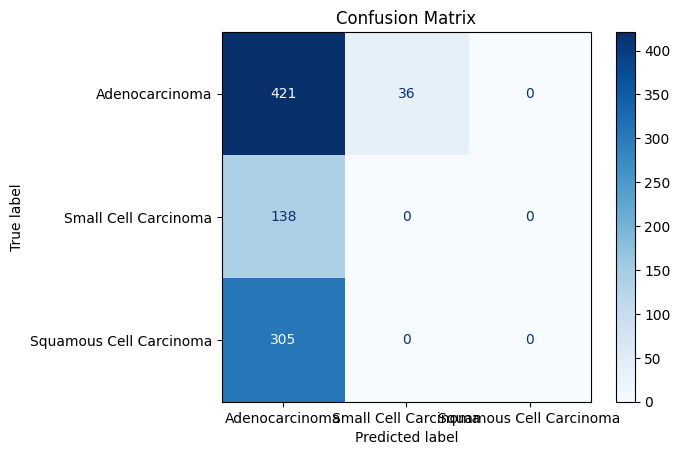

In [28]:
Model_evaluate(ViT_B16_model,valid_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.5625
Test Precision: 0.2082
Test Recall: 0.3106
Test F1 Score: 0.2493
Test Sensitivity: 0.3106


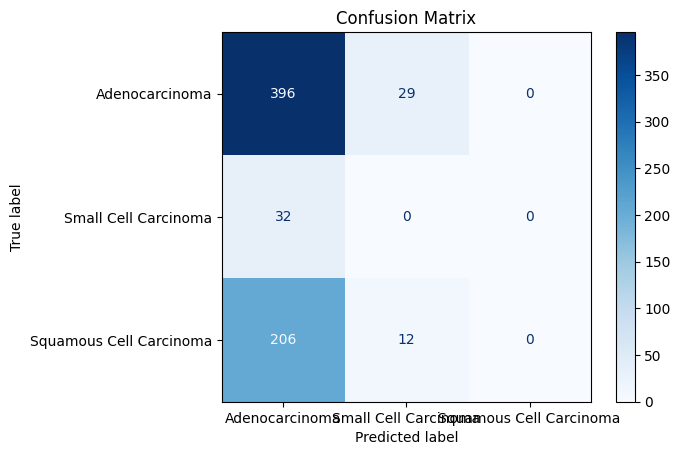

In [29]:
Model_evaluate(ViT_B16_model,test_dataloader)

## ViT S16 Dino

In [30]:
class ViTS16_Dino(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.Dino = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
        self.head = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        features = self.Dino(x)
        return self.head(features)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()

ViTS16_Dino_Model = ViTS16_Dino(3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ViTS16_Dino_Model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

ViTS16_Dino_Model = ViTS16_Dino_Model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

ViTS16_Dino_results = train(model=ViTS16_Dino_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,
                            patience=10,use_multiple_gpus=True)

Using cache found in /home/aa23798/.cache/torch/hub/facebookresearch_dino_main


Using 3 GPUs


  0%|                                                                  | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|█▏                                                        | 1/50 [00:55<45:29, 55.70s/it]


Epoch 1, Training Loss: 3.3704, Training Accuracy: 0.3380, Training Precision: 0.3346, Training Recall: 0.3341, Training F1: 0.3336, Test Loss: 1.1020, Test Accuracy: 0.3588, Test Precision: 0.1130, Test Recall: 0.3333, Test F1: 0.1687, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|██▎                                                       | 2/50 [01:51<44:27, 55.56s/it]


Epoch 2, Training Loss: 2.5981, Training Accuracy: 0.3497, Training Precision: 0.3214, Training Recall: 0.3315, Training F1: 0.2496, Test Loss: 1.1098, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|███▍                                                      | 3/50 [02:43<42:13, 53.90s/it]


Epoch 3, Training Loss: 2.2232, Training Accuracy: 0.3582, Training Precision: 0.2972, Training Recall: 0.3295, Training F1: 0.1955, Test Loss: 1.1160, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|████▋                                                     | 4/50 [03:41<42:41, 55.69s/it]


Epoch 4, Training Loss: 2.0170, Training Accuracy: 0.3637, Training Precision: 0.1210, Training Recall: 0.3333, Training F1: 0.1775, Test Loss: 1.1194, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|█████▊                                                    | 5/50 [04:40<42:33, 56.75s/it]


Epoch 5, Training Loss: 1.8939, Training Accuracy: 0.3637, Training Precision: 0.1210, Training Recall: 0.3333, Training F1: 0.1775, Test Loss: 1.1221, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|██████▉                                                   | 6/50 [05:35<41:13, 56.23s/it]


Epoch 6, Training Loss: 1.8146, Training Accuracy: 0.3635, Training Precision: 0.5169, Training Recall: 0.3333, Training F1: 0.1792, Test Loss: 1.1240, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 14%|████████                                                  | 7/50 [06:31<40:17, 56.23s/it]


Epoch 7, Training Loss: 1.7859, Training Accuracy: 0.3635, Training Precision: 0.3188, Training Recall: 0.3332, Training F1: 0.2185, Test Loss: 1.1257, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 16%|█████████▎                                                | 8/50 [07:24<38:42, 55.30s/it]


Epoch 8, Training Loss: 1.7222, Training Accuracy: 0.3605, Training Precision: 0.3472, Training Recall: 0.3360, Training F1: 0.2135, Test Loss: 1.1087, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 18%|██████████▍                                               | 9/50 [08:21<38:04, 55.72s/it]


Epoch 9, Training Loss: 1.6909, Training Accuracy: 0.3605, Training Precision: 0.3511, Training Recall: 0.3374, Training F1: 0.2310, Test Loss: 1.1235, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|███████████▍                                             | 10/50 [09:18<37:18, 55.96s/it]


Epoch 10, Training Loss: 1.6638, Training Accuracy: 0.3605, Training Precision: 0.1210, Training Recall: 0.3333, Training F1: 0.1775, Test Loss: 1.1226, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0886, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|███████████▍                                             | 10/50 [10:12<40:49, 61.24s/it]

Early stopping at epoch 11


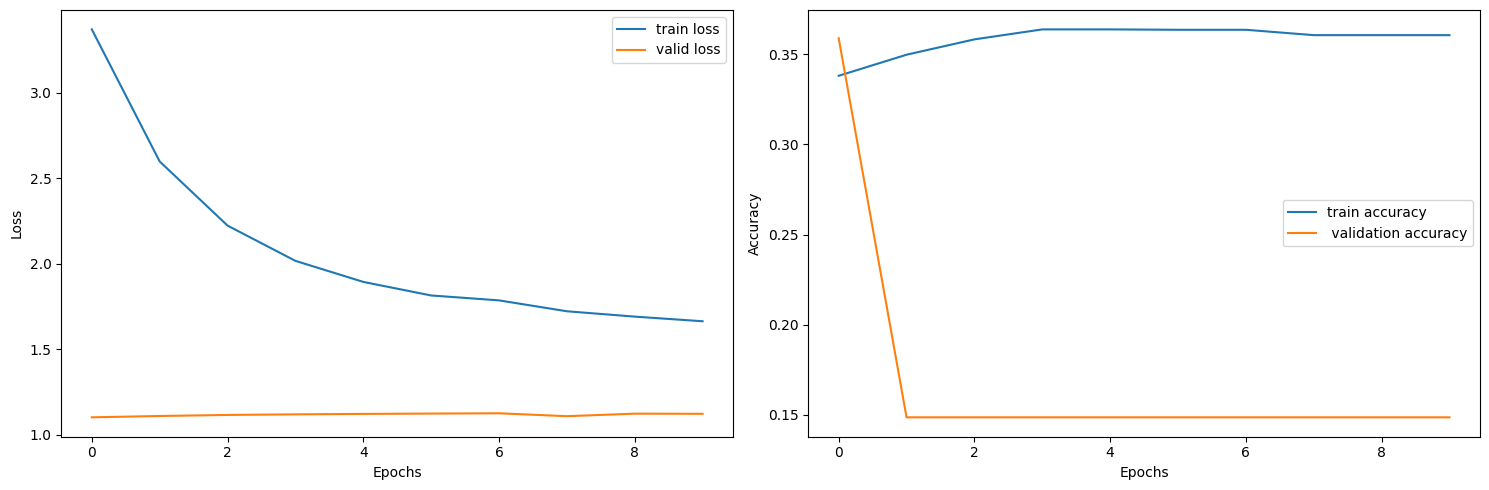

In [31]:
loss_and_acc_plots(ViTS16_Dino_results, save_result=True)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torch/nn/modules/module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


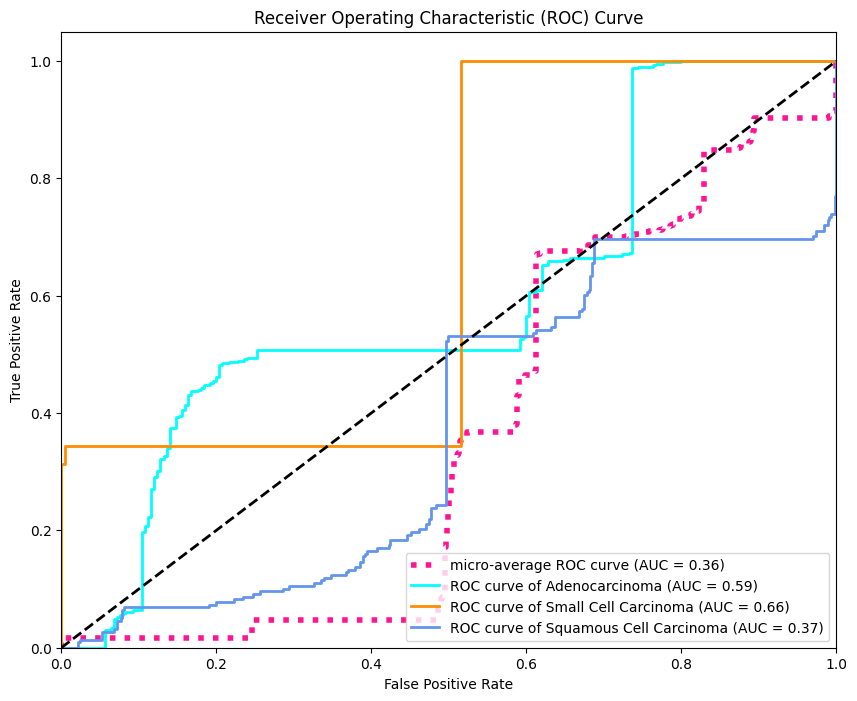

AUC Scores:
Adenocarcinoma: 0.5927
Small Cell Carcinoma: 0.6610
Squamous Cell Carcinoma: 0.3730
Micro-average: 0.3628


In [32]:
ViTS16_Dino_Model.state_dict(torch.load("best_model.pth"))
plot_roc_auc(ViTS16_Dino_Model, test_dataloader, device)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.3605
Test Precision: 0.1210
Test Recall: 0.3333
Test F1 Score: 0.1775
Test Sensitivity: 0.3333


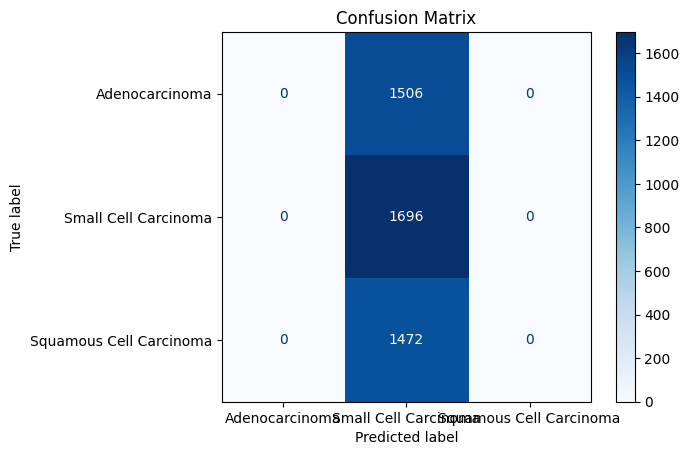

In [33]:
Model_evaluate(ViTS16_Dino_Model,train_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.1487
Test Precision: 0.0511
Test Recall: 0.3333
Test F1 Score: 0.0886
Test Sensitivity: 0.3333


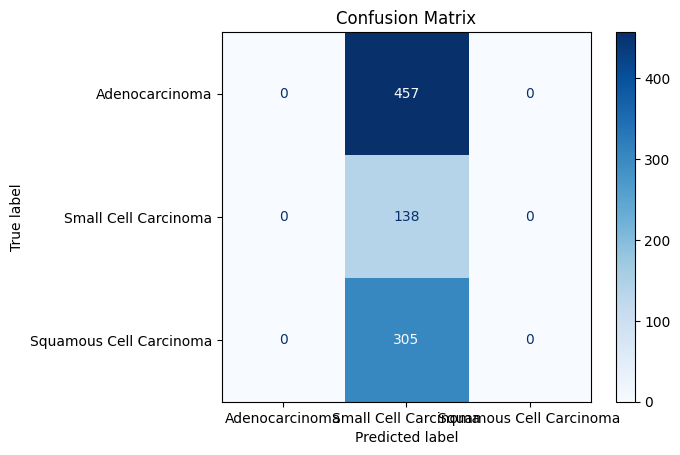

In [34]:
Model_evaluate(ViTS16_Dino_Model,valid_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.0455
Test Precision: 0.0158
Test Recall: 0.3333
Test F1 Score: 0.0302
Test Sensitivity: 0.3333


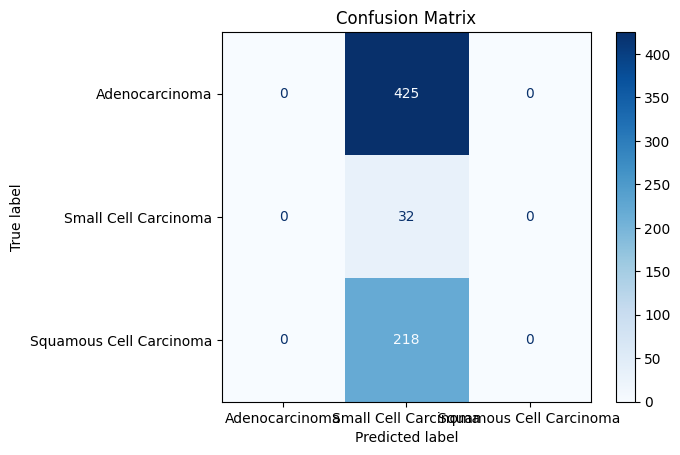

In [35]:
Model_evaluate(ViTS16_Dino_Model,test_dataloader)

# Results Analysis 

**Testing Results**

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\text{Models} & \text{Accuracy} & \text{Precision} & \text{Recall} & \text{F1-score} & \text{Sensitivity} \\
\hline
\text{Resnet101} & 51.61\% & 36.21\% & 38.00\% & 34.95\% & 38.00\%\\
\hline
\textbf{Densenet121} & 52.70\% & 51.15\% & 59.65\% & 45.17\% & 59.65\% \\
\hline
\end{array}
$$


**Table: Testing Results**


$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\text{Model} & \text{Accuracy} & \text{Precision} & \text{Recall} & \text{F1-score} & \text{Sensitivity} \\
\hline
\text{ViT-S/16} & {15.91\%} & 12.29\% & {26.01\%} & {14.81\%} & {26.01\%} \\
\hline
\text{ViT-B/8} & 58.48\% & 37.22\% & 34.35\% & 31.95\% & 34.35\% \\
\hline
\text{ViT-B/16} & 56.25\% &{20.82\%} & 31.06\% & 24.93\% & 31.06\% \\
\hline
\text{ViT-S/16 Dino} & 4.55\% & 1.58\% & 33.33\% & 3.02\% & 33.33\% \\
\hline
\end{array}
$$


The results indicate that both CNN-based and transformer-based models failed to classify lung cancer types. Therefore, in the next phase of the research we will apply image pre-processing techniques to enhance feature visibility, which may assist the models in extracting useful information and able to accurately classify cancer types.

# Image Processing

Several image processing techniques were employed to enhance feature visibility, including :

**Gaussian Blur:** was Applied for image smoothing in order to reduce noise.

**Contrast Limited Adaptive Histogram Equalization (CLAHE):** was implmenetd to mitigate noise amplification.

**Edge Enhancement:** This technique was employed to emphasize boundaries and structural details within the images.

In [21]:

def enhance_tumor_features(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Gaussian smoothing
    smoothed_image = cv2.GaussianBlur(image, (5, 5), 0)

    
    lab_image = cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2Lab)
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    enhanced_lab = cv2.merge((cl, a_channel, b_channel))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_Lab2BGR)

    # Edge enhancement techniques
    # Different filters can be used, (Laplacian Filter,Unsharp Masking,High-pass Filter,Bilateral Filter)

    # 1. Laplacian Filter
    # edges_laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    # edges_laplacian = np.uint8(np.absolute(edges_laplacian))

    # 2. Unsharp Masking
    # blurred = cv2.GaussianBlur(enhanced_image, (5, 5), 0)
    # edges_unsharp = cv2.addWeighted(enhanced_image, 1.5, blurred, -0.5, 0)

    # 3. High-pass Filter
    # kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    # edges_high_pass = cv2.filter2D(enhanced_image, -1, kernel)

    # 4. Bilateral Filter
    edges_bilateral = cv2.bilateralFilter(enhanced_image, d=9, sigmaColor=75, sigmaSpace=75)

    # edge enhancement method to use

    # edges = edges_laplacian  # (Laplacian Filter)
    #edges = edges_unsharp  # (Unsharp Masking)
    # edges = edges_high_pass  # (High-pass Filter)
    edges = edges_bilateral   # (Bilateral Filter)

    # Combine original enhanced image with edges
    final_enhanced_image = cv2.addWeighted(enhanced_image, 0.7, edges, 0.3, 0)

    return final_enhanced_image

def process_images_in_folder(input_folder_path, output_folder_path):
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    for root, dirs, files in os.walk(input_folder_path):
        for file in files:
            if file.lower().endswith(('.png')): 
                image_path = os.path.join(root, file)
                relative_path = os.path.relpath(image_path, input_folder_path)
                output_image_path = os.path.join(output_folder_path, relative_path)

                if not os.path.exists(os.path.dirname(output_image_path)):
                    os.makedirs(os.path.dirname(output_image_path))

                if image_path is not None:
                    # Process the image and save it in the new folder
                    processed_image = enhance_tumor_features(image_path)
                    cv2.imwrite(output_image_path, processed_image)
                else:
                    print("Error loading image")



In [59]:
input_folder_path = "Final_dataset/train"  
output_folder_path = "Final_dataset/Processed Data/train"  
process_images_in_folder(input_folder_path, output_folder_path)

input_folder_path = "Final_dataset/valid"  
output_folder_path = "Final_dataset/Processed Data/valid"  
process_images_in_folder(input_folder_path, output_folder_path)

input_folder_path = "Final_dataset/test"  
output_folder_path = "Final_dataset/Processed Data/test"  
process_images_in_folder(input_folder_path, output_folder_path)

input_folder_path = "Final_dataset/Aug"  
output_folder_path = "Final_dataset/Processed Data/Aug"  
process_images_in_folder(input_folder_path, output_folder_path)



The images processed and organized into a folder. The next step is to re-train the models using this enhanced dataset to assess any improvements.

**Note**: Two Models only will be trained which are Densenet121 and ViT-B16

# Models Re-train on Processed Data

In [2]:
train_dataloader,valid_dataloader,test_dataloader= Create_dataloader(train_dir="Final_dataset/Processed Data/Aug"
                                                                     ,valid_dir="Final_dataset/Processed Data/valid"
                                                                     ,test_dir="Final_dataset/Processed Data/test"
                                                                     ,batch_size=32)


## DenseNet121

In [17]:
class DenseNet(torch.nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.densenet = torchvision.models.densenet121(pretrained=True)
        
        self.densenet.classifier = nn.Sequential(
            nn.Linear(self.densenet.classifier.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.densenet(x)
    
DenseNet_Model = DenseNet(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=DenseNet_Model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

scheduler = ExponentialLR(optimizer, gamma=0.9)

DenseNet_Model = DenseNet_Model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

DenseNet_Model_results = train(model=DenseNet_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,
                            scheduler=scheduler)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`


Epoch 1, Training Loss: 1.7622, Training Accuracy: 0.8161, Training Precision: 0.8206, Training Recall: 0.8196, Training F1: 0.8196, Test Loss: 4.2224, Test Accuracy: 0.4019, Test Precision: 0.2755, Test Recall: 0.4048, Test F1: 0.3051, Test Sensitivity: 0.4048


  4%|█▊                                          | 2/50 [02:07<50:27, 63.08s/it]


Epoch 2, Training Loss: 1.4183, Training Accuracy: 0.9054, Training Precision: 0.9048, Training Recall: 0.9045, Training F1: 0.9046, Test Loss: 1.3199, Test Accuracy: 0.5621, Test Precision: 0.5415, Test Recall: 0.5223, Test F1: 0.5304, Test Sensitivity: 0.5223


  6%|██▋                                         | 3/50 [03:06<47:57, 61.23s/it]


Epoch 3, Training Loss: 1.0937, Training Accuracy: 0.9658, Training Precision: 0.9658, Training Recall: 0.9651, Training F1: 0.9654, Test Loss: 1.1429, Test Accuracy: 0.6774, Test Precision: 0.6327, Test Recall: 0.6222, Test F1: 0.6147, Test Sensitivity: 0.6222


  8%|███▌                                        | 4/50 [04:07<47:02, 61.36s/it]


Epoch 4, Training Loss: 0.9743, Training Accuracy: 0.9675, Training Precision: 0.9706, Training Recall: 0.9702, Training F1: 0.9704, Test Loss: 2.7736, Test Accuracy: 0.4558, Test Precision: 0.5524, Test Recall: 0.5511, Test F1: 0.4358, Test Sensitivity: 0.5511


 10%|████▍                                       | 5/50 [05:08<45:44, 60.98s/it]


Epoch 5, Training Loss: 0.9622, Training Accuracy: 0.9549, Training Precision: 0.9551, Training Recall: 0.9545, Training F1: 0.9548, Test Loss: 1.2198, Test Accuracy: 0.5754, Test Precision: 0.5693, Test Recall: 0.6041, Test F1: 0.5325, Test Sensitivity: 0.6041


 10%|████▍                                       | 5/50 [06:10<55:36, 74.14s/it]

Early stopping at epoch 6


In [21]:
DenseNet_Model.load_state_dict(torch.load('best_models/Pre-Processed/DenseNet121/best_model.pth'))

<All keys matched successfully>

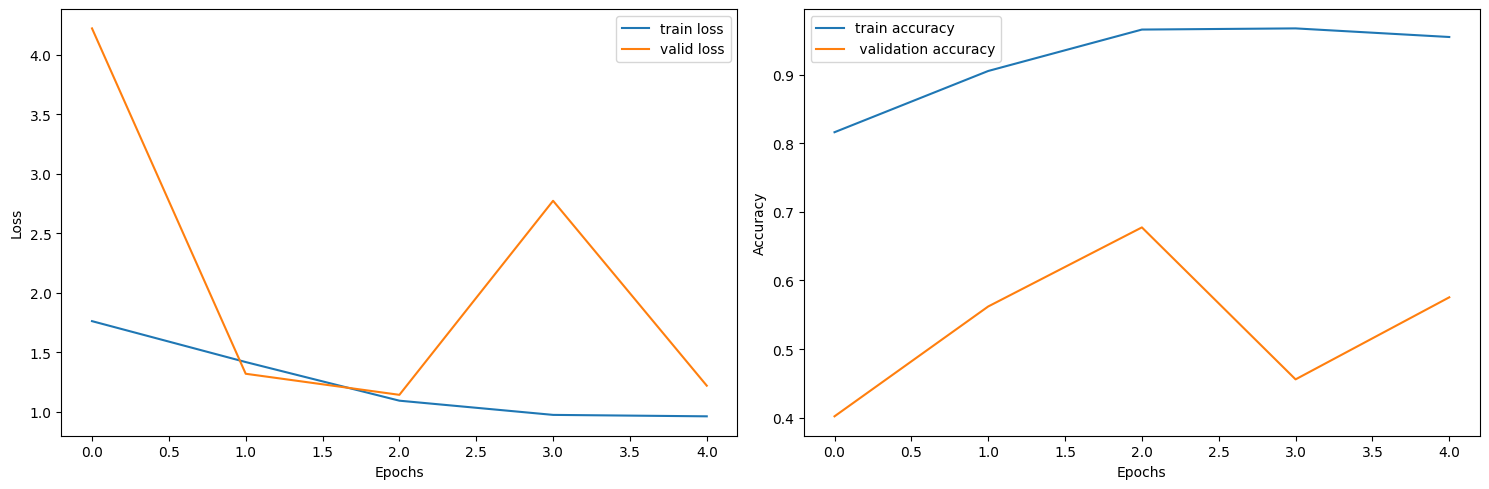

In [22]:
loss_and_acc_plots(DenseNet_Model_results,True)

Test Accuracy: 0.9832
Test Precision: 0.9828
Test Recall: 0.9841
Test F1 Score: 0.9832
Test Sensitivity: 0.9841


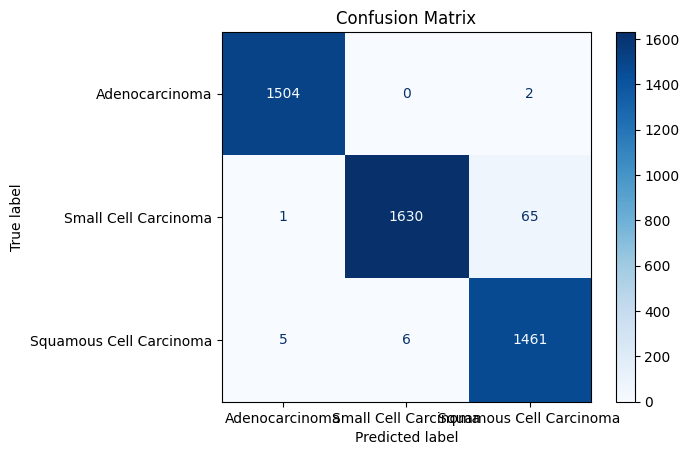

In [23]:
Model_evaluate(DenseNet_Model,train_dataloader)

Test Accuracy: 0.6774
Test Precision: 0.6327
Test Recall: 0.6222
Test F1 Score: 0.6147
Test Sensitivity: 0.6222


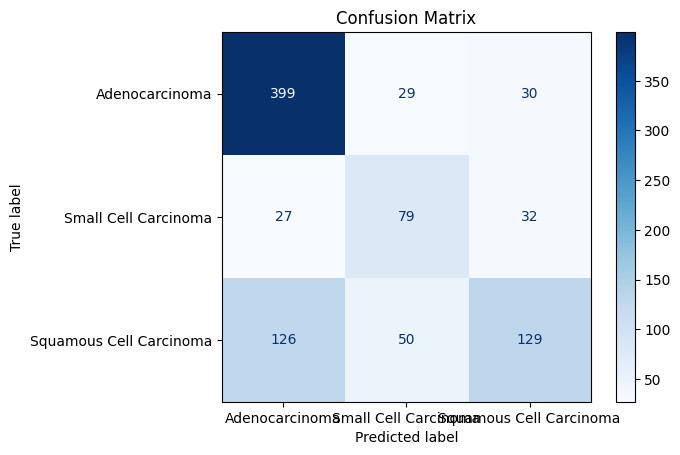

In [24]:
Model_evaluate(DenseNet_Model,valid_dataloader)

Test Accuracy: 0.5298
Test Precision: 0.3901
Test Recall: 0.4438
Test F1 Score: 0.3961
Test Sensitivity: 0.4438


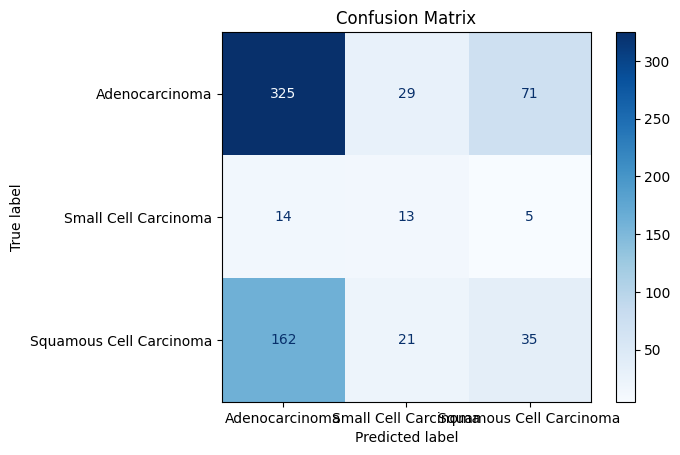

In [25]:
Model_evaluate(DenseNet_Model,test_dataloader)

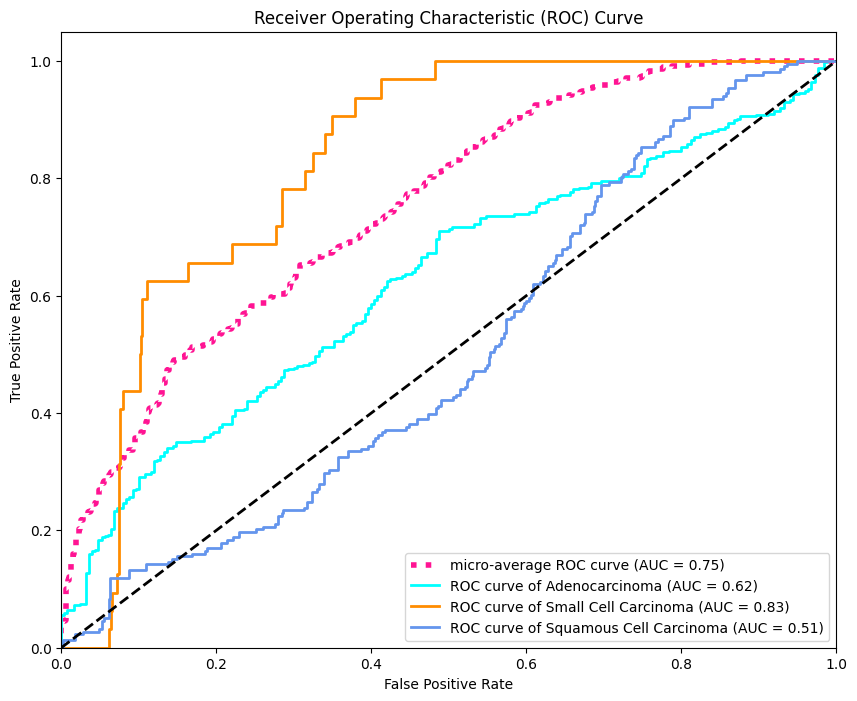

AUC Scores:
Adenocarcinoma: 0.6243
Small Cell Carcinoma: 0.8289
Squamous Cell Carcinoma: 0.5052
Micro-average: 0.7522


In [26]:
plot_roc_auc(DenseNet_Model,test_dataloader,device)

## ResNet101

In [28]:
class ResNet(torch.nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.resnet(x)


ResNet_Model = ResNet(num_classes=3)
device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ResNet_Model.parameters(),
                             lr=1e-3)

scheduler = ExponentialLR(optimizer, gamma=0.9)

ResNet_Model = ResNet_Model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

ResNet_Model_results = train(model=ResNet_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,
                            scheduler=scheduler)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|▉                                           | 1/50 [01:00<49:08, 60.18s/it]


Epoch 1, Training Loss: 3.5268, Training Accuracy: 0.6327, Training Precision: 0.6134, Training Recall: 0.6248, Training F1: 0.6128, Test Loss: 1.5140, Test Accuracy: 0.4591, Test Precision: 0.4885, Test Recall: 0.5060, Test F1: 0.4281, Test Sensitivity: 0.5060


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|█▊                                          | 2/50 [02:03<49:30, 61.89s/it]


Epoch 2, Training Loss: 1.8091, Training Accuracy: 0.7800, Training Precision: 0.7753, Training Recall: 0.7793, Training F1: 0.7761, Test Loss: 1.7193, Test Accuracy: 0.3933, Test Precision: 0.2572, Test Recall: 0.3036, Test F1: 0.2785, Test Sensitivity: 0.3036


  6%|██▋                                         | 3/50 [03:09<49:51, 63.65s/it]


Epoch 3, Training Loss: 1.3643, Training Accuracy: 0.8780, Training Precision: 0.8769, Training Recall: 0.8770, Training F1: 0.8770, Test Loss: 3.0468, Test Accuracy: 0.4634, Test Precision: 0.4209, Test Recall: 0.3667, Test F1: 0.3405, Test Sensitivity: 0.3667


  6%|██▌                                       | 3/50 [04:14<1:06:29, 84.88s/it]

Early stopping at epoch 4


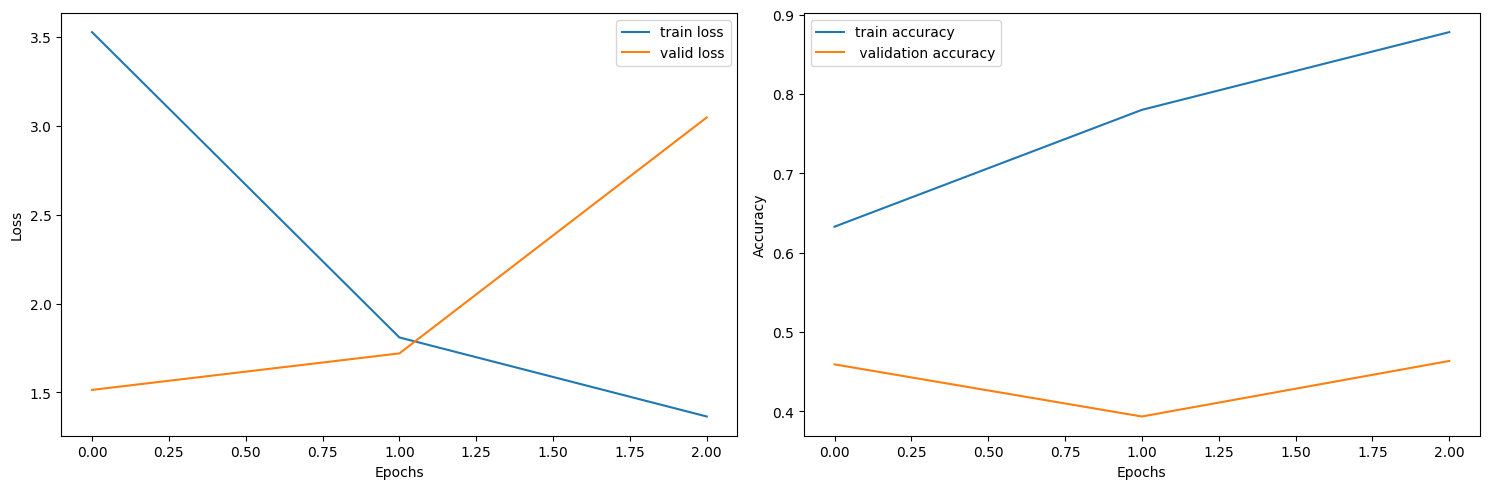

In [29]:
loss_and_acc_plots(ResNet_Model_results,True)

In [31]:
ResNet_Model.load_state_dict(torch.load('best_models/Pre-Processed/ResNet101/best_model.pth'))

<All keys matched successfully>

Test Accuracy: 0.6165
Test Precision: 0.6130
Test Recall: 0.5988
Test F1 Score: 0.5593
Test Sensitivity: 0.5988


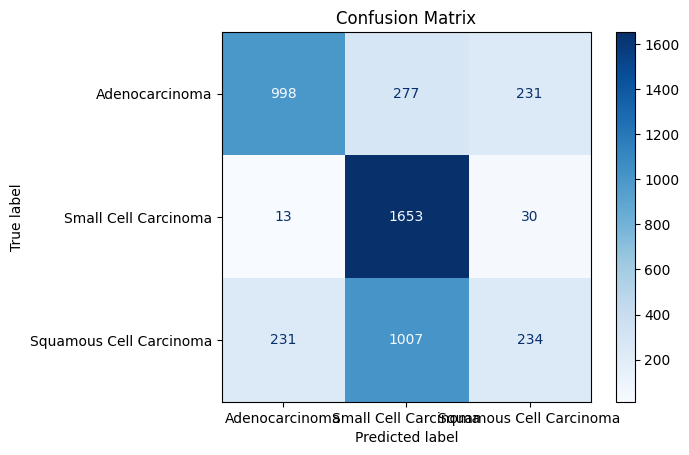

In [32]:
Model_evaluate(ResNet_Model, train_dataloader,device=device)

Test Accuracy: 0.4591
Test Precision: 0.4885
Test Recall: 0.5060
Test F1 Score: 0.4281
Test Sensitivity: 0.5060


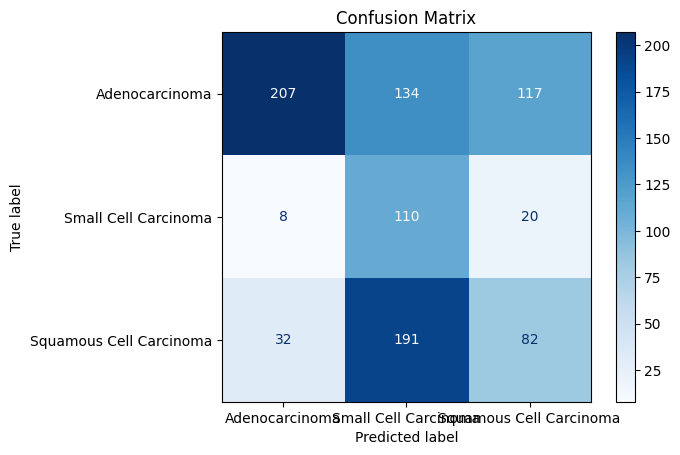

In [33]:
Model_evaluate(ResNet_Model, valid_dataloader,device=device)

Test Accuracy: 0.4034
Test Precision: 0.3661
Test Recall: 0.4418
Test F1 Score: 0.3180
Test Sensitivity: 0.4418


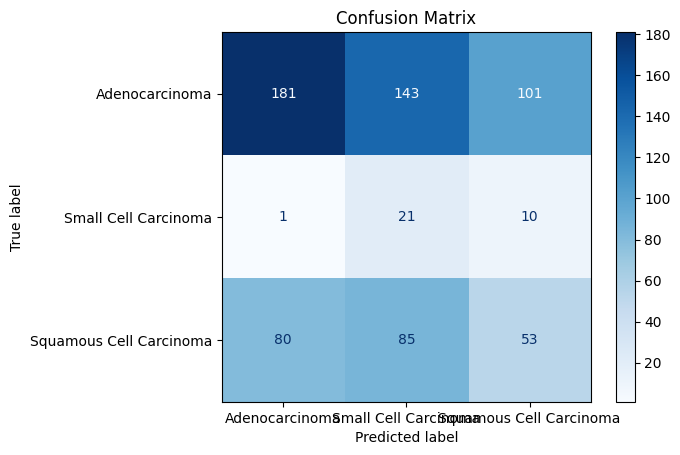

In [34]:
Model_evaluate(ResNet_Model, test_dataloader,device=device)

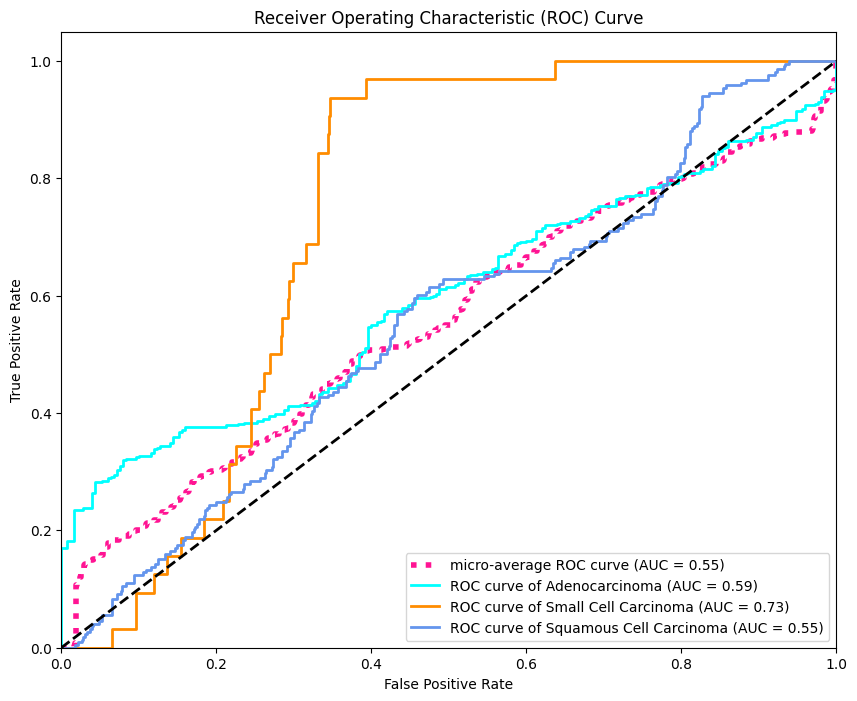

AUC Scores:
Adenocarcinoma: 0.5944
Small Cell Carcinoma: 0.7349
Squamous Cell Carcinoma: 0.5493
Micro-average: 0.5535


In [35]:
plot_roc_auc(ResNet_Model, test_dataloader,device)

## ViT S16

In [45]:
# Model Class
class ViT_S16(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.vits16= create_model('vit_small_patch16_224', pretrained=True)
        self.vits16.head = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self,x):
        return self.vits16(x)
# Clean GPU Memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()
   
vit_s16_model = ViT_S16(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Optimizer
optimizer = torch.optim.Adam(params=vit_s16_model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

vit_s8_model = vit_s16_model.to(device)
# Learning Rate scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)
# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

vit_s16_model_results = train(model=vit_s16_model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,patience=5,scheduler=scheduler, early_stopping=True,use_multiple_gpus=True)

Using 3 GPUs


  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|▉                                           | 1/50 [01:03<51:37, 63.22s/it]


Epoch 1, Training Loss: 8.4076, Training Accuracy: 0.3287, Training Precision: 0.3255, Training Recall: 0.3234, Training F1: 0.3129, Test Loss: 1.0997, Test Accuracy: 0.4935, Test Precision: 0.1694, Test Recall: 0.3333, Test F1: 0.2247, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|█▊                                          | 2/50 [02:05<50:14, 62.81s/it]


Epoch 2, Training Loss: 4.3953, Training Accuracy: 0.3614, Training Precision: 0.3182, Training Recall: 0.3350, Training F1: 0.2265, Test Loss: 1.1176, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|██▋                                         | 3/50 [03:08<49:07, 62.71s/it]


Epoch 3, Training Loss: 2.8521, Training Accuracy: 0.3552, Training Precision: 0.3236, Training Recall: 0.3315, Training F1: 0.2174, Test Loss: 1.0789, Test Accuracy: 0.3578, Test Precision: 0.1128, Test Recall: 0.3333, Test F1: 0.1686, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|███▌                                        | 4/50 [04:04<46:12, 60.26s/it]


Epoch 4, Training Loss: 2.2593, Training Accuracy: 0.3472, Training Precision: 0.3315, Training Recall: 0.3313, Training F1: 0.2832, Test Loss: 1.1167, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|████▍                                       | 5/50 [05:01<44:05, 58.79s/it]


Epoch 5, Training Loss: 1.8843, Training Accuracy: 0.3569, Training Precision: 0.3343, Training Recall: 0.3344, Training F1: 0.2336, Test Loss: 1.1101, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|█████▎                                      | 6/50 [06:04<44:13, 60.30s/it]


Epoch 6, Training Loss: 1.6901, Training Accuracy: 0.3584, Training Precision: 0.3358, Training Recall: 0.3356, Training F1: 0.2610, Test Loss: 1.1213, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 14%|██████▏                                     | 7/50 [07:06<43:45, 61.06s/it]


Epoch 7, Training Loss: 1.5750, Training Accuracy: 0.3593, Training Precision: 0.3335, Training Recall: 0.3330, Training F1: 0.1906, Test Loss: 1.1110, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 14%|██████▏                                     | 7/50 [08:03<49:30, 69.09s/it]

Early stopping at epoch 8


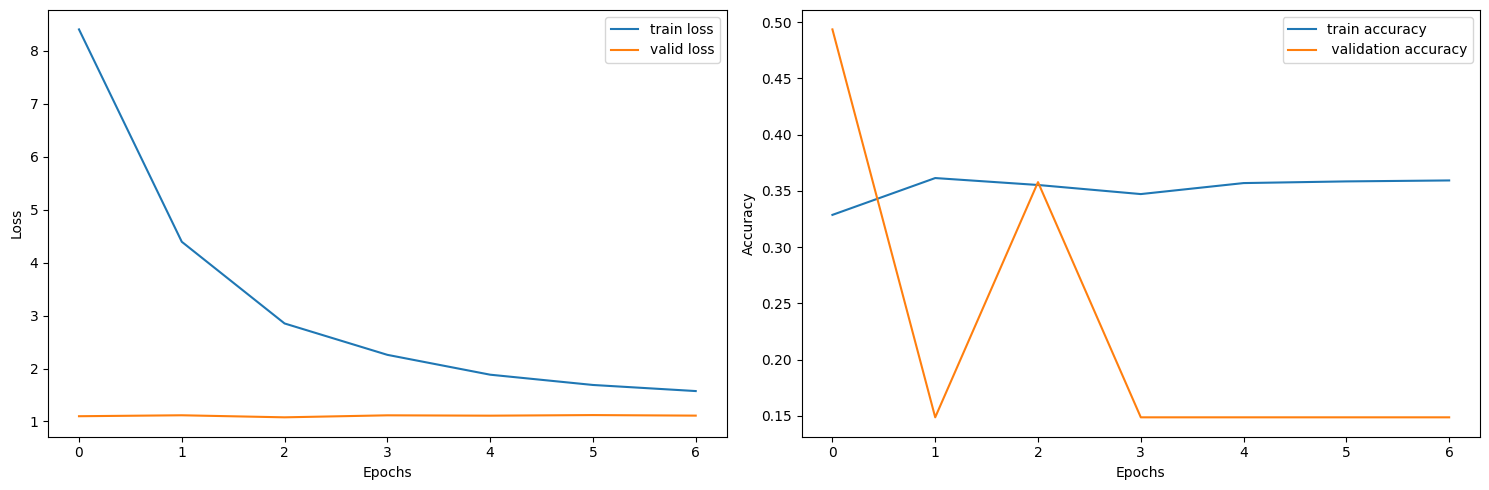

In [46]:
loss_and_acc_plots(vit_s16_model_results, save_result=True)

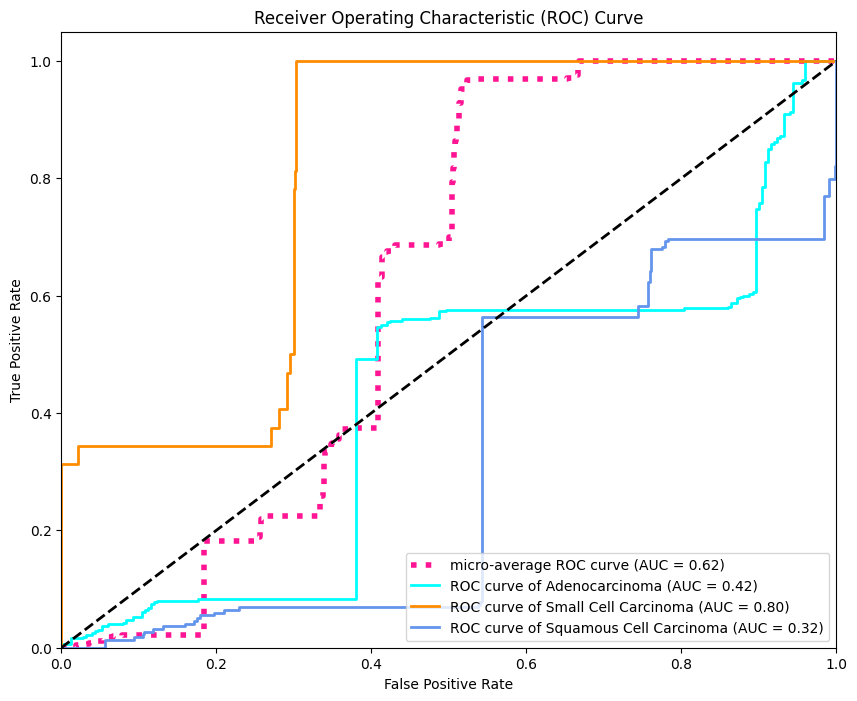

AUC Scores:
Adenocarcinoma: 0.4160
Small Cell Carcinoma: 0.8039
Squamous Cell Carcinoma: 0.3194
Micro-average: 0.6151


In [6]:
vit_s16_model.load_state_dict(state_loader_fixer(torch.load("best_models/Pre-Processed/ViT-S16/best_model.pth")))
plot_roc_auc(vit_s16_model, test_dataloader, device)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.3129
Test Precision: 0.1050
Test Recall: 0.3333
Test F1 Score: 0.1597
Test Sensitivity: 0.3333


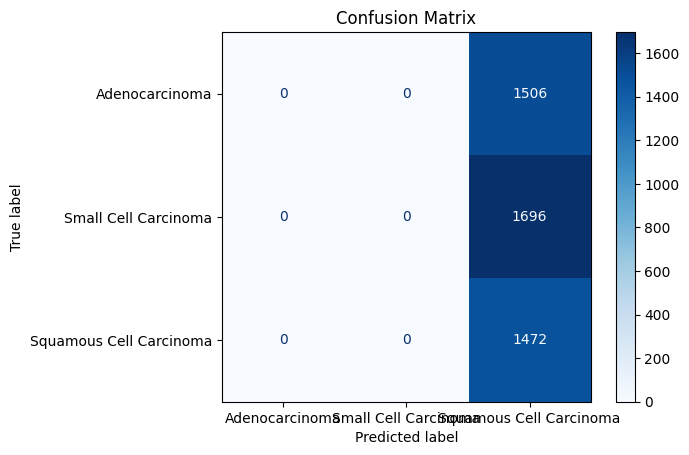

In [7]:
Model_evaluate(vit_s16_model,train_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.3578
Test Precision: 0.1128
Test Recall: 0.3333
Test F1 Score: 0.1686
Test Sensitivity: 0.3333


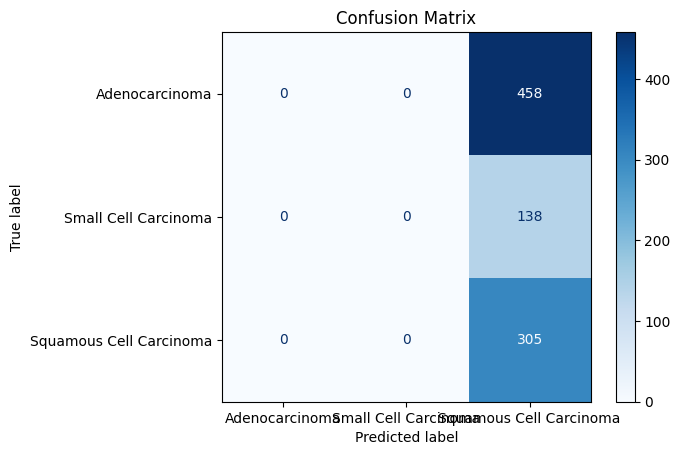

In [8]:
Model_evaluate(vit_s16_model,valid_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.3509
Test Precision: 0.1077
Test Recall: 0.3333
Test F1 Score: 0.1627
Test Sensitivity: 0.3333


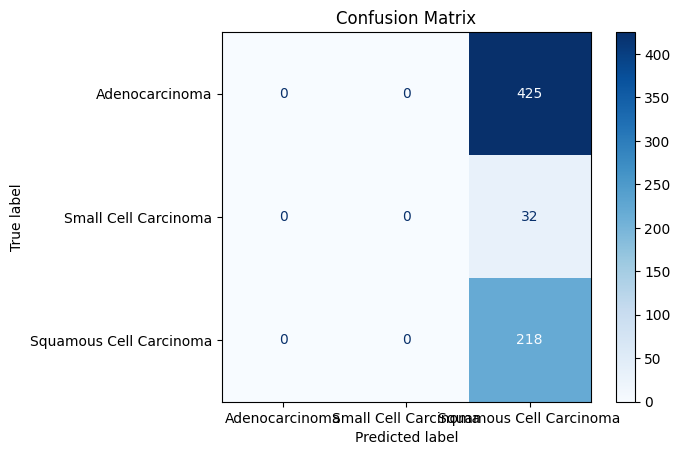

In [9]:
Model_evaluate(vit_s16_model,test_dataloader)

## ViT B8

In [3]:
class ViT_B8(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.vitb8= create_model('vit_base_patch8_224', pretrained=True)
        self.vitb8.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self,x):
        return self.vitb8(x)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()
   
vit_B8_model = ViT_B8(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=vit_B8_model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

vit_B8_model = vit_B8_model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

vit_B8_model_results = train(model=vit_B8_model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,
                             patience=5,use_multiple_gpus=True)


Using 3 GPUs


  0%|                                                                                                                     | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|██                                                                                                        | 1/50 [03:01<2:27:55, 181.13s/it]


Epoch 1, Training Loss: 8.3188, Training Accuracy: 0.3486, Training Precision: 0.3377, Training Recall: 0.3406, Training F1: 0.3261, Test Loss: 1.0716, Test Accuracy: 0.4935, Test Precision: 0.1694, Test Recall: 0.3333, Test F1: 0.2247, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|████▏                                                                                                     | 2/50 [05:57<2:22:30, 178.13s/it]


Epoch 2, Training Loss: 3.2442, Training Accuracy: 0.3559, Training Precision: 0.3465, Training Recall: 0.3430, Training F1: 0.3120, Test Loss: 1.0981, Test Accuracy: 0.3578, Test Precision: 0.1128, Test Recall: 0.3333, Test F1: 0.1686, Test Sensitivity: 0.3333


  6%|██████▎                                                                                                   | 3/50 [08:49<2:17:25, 175.45s/it]


Epoch 3, Training Loss: 2.6119, Training Accuracy: 0.4539, Training Precision: 0.4300, Training Recall: 0.4486, Training F1: 0.4090, Test Loss: 1.0811, Test Accuracy: 0.4817, Test Precision: 0.4405, Test Recall: 0.3286, Test F1: 0.2389, Test Sensitivity: 0.3286


  8%|████████▍                                                                                                 | 4/50 [11:51<2:16:37, 178.22s/it]


Epoch 4, Training Loss: 2.2992, Training Accuracy: 0.5497, Training Precision: 0.4934, Training Recall: 0.5411, Training F1: 0.4517, Test Loss: 1.0338, Test Accuracy: 0.4871, Test Precision: 0.1683, Test Recall: 0.3290, Test F1: 0.2227, Test Sensitivity: 0.3290


 10%|██████████▌                                                                                               | 5/50 [14:47<2:12:54, 177.21s/it]


Epoch 5, Training Loss: 2.1247, Training Accuracy: 0.5891, Training Precision: 0.5061, Training Recall: 0.5763, Training F1: 0.4785, Test Loss: 1.1360, Test Accuracy: 0.4181, Test Precision: 0.3291, Test Recall: 0.2828, Test F1: 0.2082, Test Sensitivity: 0.2828


 12%|████████████▋                                                                                             | 6/50 [17:37<2:08:19, 174.98s/it]


Epoch 6, Training Loss: 2.0820, Training Accuracy: 0.6201, Training Precision: 0.5553, Training Recall: 0.6040, Training F1: 0.5129, Test Loss: 1.3580, Test Accuracy: 0.4515, Test Precision: 0.3917, Test Recall: 0.3064, Test F1: 0.2257, Test Sensitivity: 0.3064


 14%|██████████████▊                                                                                           | 7/50 [20:33<2:05:35, 175.24s/it]


Epoch 7, Training Loss: 1.8844, Training Accuracy: 0.6443, Training Precision: 0.5483, Training Recall: 0.6260, Training F1: 0.5203, Test Loss: 1.3984, Test Accuracy: 0.4526, Test Precision: 0.1689, Test Recall: 0.3057, Test F1: 0.2176, Test Sensitivity: 0.3057


 16%|████████████████▉                                                                                         | 8/50 [23:28<2:02:27, 174.95s/it]


Epoch 8, Training Loss: 1.7940, Training Accuracy: 0.6603, Training Precision: 0.6347, Training Recall: 0.6481, Training F1: 0.5825, Test Loss: 1.2564, Test Accuracy: 0.4537, Test Precision: 0.3404, Test Recall: 0.3203, Test F1: 0.2758, Test Sensitivity: 0.3203


 16%|████████████████▉                                                                                         | 8/50 [26:25<2:18:45, 198.22s/it]

Early stopping at epoch 9


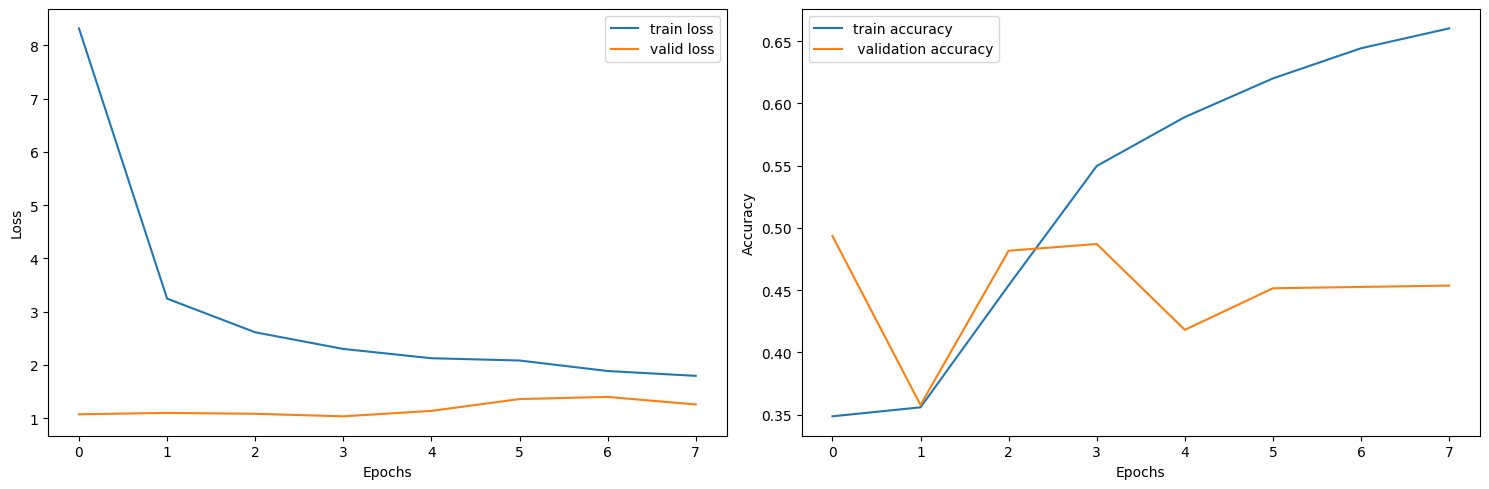

In [4]:
loss_and_acc_plots(vit_B8_model_results, save_result=True)

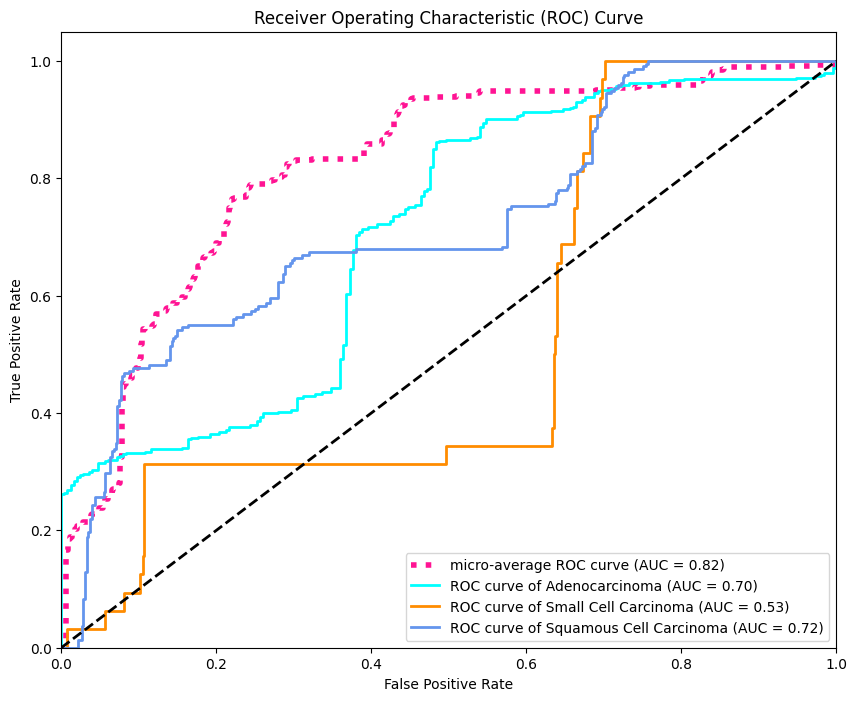

AUC Scores:
Adenocarcinoma: 0.7039
Small Cell Carcinoma: 0.5254
Squamous Cell Carcinoma: 0.7176
Micro-average: 0.8209


In [7]:
vit_B8_model.load_state_dict(state_loader_fixer(torch.load("/home/aa23798/Lung_Cancer/best_models/Pre-Processed/ViT-B8/best_model.pth")))
plot_roc_auc(vit_B8_model, test_dataloader, device)

Test Accuracy: 0.5712
Test Precision: 0.5758
Test Recall: 0.5655
Test F1 Score: 0.4617
Test Sensitivity: 0.5655


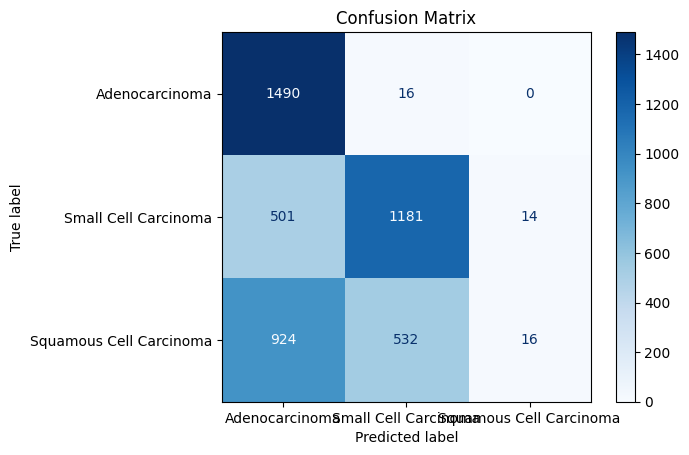

In [8]:
Model_evaluate(vit_B8_model,train_dataloader)

Test Accuracy: 0.4871
Test Precision: 0.1683
Test Recall: 0.3290
Test F1 Score: 0.2227
Test Sensitivity: 0.3290


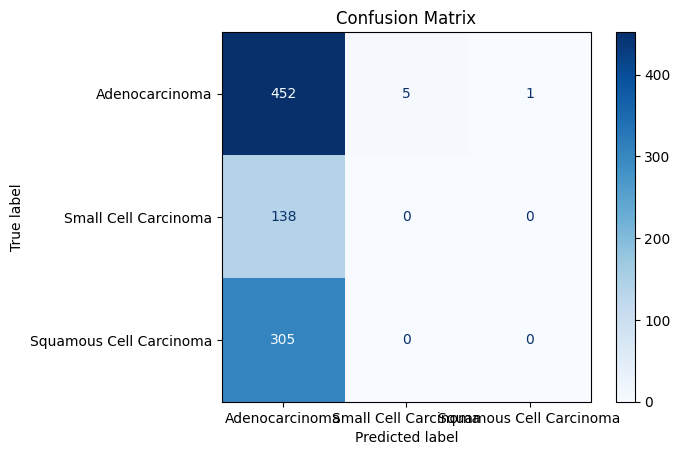

In [9]:
Model_evaluate(vit_B8_model,valid_dataloader)

Test Accuracy: 0.6009
Test Precision: 0.5459
Test Recall: 0.3681
Test F1 Score: 0.3165
Test Sensitivity: 0.3681


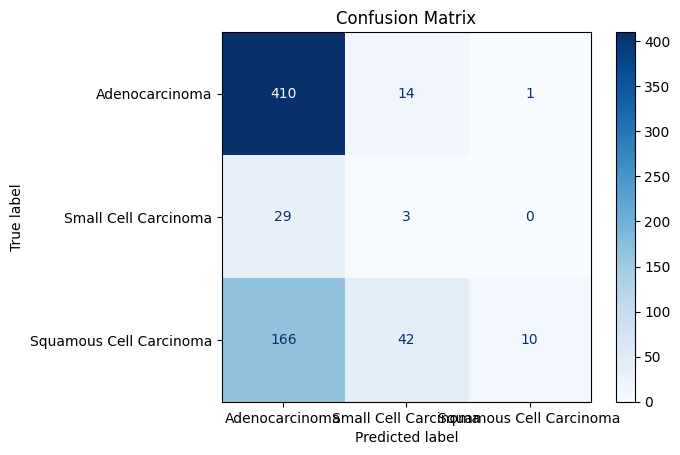

In [10]:
Model_evaluate(vit_B8_model,test_dataloader)

## ViT B16 

In [11]:
class ViT_B16(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.vitb16= create_model('vit_base_patch16_224', pretrained=True)
        self.vitb16.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self,x):
        return self.vitb16(x)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()
   
ViT_B16_model = ViT_B16(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ViT_B16_model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

ViT_B16_model = ViT_B16_model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

ViT_B16_model_results = train(model=ViT_B16_model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,
                            patience=5,use_multiple_gpus=True)


Using 3 GPUs


  0%|                                                                                                                     | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|██▏                                                                                                        | 1/50 [01:30<1:14:06, 90.74s/it]


Epoch 1, Training Loss: 9.4144, Training Accuracy: 0.3410, Training Precision: 0.3364, Training Recall: 0.3348, Training F1: 0.3321, Test Loss: 1.0943, Test Accuracy: 0.4903, Test Precision: 0.1689, Test Recall: 0.3311, Test F1: 0.2237, Test Sensitivity: 0.3311


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|████▎                                                                                                      | 2/50 [02:59<1:11:26, 89.30s/it]


Epoch 2, Training Loss: 3.8898, Training Accuracy: 0.3559, Training Precision: 0.3480, Training Recall: 0.3487, Training F1: 0.3435, Test Loss: 1.1222, Test Accuracy: 0.3459, Test Precision: 0.2141, Test Recall: 0.3332, Test F1: 0.2537, Test Sensitivity: 0.3332


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|██████▍                                                                                                    | 3/50 [04:27<1:09:43, 89.01s/it]


Epoch 3, Training Loss: 2.8921, Training Accuracy: 0.4418, Training Precision: 0.4242, Training Recall: 0.4376, Training F1: 0.4156, Test Loss: 1.1556, Test Accuracy: 0.3578, Test Precision: 0.2327, Test Recall: 0.2745, Test F1: 0.2519, Test Sensitivity: 0.2745


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|████████▌                                                                                                  | 4/50 [05:55<1:07:48, 88.44s/it]


Epoch 4, Training Loss: 2.5021, Training Accuracy: 0.4662, Training Precision: 0.4364, Training Recall: 0.4520, Training F1: 0.4129, Test Loss: 1.1266, Test Accuracy: 0.3276, Test Precision: 0.2711, Test Recall: 0.4541, Test F1: 0.2711, Test Sensitivity: 0.4541


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|██████████▋                                                                                                | 5/50 [07:22<1:05:52, 87.84s/it]


Epoch 5, Training Loss: 2.2516, Training Accuracy: 0.4934, Training Precision: 0.4614, Training Recall: 0.4789, Training F1: 0.4422, Test Loss: 1.1915, Test Accuracy: 0.3858, Test Precision: 0.1962, Test Recall: 0.2977, Test F1: 0.2365, Test Sensitivity: 0.2977


 10%|██████████▌                                                                                               | 5/50 [08:50<1:19:34, 106.10s/it]

Early stopping at epoch 6


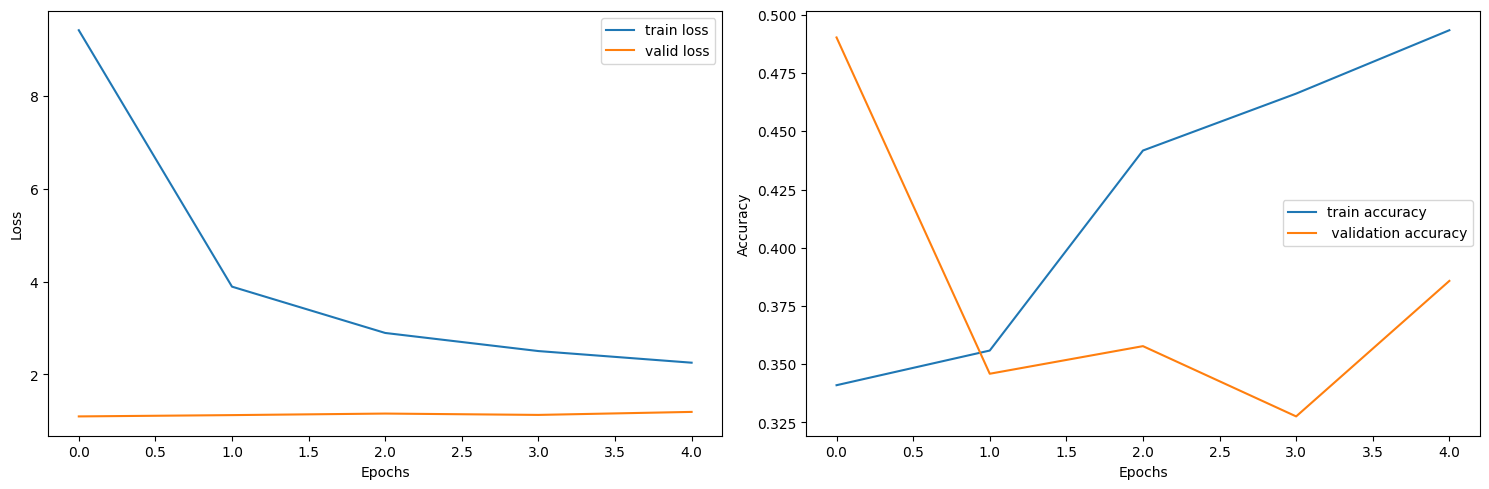

In [12]:
loss_and_acc_plots(ViT_B16_model_results, save_result=True)

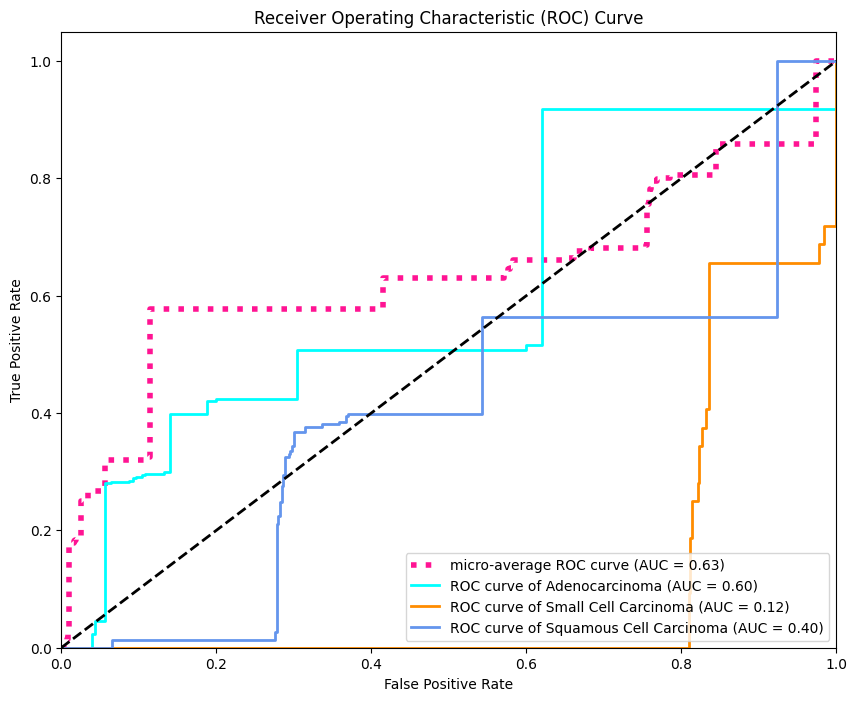

AUC Scores:
Adenocarcinoma: 0.6026
Small Cell Carcinoma: 0.1168
Squamous Cell Carcinoma: 0.3961
Micro-average: 0.6333


In [13]:
ViT_B16_model.load_state_dict(state_loader_fixer(torch.load("/home/aa23798/Lung_Cancer/best_models/Pre-Processed/ViT-B16/best_model.pth")))
plot_roc_auc(ViT_B16_model, test_dataloader, device)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.3705
Test Precision: 0.3054
Test Recall: 0.3797
Test F1 Score: 0.2507
Test Sensitivity: 0.3797


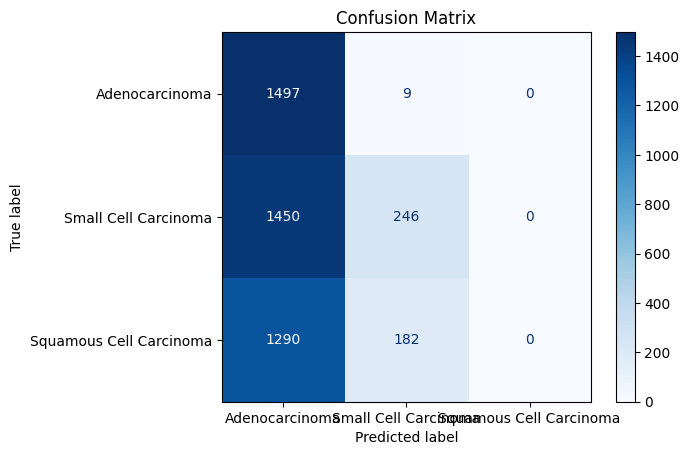

In [14]:
Model_evaluate(ViT_B16_model,train_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.4903
Test Precision: 0.1689
Test Recall: 0.3311
Test F1 Score: 0.2237
Test Sensitivity: 0.3311


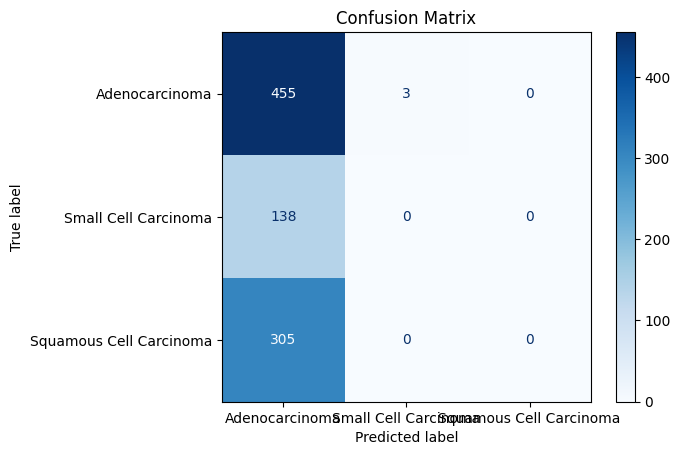

In [15]:
Model_evaluate(ViT_B16_model,valid_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.5540
Test Precision: 0.2334
Test Recall: 0.3059
Test F1 Score: 0.2648
Test Sensitivity: 0.3059


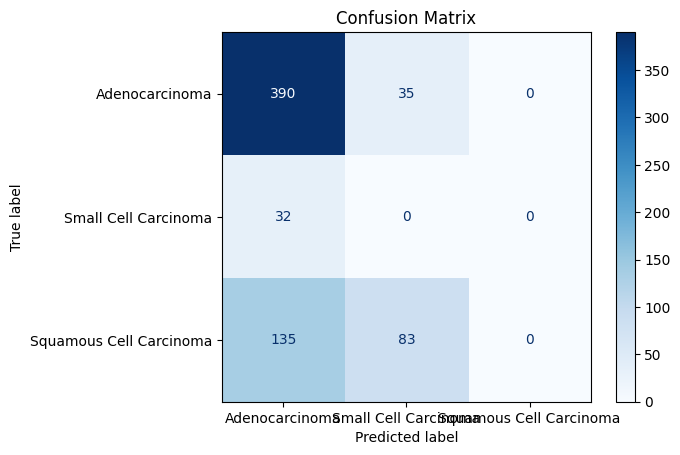

In [16]:
Model_evaluate(ViT_B16_model,test_dataloader)

## ViT S16 Dino

In [17]:
class ViTS16_Dino(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.Dino = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
        self.head = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        features = self.Dino(x)
        return self.head(features)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()

ViTS16_Dino_Model = ViTS16_Dino(3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ViTS16_Dino_Model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

ViTS16_Dino_Model = ViTS16_Dino_Model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

ViTS16_Dino_results = train(model=ViTS16_Dino_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,
                            patience=5,use_multiple_gpus=True)

Using cache found in /home/aa23798/.cache/torch/hub/facebookresearch_dino_main


Using 3 GPUs


  0%|                                                                                                                     | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|██▏                                                                                                          | 1/50 [01:04<52:37, 64.43s/it]


Epoch 1, Training Loss: 3.3012, Training Accuracy: 0.3550, Training Precision: 0.3384, Training Recall: 0.3385, Training F1: 0.3178, Test Loss: 1.1231, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|████▎                                                                                                        | 2/50 [02:08<51:23, 64.24s/it]


Epoch 2, Training Loss: 2.4941, Training Accuracy: 0.3605, Training Precision: 0.1210, Training Recall: 0.3333, Training F1: 0.1775, Test Loss: 1.1240, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|██████▌                                                                                                      | 3/50 [03:11<49:43, 63.47s/it]


Epoch 3, Training Loss: 2.1348, Training Accuracy: 0.3665, Training Precision: 0.3515, Training Recall: 0.3356, Training F1: 0.2140, Test Loss: 1.1587, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|████████▋                                                                                                    | 4/50 [04:10<47:19, 61.74s/it]


Epoch 4, Training Loss: 1.9558, Training Accuracy: 0.3612, Training Precision: 0.3516, Training Recall: 0.3364, Training F1: 0.2113, Test Loss: 1.1348, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|██████████▉                                                                                                  | 5/50 [05:10<45:53, 61.18s/it]


Epoch 5, Training Loss: 1.8560, Training Accuracy: 0.3648, Training Precision: 0.3207, Training Recall: 0.3333, Training F1: 0.2055, Test Loss: 1.2001, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|█████████████                                                                                                | 6/50 [06:11<44:47, 61.08s/it]


Epoch 6, Training Loss: 1.7815, Training Accuracy: 0.3631, Training Precision: 0.3300, Training Recall: 0.3335, Training F1: 0.1879, Test Loss: 1.1217, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 14%|███████████████▎                                                                                             | 7/50 [07:08<42:57, 59.94s/it]


Epoch 7, Training Loss: 1.7298, Training Accuracy: 0.3605, Training Precision: 0.1210, Training Recall: 0.3333, Training F1: 0.1775, Test Loss: 1.1222, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 16%|█████████████████▍                                                                                           | 8/50 [08:10<42:15, 60.37s/it]


Epoch 8, Training Loss: 1.6956, Training Accuracy: 0.3614, Training Precision: 0.3709, Training Recall: 0.3358, Training F1: 0.2019, Test Loss: 1.1154, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 18%|███████████████████▌                                                                                         | 9/50 [09:12<41:35, 60.86s/it]


Epoch 9, Training Loss: 1.6673, Training Accuracy: 0.3693, Training Precision: 0.3539, Training Recall: 0.3388, Training F1: 0.2246, Test Loss: 1.1230, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|█████████████████████▌                                                                                      | 10/50 [10:14<40:57, 61.44s/it]


Epoch 10, Training Loss: 1.6451, Training Accuracy: 0.3637, Training Precision: 0.1210, Training Recall: 0.3333, Training F1: 0.1775, Test Loss: 1.1245, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 22%|███████████████████████▊                                                                                    | 11/50 [11:13<39:24, 60.64s/it]


Epoch 11, Training Loss: 1.6265, Training Accuracy: 0.3637, Training Precision: 0.1210, Training Recall: 0.3333, Training F1: 0.1775, Test Loss: 1.1238, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 24%|█████████████████████████▉                                                                                  | 12/50 [12:15<38:42, 61.11s/it]


Epoch 12, Training Loss: 1.6376, Training Accuracy: 0.3597, Training Precision: 0.3342, Training Recall: 0.3349, Training F1: 0.2425, Test Loss: 1.0900, Test Accuracy: 0.4935, Test Precision: 0.1694, Test Recall: 0.3333, Test F1: 0.2247, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 26%|████████████████████████████                                                                                | 13/50 [13:17<37:48, 61.32s/it]


Epoch 13, Training Loss: 1.6349, Training Accuracy: 0.3542, Training Precision: 0.3304, Training Recall: 0.3340, Training F1: 0.2552, Test Loss: 1.1225, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 28%|██████████████████████████████▏                                                                             | 14/50 [14:18<36:44, 61.23s/it]


Epoch 14, Training Loss: 1.5943, Training Accuracy: 0.3601, Training Precision: 0.3176, Training Recall: 0.3310, Training F1: 0.1908, Test Loss: 1.1226, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 30%|████████████████████████████████▍                                                                           | 15/50 [15:16<35:06, 60.19s/it]


Epoch 15, Training Loss: 1.5777, Training Accuracy: 0.3637, Training Precision: 0.1210, Training Recall: 0.3333, Training F1: 0.1775, Test Loss: 1.1228, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 32%|██████████████████████████████████▌                                                                         | 16/50 [16:16<34:09, 60.28s/it]


Epoch 16, Training Loss: 1.5783, Training Accuracy: 0.3537, Training Precision: 0.3187, Training Recall: 0.3295, Training F1: 0.2102, Test Loss: 1.1197, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 32%|██████████████████████████████████▌                                                                         | 16/50 [17:17<36:44, 64.84s/it]

Early stopping at epoch 17


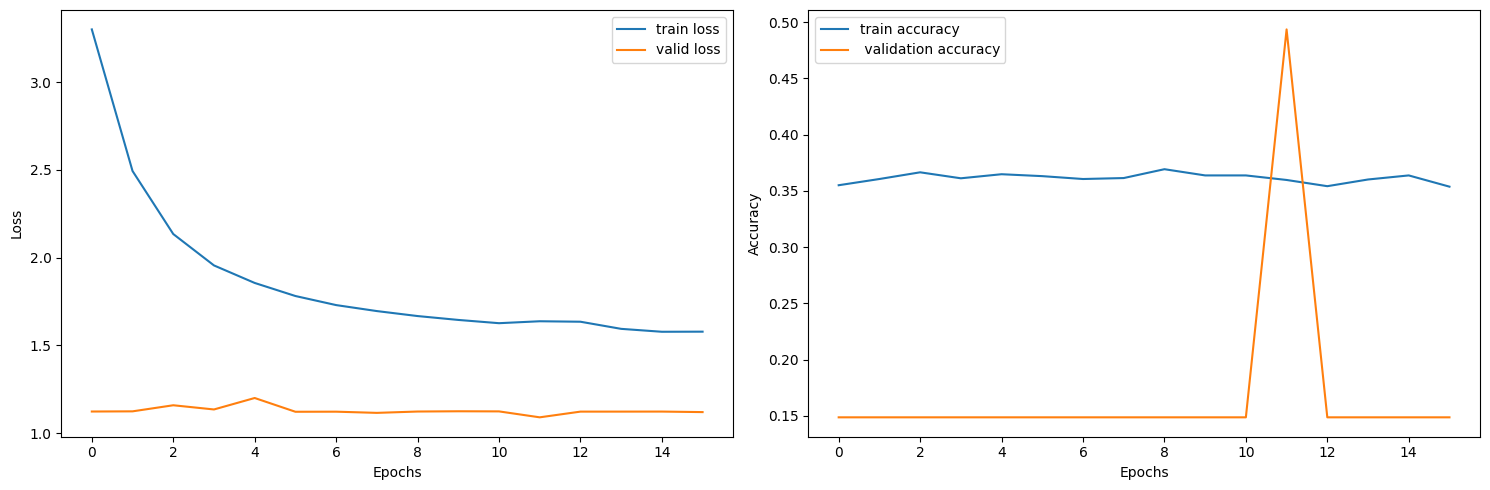

In [18]:
loss_and_acc_plots(ViTS16_Dino_results, save_result=True)

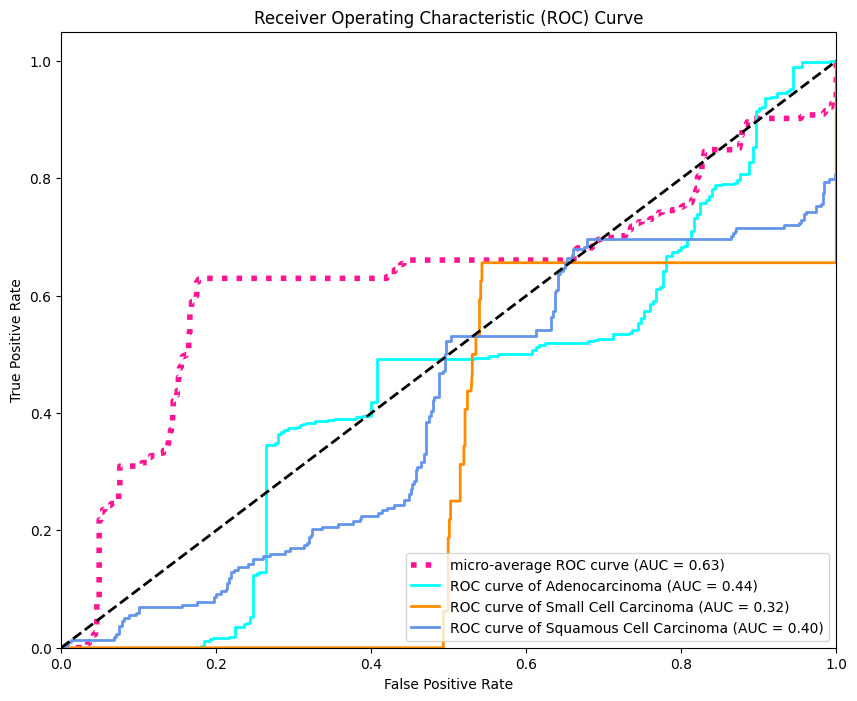

AUC Scores:
Adenocarcinoma: 0.4384
Small Cell Carcinoma: 0.3169
Squamous Cell Carcinoma: 0.4045
Micro-average: 0.6316


In [19]:
ViTS16_Dino_Model.load_state_dict(state_loader_fixer(torch.load("best_models/Pre-Processed/ViT-S16 Dino/best_model.pth")))
plot_roc_auc(ViTS16_Dino_Model, test_dataloader, device)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.3233
Test Precision: 0.1074
Test Recall: 0.3333
Test F1 Score: 0.1625
Test Sensitivity: 0.3333


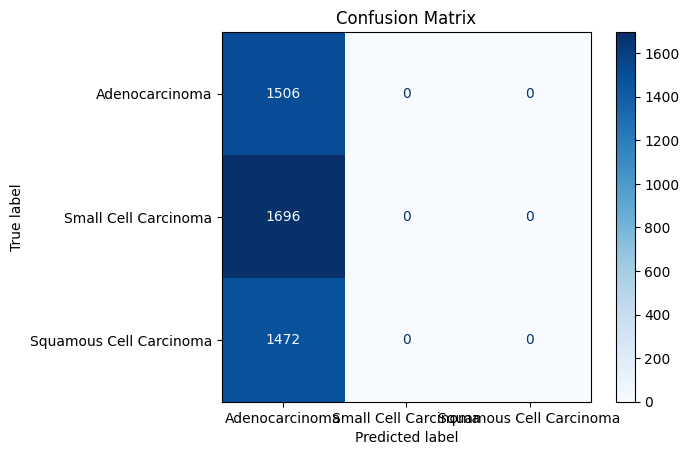

In [20]:
Model_evaluate(ViTS16_Dino_Model,train_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.4935
Test Precision: 0.1694
Test Recall: 0.3333
Test F1 Score: 0.2247
Test Sensitivity: 0.3333


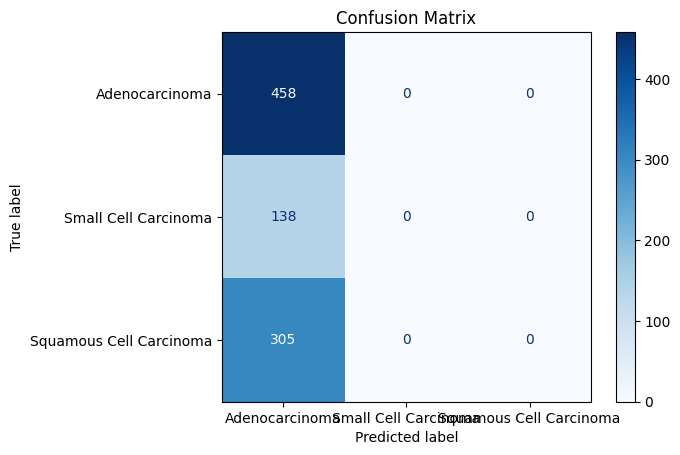

In [21]:
Model_evaluate(ViTS16_Dino_Model,valid_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.6037
Test Precision: 0.2099
Test Recall: 0.3333
Test F1 Score: 0.2576
Test Sensitivity: 0.3333


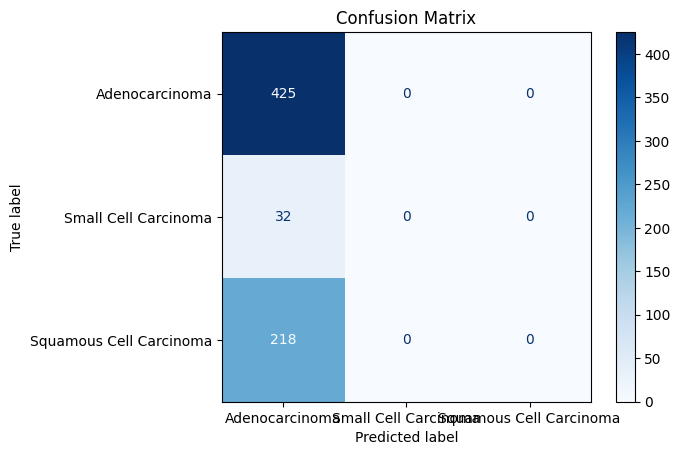

In [22]:
Model_evaluate(ViTS16_Dino_Model,test_dataloader)

## ViT B8 Dino

In [24]:
class ViTB8_Dino(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.Dino = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')
        self.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        features = self.Dino(x)
        return self.head(features)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()

ViTB8_Dino_Model = ViTB8_Dino(3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ViTB8_Dino_Model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

ViTB8_Dino_Model = ViTB8_Dino_Model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

ViTB8_Dino_Model_results = train(model=ViTB8_Dino_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,
                            patience=5,use_multiple_gpus=True)


Using cache found in /home/aa23798/.cache/torch/hub/facebookresearch_dino_main


Using 3 GPUs


  0%|                                                                                                                     | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|██                                                                                                        | 1/50 [03:17<2:41:36, 197.90s/it]


Epoch 1, Training Loss: 6.3579, Training Accuracy: 0.3408, Training Precision: 0.3290, Training Recall: 0.3292, Training F1: 0.3113, Test Loss: 1.1128, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|████▏                                                                                                     | 2/50 [06:35<2:38:15, 197.81s/it]


Epoch 2, Training Loss: 2.9683, Training Accuracy: 0.3478, Training Precision: 0.3137, Training Recall: 0.3280, Training F1: 0.2509, Test Loss: 1.1040, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|██████▎                                                                                                   | 3/50 [09:56<2:35:56, 199.08s/it]


Epoch 3, Training Loss: 2.4487, Training Accuracy: 0.3557, Training Precision: 0.3102, Training Recall: 0.3306, Training F1: 0.2012, Test Loss: 1.1213, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|████████▍                                                                                                 | 4/50 [13:12<2:31:41, 197.87s/it]


Epoch 4, Training Loss: 2.3082, Training Accuracy: 0.3627, Training Precision: 0.3433, Training Recall: 0.3362, Training F1: 0.2296, Test Loss: 1.1235, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|██████████▌                                                                                               | 5/50 [16:21<2:25:57, 194.61s/it]


Epoch 5, Training Loss: 2.1779, Training Accuracy: 0.3637, Training Precision: 0.1210, Training Recall: 0.3333, Training F1: 0.1775, Test Loss: 1.1180, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|████████████▋                                                                                             | 6/50 [19:34<2:22:29, 194.31s/it]


Epoch 6, Training Loss: 2.1784, Training Accuracy: 0.3580, Training Precision: 0.3374, Training Recall: 0.3363, Training F1: 0.2711, Test Loss: 1.1445, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|████████████▋                                                                                             | 6/50 [22:41<2:46:24, 226.93s/it]

Early stopping at epoch 7


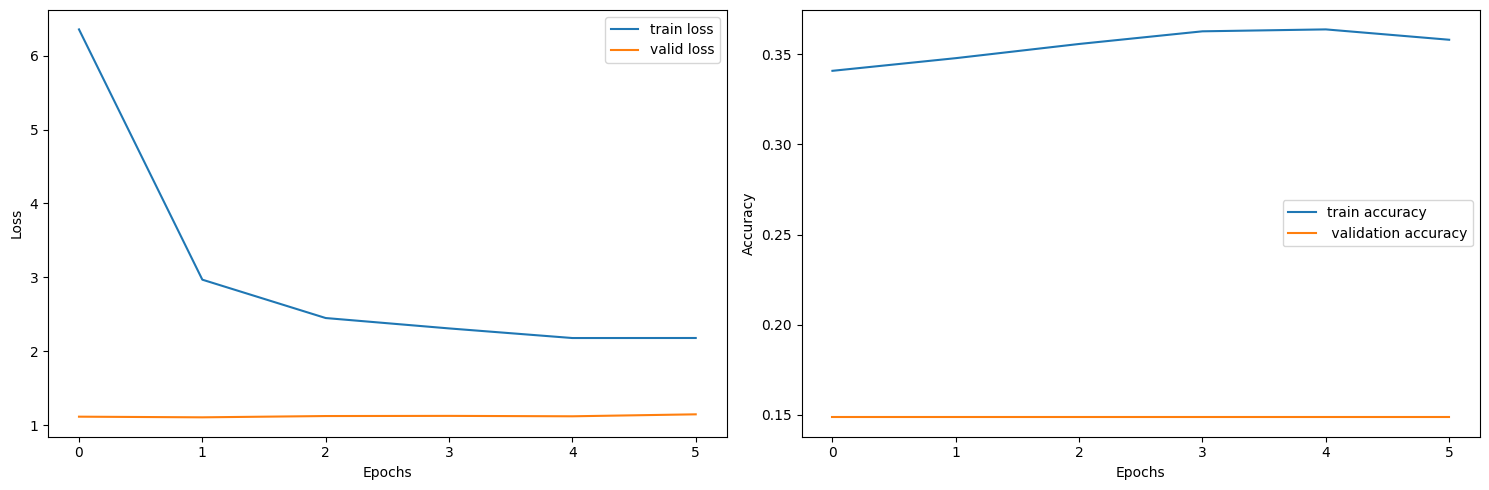

In [25]:
loss_and_acc_plots(ViTB8_Dino_Model_results, save_result=True)

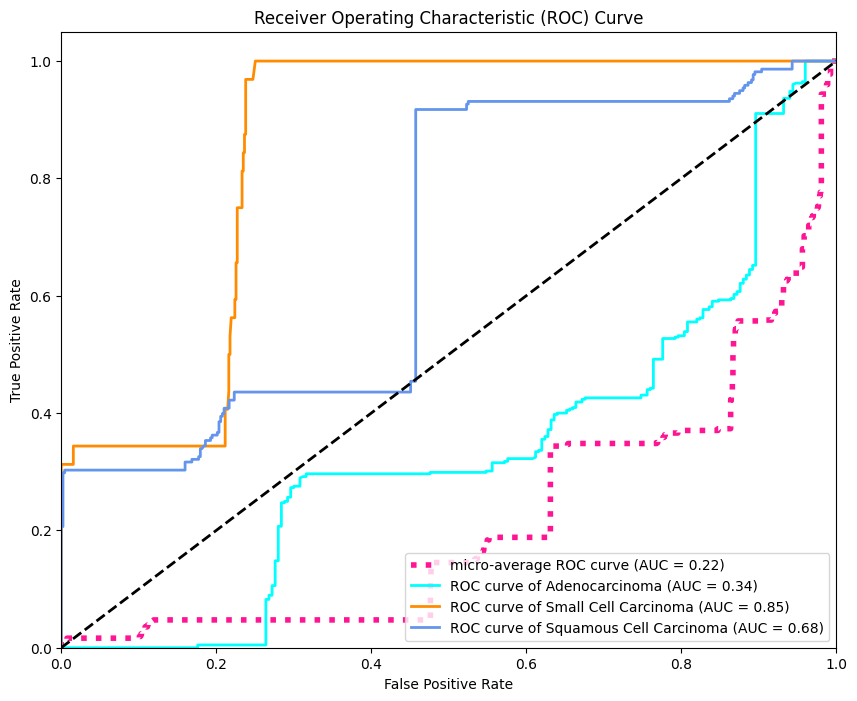

AUC Scores:
Adenocarcinoma: 0.3380
Small Cell Carcinoma: 0.8507
Squamous Cell Carcinoma: 0.6848
Micro-average: 0.2181


In [26]:
ViTB8_Dino_Model.load_state_dict(state_loader_fixer(torch.load("best_models/Pre-Processed/ViT-B8 Dino/best_model.pth")))
plot_roc_auc(ViTB8_Dino_Model, test_dataloader, device)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.3637
Test Precision: 0.1210
Test Recall: 0.3333
Test F1 Score: 0.1775
Test Sensitivity: 0.3333


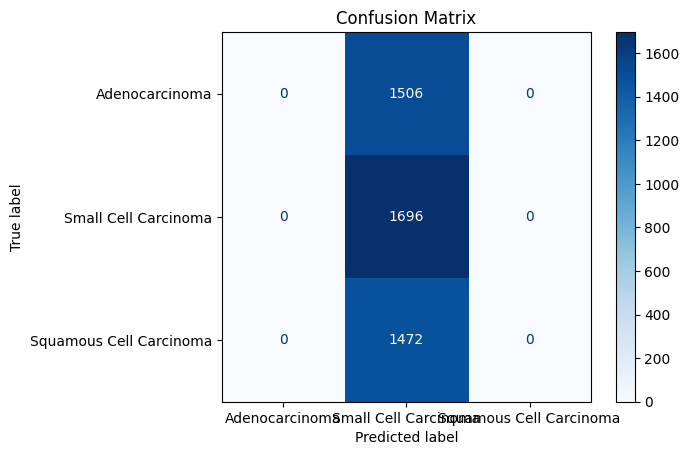

In [27]:
Model_evaluate(ViTB8_Dino_Model,train_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.1487
Test Precision: 0.0511
Test Recall: 0.3333
Test F1 Score: 0.0885
Test Sensitivity: 0.3333


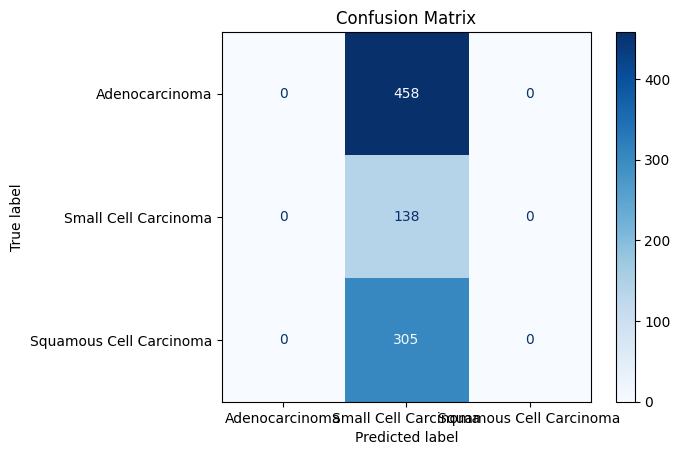

In [28]:
Model_evaluate(ViTB8_Dino_Model,valid_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.0455
Test Precision: 0.0158
Test Recall: 0.3333
Test F1 Score: 0.0302
Test Sensitivity: 0.3333


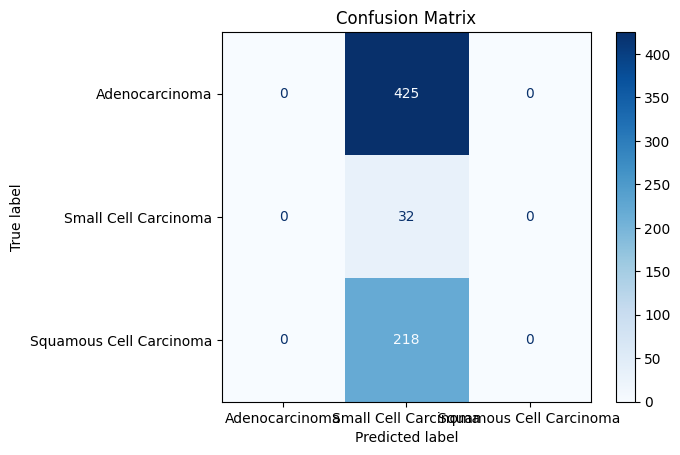

In [29]:
Model_evaluate(ViTB8_Dino_Model,test_dataloader)

## ViT B16 Dino

In [31]:
class ViTB16_Dino(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.Dino = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
        self.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        features = self.Dino(x)
        return self.head(features)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()

ViTB16_Dino_Model = ViTB16_Dino(3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ViTB16_Dino_Model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

ViTB16_Dino_Model = ViTB16_Dino_Model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

ViTB16_Dino_Model_results = train(model=ViTB16_Dino_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,
                            patience=5,use_multiple_gpus=True)


Using cache found in /home/aa23798/.cache/torch/hub/facebookresearch_dino_main


Using 3 GPUs


  0%|                                                                                                                     | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|██▏                                                                                                        | 1/50 [01:34<1:17:00, 94.29s/it]


Epoch 1, Training Loss: 6.3266, Training Accuracy: 0.3571, Training Precision: 0.3476, Training Recall: 0.3457, Training F1: 0.3309, Test Loss: 1.1178, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|████▎                                                                                                      | 2/50 [03:05<1:13:53, 92.36s/it]


Epoch 2, Training Loss: 3.3939, Training Accuracy: 0.3669, Training Precision: 0.3631, Training Recall: 0.3452, Training F1: 0.2566, Test Loss: 1.1348, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|██████▍                                                                                                    | 3/50 [04:37<1:12:17, 92.29s/it]


Epoch 3, Training Loss: 3.0067, Training Accuracy: 0.3591, Training Precision: 0.3317, Training Recall: 0.3369, Training F1: 0.2690, Test Loss: 1.1258, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|████████▌                                                                                                  | 4/50 [06:10<1:10:52, 92.45s/it]


Epoch 4, Training Loss: 2.7927, Training Accuracy: 0.3544, Training Precision: 0.3215, Training Recall: 0.3310, Training F1: 0.2194, Test Loss: 1.1247, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|██████████▋                                                                                                | 5/50 [07:42<1:09:16, 92.36s/it]


Epoch 5, Training Loss: 2.6998, Training Accuracy: 0.3622, Training Precision: 0.3349, Training Recall: 0.3320, Training F1: 0.1782, Test Loss: 1.1224, Test Accuracy: 0.1487, Test Precision: 0.0511, Test Recall: 0.3333, Test F1: 0.0885, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|██████████▌                                                                                               | 5/50 [09:20<1:24:01, 112.03s/it]

Early stopping at epoch 6


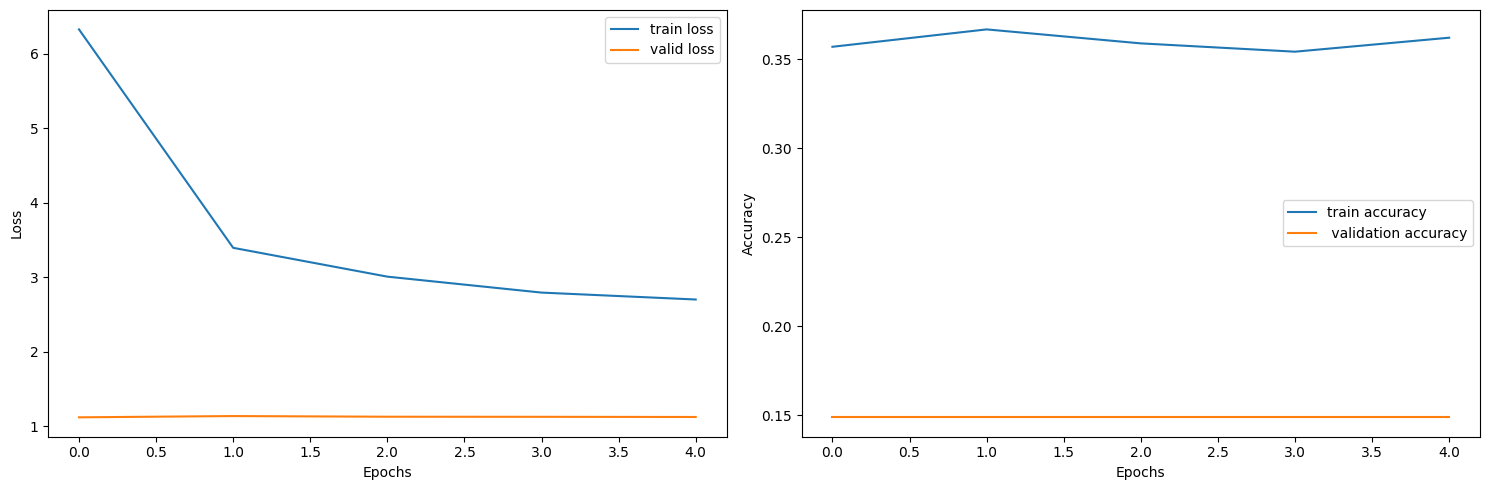

In [32]:
loss_and_acc_plots(ViTB16_Dino_Model_results, save_result=True)

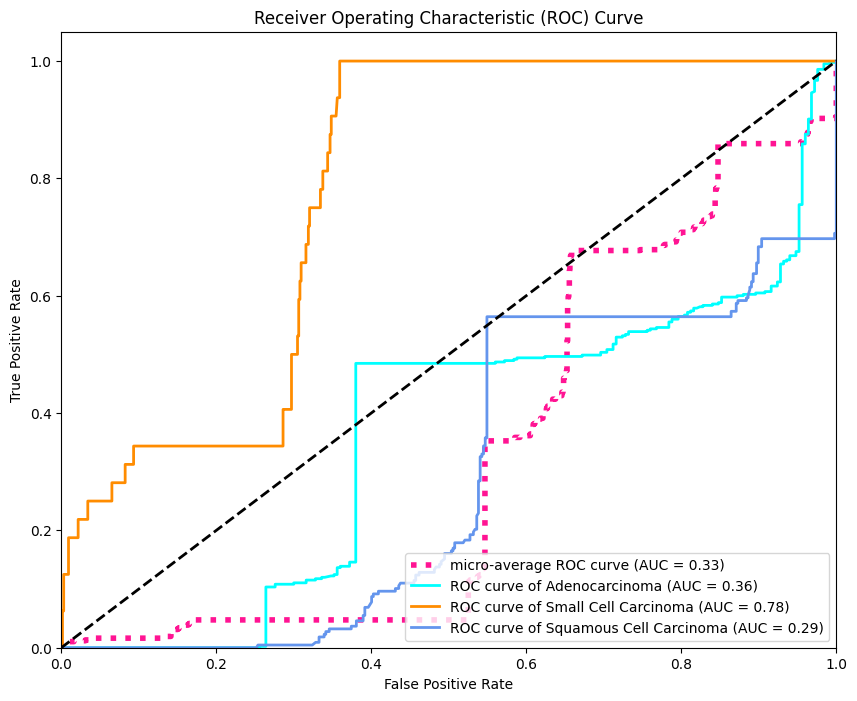

AUC Scores:
Adenocarcinoma: 0.3611
Small Cell Carcinoma: 0.7793
Squamous Cell Carcinoma: 0.2942
Micro-average: 0.3298


In [33]:
ViTB16_Dino_Model.load_state_dict(state_loader_fixer(torch.load("best_models/Pre-Processed/ViT-B16 Dino/best_model.pth")))
plot_roc_auc(ViTB16_Dino_Model, test_dataloader, device)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.3637
Test Precision: 0.1210
Test Recall: 0.3333
Test F1 Score: 0.1775
Test Sensitivity: 0.3333


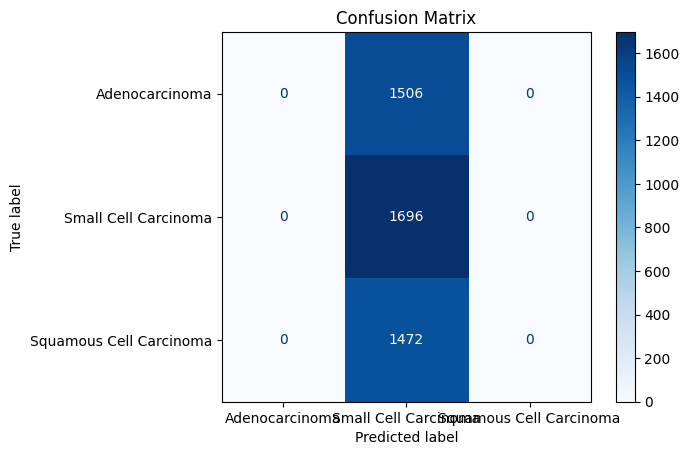

In [34]:
Model_evaluate(ViTB16_Dino_Model,train_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.1487
Test Precision: 0.0511
Test Recall: 0.3333
Test F1 Score: 0.0885
Test Sensitivity: 0.3333


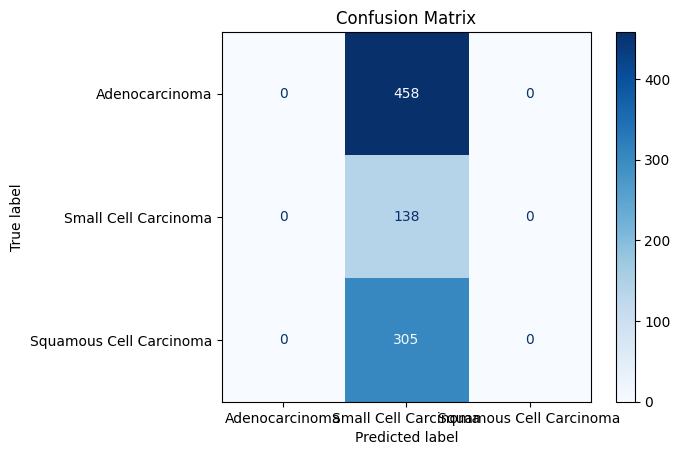

In [35]:
Model_evaluate(ViTB16_Dino_Model,valid_dataloader)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.0455
Test Precision: 0.0158
Test Recall: 0.3333
Test F1 Score: 0.0302
Test Sensitivity: 0.3333


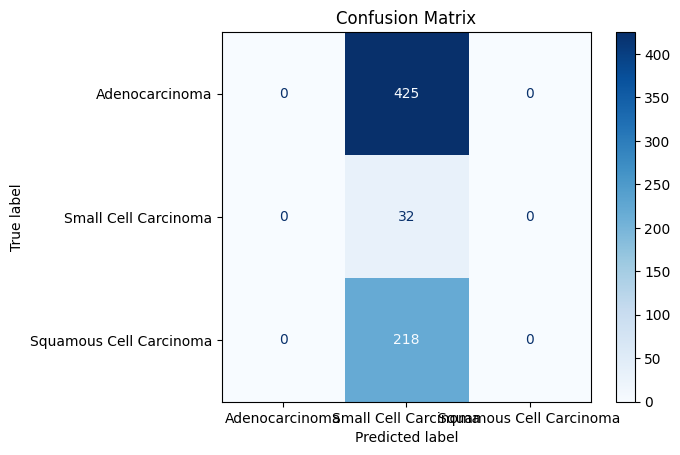

In [36]:
Model_evaluate(ViTB16_Dino_Model,test_dataloader)

**The image processing techniques failed to enhance the models' ability to extract useful information, leading to no improvement in the results**

# Hyper Model (New Approach)

The models demonstrated no ability to extract any distinguishable features that would assist in classifying among the three types of lung cancer.

**Hyper Model**

To address this limitation, a novel approach is used to leverage both deep learning feature extractors and statistical feature extractors to extract more useful information from the image in order to classify the lung cancer type. This approach consists of two processes:

- Statistical Feature Extraction:

In order to extract Statistical Features, we separate the three channels to their original modalities (PET, CT) and feed them with the mask to the feature extractor. All of this is done using the pyradiomics library.

- Vision Transformer (ViT):

Feeds the RGB image (combined PET/CT) to ViT encoder to extract features.

- Feature Fusion and Classification:

Concatenates the features extracted by the ViT and the statistical features in the model's head. The combined features are used to classify the lung cancer type.

## Mask Creation

The statistical features extractor requires the creation of masks that identify the tumor in order to analyze this spot of the image.

* The first step is to create masks for the annotation files
* The second step is to create a new data loader that combines both images, masks, and labels


In [68]:

def yolo_to_mask(image_path, annotation_path, output_path):
    # load the image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Create an empty mask ( image full of zeros )
    mask = np.zeros((height, width), dtype=np.uint8)

    # Read YOLO annotation file .txt files
    with open(annotation_path, 'r') as f:
        lines = f.readlines()

    # Process each annotation file
    for line in lines:
        class_id, x_center, y_center, w, h = map(float, line.strip().split())

        # Convert YOLO coordinates to pixel coordinates
        x = int((x_center - w/2) * width)
        y = int((y_center - h/2) * height)
        w = int(w * width)
        h = int(h * height)

        # Draw the mask (rectangle)
        cv2.rectangle(mask, (x, y), (x+w, y+h), 255, -1)

    # Save the mask
    cv2.imwrite(output_path, mask)

def process_folder(input_folder, output_folder):
    # go through folders the input folder 
    for root, _, files in os.walk(input_folder):
        for image_file in files:
            if image_file.endswith(('.png')):
                
                image_path = os.path.join(root, image_file)
                annotation_file = os.path.splitext(image_file)[0] + '.txt'
                annotation_path = os.path.join(root, annotation_file)

                if not os.path.exists(annotation_path):
                    print(f"Annotation file not found for {image_file}")
                    continue

    
                relative_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)
                os.makedirs(output_subfolder, exist_ok=True)

                output_path = os.path.join(output_subfolder, os.path.splitext(image_file)[0] + '.png')

                yolo_to_mask(image_path, annotation_path, output_path)


In [70]:
input_folder = 'Final_dataset/Original Data/images/Aug'
output_folder = 'Final_dataset/Original Data/masks/Aug'
process_folder(input_folder, output_folder)


Annotation file not found for 1-004_55-checkpoint.png


In [81]:
input_folder = 'Final_dataset/Original Data/images/valid'
output_folder = 'Final_dataset/Original Data/masks/valid'
process_folder(input_folder, output_folder)

In [82]:
input_folder = 'Final_dataset/Original Data/images/test'
output_folder = 'Final_dataset/Original Data/masks/test'
process_folder(input_folder, output_folder)

## Data Loaders

In [2]:

class SegmentationClassificationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Create a list for all of the images and labels
        self.img_paths = []
        self.labels = []

        # Define acceptable image extensions
        self.valid_extensions = ('.png')

        # Iterate through class folders
        self.class_names = sorted(os.listdir(img_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}

        for class_name in self.class_names:
            class_folder = os.path.join(img_dir, class_name)
            for img_name in os.listdir(class_folder):
                # Check if the file is an image
                if img_name.lower().endswith(self.valid_extensions):
                    self.img_paths.append((os.path.join(class_folder, img_name), class_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, class_name = self.img_paths[idx]
        mask_class_folder = os.path.join(self.mask_dir, class_name)
        mask_path = os.path.join(mask_class_folder, os.path.basename(img_path))
        label = self.labels[idx]

        # Check if files exist
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask file not found: {mask_path}")

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

img_dir = 'Final_dataset/Original Data/images/Aug'
mask_dir = 'Final_dataset/Original Data/masks/Aug'

train_dataset = SegmentationClassificationDataset(img_dir=img_dir, mask_dir=mask_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

img_dir = 'Final_dataset/Original Data/images/valid'
mask_dir = 'Final_dataset/Original Data/masks/valid'

valid_dataset = SegmentationClassificationDataset(img_dir=img_dir, mask_dir=mask_dir, transform=transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

img_dir = 'Final_dataset/Original Data/images/test'
mask_dir = 'Final_dataset/Original Data/masks/test'

test_dataset = SegmentationClassificationDataset(img_dir=img_dir, mask_dir=mask_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Hyper-Model

In [3]:

logging.getLogger('radiomics').setLevel(logging.ERROR)

class ViTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        
        # Remove the classification head
        self.model.reset_classifier(0)

    def forward(self, image):
        return self.model(image)


class Radiomics_Feature(nn.Module):
    def __init__(self):
        super().__init__()
        self.extractor = featureextractor.RadiomicsFeatureExtractor()
        #self.extractor.enableAllFeatures()
        self.extractor.disableAllFeatures()
        self.extractor.enableFeatureClassByName('firstorder')
        self.extractor.enableFeatureClassByName('glcm')
        self.extractor.enableFeatureClassByName('glrlm')
        self.extractor.enableFeatureClassByName('glszm')
        self.extractor.enableFeatureClassByName('ngtdm')
        self.extractor.enableFeatureClassByName('gldm')
        self.extractor.enableFeatureClassByName('shape2D')
        

    def forward(self, image, mask):
        results = []
        # Loop through each image in the batch
        for i in range(image.shape[0]):
            image_results = []

            # Loop through each channel in the image
            for channel in range(image.shape[1]):
                channel_image = image[i, channel, :, :].unsqueeze(0)
                channel_mask = mask[i].unsqueeze(0)
                image_sitk = sitk.GetImageFromArray(channel_image.squeeze().cpu().numpy())
                mask_sitk = sitk.GetImageFromArray(channel_mask.squeeze().cpu().numpy())

                # Extract features using the extractor
                result = self.extractor.execute(image_sitk, mask_sitk)

                # Collect filtered values from result
                filtered_values = [float(value) for key, value in result.items() if not key.startswith('diagnostics')]

                # Append the filtered values for this channel
                image_results.extend(filtered_values)

            # Append the concatenated results for this image to the results list
            results.append(image_results)

        results_tensor = torch.tensor(results)
        result_tensor = results_tensor.to(device=image.device)

        return result_tensor


class CombinedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dl_features = ViTModel()
        self.radiomics = Radiomics_Feature()

        # Fully connected layers for each model
        self.dl_fc = nn.Sequential(
            nn.Linear(768, 1024), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512)
        )
        # Normalization layers
        # self.dl_norm = nn.LayerNorm(512)
        # self.rad_norm = nn.LayerNorm(306)

        self.classifier = nn.Sequential(
            nn.Linear(512 + 306, 256),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 3)
        )


    def forward(self, x):
        image, mask, label = x
        #deep learning features
        dl_features = self.dl_features(image)
        dl_features = dl_features.view(dl_features.size(0), -1)
        dl_features = self.dl_fc(dl_features)
        #dl_features = self.dl_norm(dl_features)
        
        # Statistical Features
        rad_features = self.radiomics(image, mask)
        #rad_features = self.rad_norm(rad_features)



        # Concatenate features
        combined_features = torch.cat((dl_features, rad_features), dim=1)
        combined_features = combined_features.to(device=torch.device('cuda'))
        
        # Classifier
        output = self.classifier(combined_features)

        return output

device = "cuda" if torch.cuda.is_available() else "cpu"

Hyper_Model = CombinedModel()

Hyper_Model = Hyper_Model.to(device)

# with torch.no_grad():
#     # Move batch to device
#     batch = next(iter(train_dataloader))
#     batch = [item.to(device) for item in batch]

#     out = Hyper_Model(batch)
#     print(out.shape)


optimizer = torch.optim.Adam(params=Hyper_Model.parameters(),
                             lr=1e-3,weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

Hyper_Model_results = Train(model=Hyper_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=5,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|████████▍                                 | 1/5 [15:04<1:00:19, 905.00s/it]


 Epoch 1, Training Loss: 1574.0967, Training Accuracy: 0.3603, Test Loss: 1.1280, Test Accuracy: 0.1562
Test Precision: 0.0235, Test Recall: 0.1533, Test F1 Score: 0.0408


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 40%|█████████████████▌                          | 2/5 [25:59<37:52, 757.57s/it]


 Epoch 2, Training Loss: 9.8144, Training Accuracy: 0.3618, Test Loss: 1.1274, Test Accuracy: 0.1487
Test Precision: 0.0235, Test Recall: 0.1533, Test F1 Score: 0.0408


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|██████████████████████████▍                 | 3/5 [36:52<23:39, 709.71s/it]


 Epoch 3, Training Loss: 5.2451, Training Accuracy: 0.3620, Test Loss: 1.1250, Test Accuracy: 0.1562
Test Precision: 0.0235, Test Recall: 0.1533, Test F1 Score: 0.0408


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 80%|███████████████████████████████████▏        | 4/5 [47:46<11:27, 687.73s/it]


 Epoch 4, Training Loss: 4.0121, Training Accuracy: 0.3626, Test Loss: 1.1237, Test Accuracy: 0.1562
Test Precision: 0.0235, Test Recall: 0.1533, Test F1 Score: 0.0408


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|████████████████████████████████████████████| 5/5 [58:38<00:00, 703.73s/it]


 Epoch 5, Training Loss: 3.2288, Training Accuracy: 0.3624, Test Loss: 1.1235, Test Accuracy: 0.1487
Test Precision: 0.0235, Test Recall: 0.1533, Test F1 Score: 0.0408


In [10]:
Hyper_Model_results['valid_loss'] = Hyper_Model_results.pop('test_loss')
Hyper_Model_results['valid_accuracy'] = Hyper_Model_results.pop('test_accuracy')

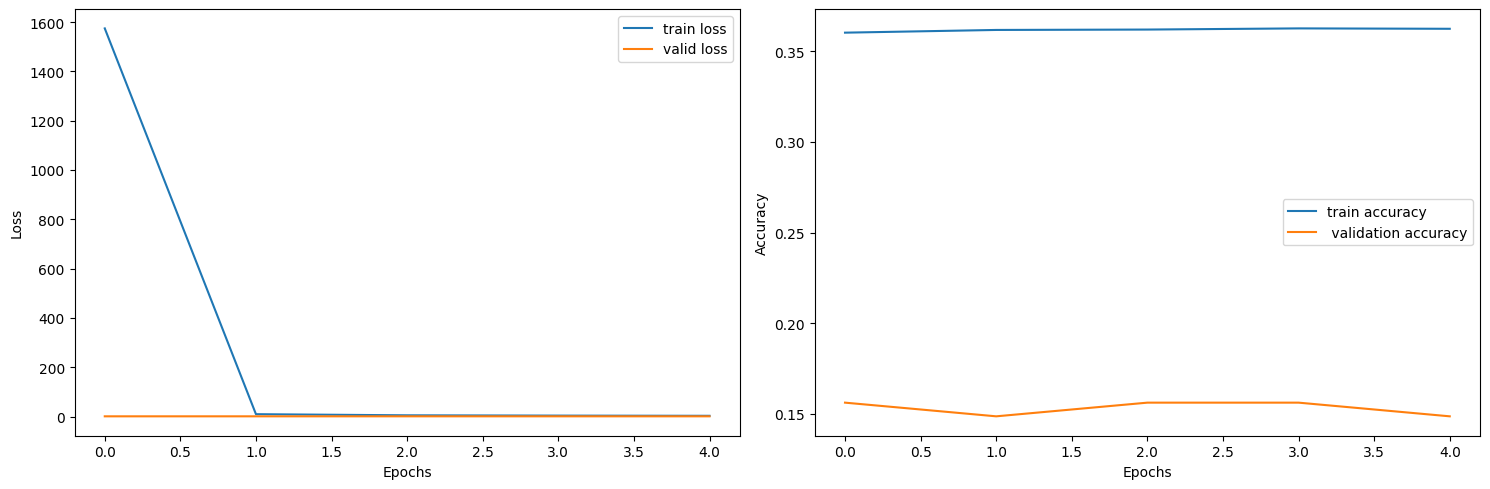

In [12]:
loss_and_acc_plots(Hyper_Model_results,True)

In [ ]:
Model_evaluate(Hyper_Model, train_dataloader)

In [ ]:
Model_evaluate(Hyper_Model, valid_dataloader)

In [ ]:
Model_evaluate(Hyper_Model, test_dataloader)

- The Hyper Model demonstrated no significant improvement.

- Despite the implementation of various models, image processing techniques, and the Hyper Model, the results remain the same. Therefore, the next phase of this research will focus on conducting a series of diagnostic tests and analyses which aim to identifying the models inability to classify lung cancer type.


# Diagnostic Analysis of Model Performance Limitations

- All the models achieve accuracy score between 30-50%, which is almost guessing, it is likely that the images lack distinguishable features between classes, resulting in model confusion.


- in this section, we will utilize **pyradiomics** library for statistical feature extraction then we will calculate the cosine similarity between the feature vectors. This analysis will assess the degree of similarity between vectors representing images from different classes, providing insight into the models' ability to distinguish between classes.

In [9]:
def extract_radiomics_features(image_paths, mask_paths):
    # Initialize the feature extractor
    FE = featureextractor.RadiomicsFeatureExtractor()
    FE.disableAllFeatures()
    FE.enableFeatureClassByName('firstorder')
    FE.enableFeatureClassByName('glcm')
    FE.enableFeatureClassByName('glrlm')
    FE.enableFeatureClassByName('glszm')
    FE.enableFeatureClassByName('ngtdm')
    FE.enableFeatureClassByName('gldm')
    FE.enableFeatureClassByName('shape2D')

    all_features_list = []

    
    for image_path, mask_path in zip(image_paths, mask_paths):
        # read the image and mask
        image_np = cv2.imread(image_path, cv2.IMREAD_UNCHANGED) 
        mask_np = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) 

        # normalize the mask
        mask_np[mask_np == 255] = 1

        # Empty list to for the Extracted features for each channel and concatenate results
        all_features = []

        for channel_index in range(3):
            # Extract the current channel
            image_channel = image_np[:, :, channel_index]

            # Convert to SimpleITK images
            image_sitk = sitk.GetImageFromArray(image_channel)
            mask_sitk = sitk.GetImageFromArray(mask_np)

            # Extract features
            features = FE.execute(image_sitk, mask_sitk)

            # Filter out 'diagnostics' features and append them to the list
            filtered_values = [float(value) for key, value in features.items() if not key.startswith('diagnostics')]
            all_features.extend(filtered_values)

        all_features_list.append(all_features)

    return all_features_list


image_paths = ['Final_dataset/Original Data/images/Aug/A/1-001_114.png',
               "Final_dataset/Original Data/images/Aug/B/1-033_226_aug_1.png",
               'Final_dataset/Original Data/images/Aug/G/1-004_66_aug_1.png']

mask_paths = ['Final_dataset/Original Data/masks/Aug/A/1-001_114.png',
              "Final_dataset/Original Data/masks/Aug/B/1-033_226_aug_1.png" ,
              'Final_dataset/Original Data/masks/Aug/G/1-004_66_aug_1.png']

features_list = extract_radiomics_features(image_paths, mask_paths)


features_1 = np.array(features_list[0]).reshape(1, -1)
features_2 = np.array(features_list[1]).reshape(1, -1)
features_3 = np.array(features_list[2]).reshape(1, -1)

cosine_sim = cosine_similarity(features_1, features_2)[0][0]
print(f"Cosine sim between class A and class B: {cosine_sim}")
cosine_sim = cosine_similarity(features_1, features_3)[0][0]
print(f"Cosine sim between class A and class G: {cosine_sim}")
cosine_sim = cosine_similarity(features_2, features_3)[0][0]
print(f"Cosine sim between class B and class B: {cosine_sim}")


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/radiomics/imageoperations.py:125: RuntimeWarning: overflow encountered in scalar add
  highBound = maximum + 2 * binWidth
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site

Cosine sim between class A and class B: 0.9181696136379098
Cosine sim between class A and class G: 0.933613595979196
Cosine sim between class B and class B: 0.9940182187655515


- The observed high cosine similarity between the extracted features of images representing different classes corroborates our hypothesis. 

- **The tumors in the images appear to lack distinguishable features.** This finding suggests that both deep learning and statistical feature extraction methods are not capable of effectively classifying lung cancer types, indicating that this dataset presents a significant challenge for automated analysis.

# Previous Research

- Previous researchs that utilized this dataset have reported high performance. in[], researchers achieved 95% accuray , 92.5% precision , 94.6% recall and an AUC of 0.97%, while ____ [] utilized MobileNet and Xception models reached 74% and 78% accuracy, while DETR Model have attained 96% accuracy.

- In comparsion with our findings , we observe a significant gap in performance metrics, which lead us to suspect potential data leakage in the preocess.

- This data leakage is possibly occuring during data splitting. This issue could lead to inflated performance and require further examination.

* In the next phase of this study, we will intentionally introduce data leakage into our dataset by splitting the data without regard to patient-wise separation and monitor the inflated performance. 


**Table 1: Training Results**

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\text{Models} & \text{Accuracy} & \text{Precision} & \text{Recall} & \text{F1-score} & \text{Sensitivity} \\
\hline
\text{Resnet101} & 96.37\% & 96.38\% & 96.45\% & 96.41\% & 96.45\%\\
\hline
\textbf{Densenet121} & 97.04\% & 96.88\% & 97.21\% & 96.96\% & 97.21\% \\
\hline
\end{array}
$$


**Table 2: Validataion Results**

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\text{Models} & \text{Accuracy} & \text{Precision} & \text{Recall} & \text{F1-score} & \text{Sensitivity} \\
\hline
\text{Resnet101} & 90.36\% & 88.68\% & 90.57\% & 89.22\% & 90.57\% \\
\hline
\textbf{Densenet121} & 95.57\% & 96.10\% & 94.04\% & 94.93\% & 94.04\% \\
\hline
\end{array}
$$


**Table 3: Testing Results**

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\text{Models} & \text{Accuracy} & \text{Precision} & \text{Recall} & \text{F1-score} & \text{Sensitivity} \\
\hline
\text{Resnet101} & 88.30\% & 87.18\% & 86.99\% & 87.08\% & 86.99\%\\
\hline
\textbf{Densenet121} & 93.06\% & 93.75\% & 91.29\% & 92.10\% & 91.29\% \\
\hline
\end{array}
$$


**Table 4: AUC Curve Results**

$$
\begin{array}{|c|c|c|c|}
\hline
\text{Model} & \text{AUC (Meningioma)} & \text{AUC (Glioma)} & \text{AUC (Pituitary)} \\
\hline
\text{Resnet101} & \text{0.9502} & \text{0.9712} & \text{0.9934} \\
\hline
\textbf{Densenet121} & \text{0.9787} & \text{0.9877} & \text{0.9968} \\
\hline
\end{array}
$$


## Data leakage between the sets

In [3]:
def create_csv(root_folder, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Image Name', 'Label', 'Image Path', 'Annotation Path'])

        for split in ['train', 'valid', 'test']:
            split_path = os.path.join(root_folder, split)
            for label in ['A', 'B', 'G']:
                label_path = os.path.join(split_path, label)
                if os.path.exists(label_path):
                    for file in os.listdir(label_path):
                        if file.lower().endswith(('.png')):
                            image_name = file
                            image_path = os.path.join(label_path, file)
                            annotation_name = os.path.splitext(file)[0] + '.txt'
                            annotation_path = os.path.join(label_path, annotation_name)
                            
                            if os.path.exists(annotation_path):
                                csvwriter.writerow([image_name, label, image_path, annotation_path])
                            else:
                                print(f"Warning: Annotation file not found for {image_path}")

    print(f"CSV file created successfully: {output_file}")


root_folder = 'Final_dataset/Original Data/images'  
output_file = 'leaked_csv_files/leaked_data.csv'  

create_csv(root_folder, output_file)

CSV file created successfully: leaked_csv_files/leaked_data.csv


This code create metadata for the leaked dataset

In [5]:

# Load the metadata
file_path = 'leaked_csv_files/leaked_data.csv'
data = pd.read_csv(file_path)

class_column = data.columns[1]

#split the data into training 60% and temp 40% (Testing and validation)
train_data, temp_data = train_test_split(
    data, 
    test_size=0.4, 
    stratify=data[class_column], 
    random_state=42
)

# split the temp data into validation (20%) and testing (20%)
val_data, test_data = train_test_split(
    temp_data, 
    test_size=0.5, 
    stratify=temp_data[class_column], 
    random_state=42
)

# Save the csv files for each set
train_data.to_csv('leaked_csv_files/leaked_train.csv', index=False)
val_data.to_csv('leaked_csv_files/leaked_valid.csv', index=False)
test_data.to_csv('leaked_csv_files/leaked_test.csv', index=False)



In [ ]:
def process_csv(file_path, dataset_type):
    df = pd.read_csv(file_path)
    
    # Iterate over every row in the DataFrame
    for index, row in df.iterrows():
        patient_id = row['Image Name']
        label = row['Label']
        image_path = row['Image Path']
        annotation_path = row['Annotation Path']
        

        label_dir = os.path.join(output_base_dir, dataset_type, label)
        os.makedirs(label_dir, exist_ok=True)
        
        # Copy the image and annotation files to the label directory
        image_dest = os.path.join(label_dir, os.path.basename(image_path))
        annotation_dest = os.path.join(label_dir, os.path.basename(annotation_path))
        
        shutil.copy(image_path, image_dest)
        shutil.copy(annotation_path, annotation_dest)
        
        print(f"Processed patient_id: {patient_id}, label: {label}, dataset: {dataset_type}")

# Define the paths to the CSV files
csv_files = {
    'train': 'leaked_csv_files/leaked_train.csv',
    'test': 'leaked_csv_files/leaked_valid.csv',
    'valid': 'leaked_csv_files/leaked_test.csv'
}
# output_directory path
output_base_dir = '/leaked_dataset'

for dataset_type, file_path in csv_files.items():
    process_csv(file_path, dataset_type)


In [4]:
train_dataloader,valid_dataloader,test_dataloader= Create_dataloader(train_dir="leaked_dataset/train"
                                                                     ,valid_dir="leaked_dataset/valid"
                                                                     ,test_dir="leaked_dataset/test"
                                                                     ,batch_size=32)


In [5]:
def calculate_class_weights(train_data):
    targets = torch.tensor(train_data.targets)
    class_sample_count = torch.tensor([(targets == t).sum() for t in torch.unique(targets, sorted=True)])
    class_weights = 1. / class_sample_count.float()
    class_weights = class_weights / class_weights.sum()  # Normalize to sum to 1
    return class_weights
    
train_data_transforms = Compose([transforms.ToTensor(),transforms.Resize(size=(224,224))])

train_data = ImageFolder("leaked_dataset/train",
                         transform=train_data_transforms)
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights = calculate_class_weights(train_data)
class_weights = class_weights.to(device)

Create class weight for imbalance dataset

In [5]:
class ResNet(torch.nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.resnet(x)


In [27]:
ResNet_Model = ResNet(num_classes=3)
device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ResNet_Model.parameters(),
                             lr=1e-3)

scheduler = ExponentialLR(optimizer, gamma=0.9)

ResNet_Model = ResNet_Model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

ResNet_Model_results = train(model=ResNet_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,
                            scheduler=scheduler,early_stopping=True)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|█▏                                                           | 1/50 [00:40<33:25, 40.93s/it]


Epoch 1, Training Loss: 4.3852, Training Accuracy: 0.5324, Training Precision: 0.5115, Training Recall: 0.5564, Training F1: 0.5244, Test Loss: 0.6313, Test Accuracy: 0.6572, Test Precision: 0.6303, Test Recall: 0.6739, Test F1: 0.6229, Test Sensitivity: 0.6739


  4%|██▍                                                          | 2/50 [01:15<29:45, 37.20s/it]


Epoch 2, Training Loss: 2.8530, Training Accuracy: 0.7247, Training Precision: 0.7279, Training Recall: 0.7735, Training F1: 0.7431, Test Loss: 0.7534, Test Accuracy: 0.6656, Test Precision: 0.6782, Test Recall: 0.7695, Test F1: 0.6663, Test Sensitivity: 0.7695


  6%|███▋                                                         | 3/50 [01:52<28:57, 36.97s/it]


Epoch 3, Training Loss: 2.0553, Training Accuracy: 0.8829, Training Precision: 0.8776, Training Recall: 0.9058, Training F1: 0.8897, Test Loss: 0.3747, Test Accuracy: 0.8796, Test Precision: 0.8688, Test Recall: 0.9169, Test F1: 0.8838, Test Sensitivity: 0.9169


  8%|████▉                                                        | 4/50 [02:27<27:49, 36.28s/it]


Epoch 4, Training Loss: 1.7864, Training Accuracy: 0.9205, Training Precision: 0.9016, Training Recall: 0.9295, Training F1: 0.9144, Test Loss: 0.5261, Test Accuracy: 0.8657, Test Precision: 0.8910, Test Recall: 0.8842, Test F1: 0.8751, Test Sensitivity: 0.8842


 10%|██████                                                       | 5/50 [03:04<27:27, 36.61s/it]


Epoch 5, Training Loss: 1.4971, Training Accuracy: 0.9703, Training Precision: 0.9631, Training Recall: 0.9726, Training F1: 0.9677, Test Loss: 0.7787, Test Accuracy: 0.8764, Test Precision: 0.9221, Test Recall: 0.7685, Test F1: 0.8126, Test Sensitivity: 0.7685


 12%|███████▎                                                     | 6/50 [03:41<26:56, 36.75s/it]


Epoch 6, Training Loss: 1.6591, Training Accuracy: 0.9608, Training Precision: 0.9488, Training Recall: 0.9650, Training F1: 0.9566, Test Loss: 0.3659, Test Accuracy: 0.8854, Test Precision: 0.9049, Test Recall: 0.9178, Test F1: 0.9004, Test Sensitivity: 0.9178


 14%|████████▌                                                    | 7/50 [04:18<26:20, 36.75s/it]


Epoch 7, Training Loss: 1.3007, Training Accuracy: 0.9889, Training Precision: 0.9865, Training Recall: 0.9917, Training F1: 0.9891, Test Loss: 0.0147, Test Accuracy: 0.9965, Test Precision: 0.9967, Test Recall: 0.9958, Test F1: 0.9962, Test Sensitivity: 0.9958


 16%|█████████▊                                                   | 8/50 [04:54<25:32, 36.50s/it]


Epoch 8, Training Loss: 1.0313, Training Accuracy: 0.9953, Training Precision: 0.9945, Training Recall: 0.9961, Training F1: 0.9953, Test Loss: 0.5891, Test Accuracy: 0.9213, Test Precision: 0.8776, Test Recall: 0.9498, Test F1: 0.9012, Test Sensitivity: 0.9498


 18%|██████████▉                                                  | 9/50 [05:31<25:02, 36.63s/it]


Epoch 9, Training Loss: 1.0200, Training Accuracy: 0.9877, Training Precision: 0.9852, Training Recall: 0.9903, Training F1: 0.9877, Test Loss: 0.0286, Test Accuracy: 0.9884, Test Precision: 0.9887, Test Recall: 0.9911, Test F1: 0.9899, Test Sensitivity: 0.9911


 18%|██████████▉                                                  | 9/50 [06:08<27:59, 40.96s/it]

Early stopping at epoch 10


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 0.9942
Test Precision: 0.9953
Test Recall: 0.9917
Test F1 Score: 0.9934
Test Sensitivity: 0.9917


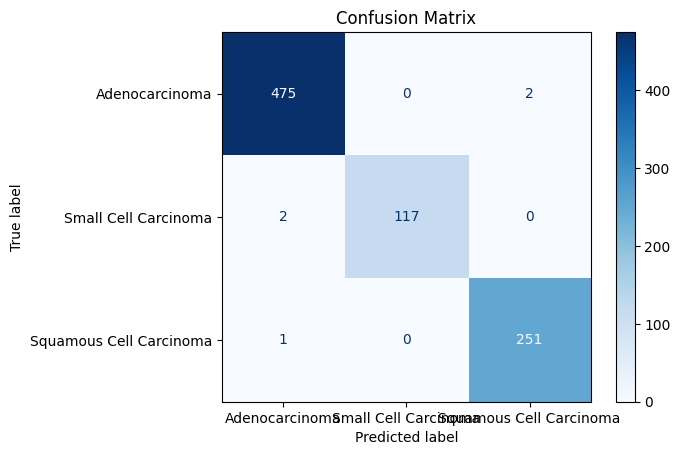

In [9]:
ResNet_Model.load_state_dict(torch.load('leaked_best_models/Resnet/best_model.pth'))
ResNet_Model = ResNet_Model.to(device)
Model_evaluate(ResNet_Model, test_dataloader)

In [28]:
class ViT_B16(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.vitb16= create_model('vit_base_patch16_224', pretrained=True)
        self.vitb16.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self,x):
        return self.vitb16(x)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()
   
ViT_B16_model = ViT_B16(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ViT_B16_model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

ViT_B16_model = ViT_B16_model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

ViT_B16_model_results = train(model=ViT_B16_model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=True,
                            patience=5,use_multiple_gpus=True)


Using 3 GPUs


  0%|                                                                     | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|█▏                                                           | 1/50 [00:48<39:43, 48.64s/it]


Epoch 1, Training Loss: 11.6208, Training Accuracy: 0.5348, Training Precision: 0.3661, Training Recall: 0.3439, Training F1: 0.3068, Test Loss: 0.9654, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|██▍                                                          | 2/50 [01:34<37:35, 46.98s/it]


Epoch 2, Training Loss: 5.5155, Training Accuracy: 0.5538, Training Precision: 0.2980, Training Recall: 0.3339, Training F1: 0.2568, Test Loss: 0.9681, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|███▋                                                         | 3/50 [02:23<37:27, 47.81s/it]


Epoch 3, Training Loss: 3.7985, Training Accuracy: 0.5605, Training Precision: 0.3041, Training Recall: 0.3341, Training F1: 0.2454, Test Loss: 0.9660, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|████▉                                                        | 4/50 [03:09<36:09, 47.17s/it]


Epoch 4, Training Loss: 3.0924, Training Accuracy: 0.5621, Training Precision: 0.4095, Training Recall: 0.3340, Training F1: 0.2416, Test Loss: 0.9803, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|██████                                                       | 5/50 [03:55<34:59, 46.65s/it]


Epoch 5, Training Loss: 2.7280, Training Accuracy: 0.5617, Training Precision: 0.1872, Training Recall: 0.3333, Training F1: 0.2398, Test Loss: 0.9706, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|███████▎                                                     | 6/50 [04:40<33:59, 46.35s/it]


Epoch 6, Training Loss: 2.5239, Training Accuracy: 0.5617, Training Precision: 0.1872, Training Recall: 0.3333, Training F1: 0.2398, Test Loss: 0.9635, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 14%|████████▌                                                    | 7/50 [05:36<35:15, 49.20s/it]


Epoch 7, Training Loss: 2.3902, Training Accuracy: 0.5617, Training Precision: 0.1872, Training Recall: 0.3333, Training F1: 0.2398, Test Loss: 0.9625, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 16%|█████████▊                                                   | 8/50 [06:22<33:54, 48.43s/it]


Epoch 8, Training Loss: 2.2959, Training Accuracy: 0.5617, Training Precision: 0.1872, Training Recall: 0.3333, Training F1: 0.2398, Test Loss: 0.9670, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 18%|██████████▉                                                  | 9/50 [07:10<32:57, 48.22s/it]


Epoch 9, Training Loss: 2.2266, Training Accuracy: 0.5617, Training Precision: 0.1872, Training Recall: 0.3333, Training F1: 0.2398, Test Loss: 0.9753, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|████████████                                                | 10/50 [07:58<32:10, 48.25s/it]


Epoch 10, Training Loss: 2.1743, Training Accuracy: 0.5617, Training Precision: 0.1872, Training Recall: 0.3333, Training F1: 0.2398, Test Loss: 0.9599, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 22%|█████████████▏                                              | 11/50 [08:46<31:18, 48.18s/it]


Epoch 11, Training Loss: 2.1356, Training Accuracy: 0.5617, Training Precision: 0.1872, Training Recall: 0.3333, Training F1: 0.2398, Test Loss: 0.9588, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 24%|██████████████▍                                             | 12/50 [09:36<30:47, 48.62s/it]


Epoch 12, Training Loss: 2.0893, Training Accuracy: 0.5617, Training Precision: 0.1872, Training Recall: 0.3333, Training F1: 0.2398, Test Loss: 0.9472, Test Accuracy: 0.5498, Test Precision: 0.1878, Test Recall: 0.3333, Test F1: 0.2403, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 26%|███████████████▌                                            | 13/50 [10:25<29:57, 48.58s/it]


Epoch 13, Training Loss: 2.0247, Training Accuracy: 0.5756, Training Precision: 0.3455, Training Recall: 0.3847, Training F1: 0.3518, Test Loss: 0.8636, Test Accuracy: 0.6037, Test Precision: 0.3884, Test Recall: 0.4561, Test F1: 0.4185, Test Sensitivity: 0.4561


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 28%|████████████████▊                                           | 14/50 [11:11<28:50, 48.06s/it]


Epoch 14, Training Loss: 1.9423, Training Accuracy: 0.6388, Training Precision: 0.4051, Training Recall: 0.4736, Training F1: 0.4365, Test Loss: 0.8341, Test Accuracy: 0.6521, Test Precision: 0.4348, Test Recall: 0.5143, Test F1: 0.4606, Test Sensitivity: 0.5143


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 30%|██████████████████                                          | 15/50 [11:56<27:29, 47.13s/it]


Epoch 15, Training Loss: 1.8748, Training Accuracy: 0.6784, Training Precision: 0.4378, Training Recall: 0.5164, Training F1: 0.4711, Test Loss: 0.7818, Test Accuracy: 0.6716, Test Precision: 0.4346, Test Recall: 0.5127, Test F1: 0.4657, Test Sensitivity: 0.5127


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 32%|███████████████████▏                                        | 16/50 [12:44<26:43, 47.17s/it]


Epoch 16, Training Loss: 1.7869, Training Accuracy: 0.7156, Training Precision: 0.4660, Training Recall: 0.5516, Training F1: 0.4996, Test Loss: 0.7581, Test Accuracy: 0.6924, Test Precision: 0.4509, Test Recall: 0.5335, Test F1: 0.4828, Test Sensitivity: 0.5335


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 34%|████████████████████▍                                       | 17/50 [13:33<26:18, 47.85s/it]


Epoch 17, Training Loss: 1.7308, Training Accuracy: 0.7282, Training Precision: 0.5987, Training Recall: 0.5627, Training F1: 0.5182, Test Loss: 0.6531, Test Accuracy: 0.7191, Test Precision: 0.4640, Test Recall: 0.5478, Test F1: 0.4987, Test Sensitivity: 0.5478


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 36%|█████████████████████▌                                      | 18/50 [14:19<25:10, 47.19s/it]


Epoch 18, Training Loss: 1.6480, Training Accuracy: 0.7492, Training Precision: 0.6251, Training Recall: 0.5868, Training F1: 0.5601, Test Loss: 0.6349, Test Accuracy: 0.7341, Test Precision: 0.4847, Test Recall: 0.5727, Test F1: 0.5150, Test Sensitivity: 0.5727


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 38%|██████████████████████▊                                     | 19/50 [15:08<24:40, 47.76s/it]


Epoch 19, Training Loss: 1.5879, Training Accuracy: 0.7591, Training Precision: 0.6136, Training Recall: 0.5905, Training F1: 0.5610, Test Loss: 0.6191, Test Accuracy: 0.7561, Test Precision: 0.4913, Test Recall: 0.5822, Test F1: 0.5280, Test Sensitivity: 0.5822


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 40%|████████████████████████                                    | 20/50 [15:59<24:25, 48.86s/it]


Epoch 20, Training Loss: 1.5491, Training Accuracy: 0.7579, Training Precision: 0.5788, Training Recall: 0.5829, Training F1: 0.5427, Test Loss: 0.5803, Test Accuracy: 0.7583, Test Precision: 0.4930, Test Recall: 0.5841, Test F1: 0.5286, Test Sensitivity: 0.5841


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 42%|█████████████████████████▏                                  | 21/50 [16:47<23:25, 48.46s/it]


Epoch 21, Training Loss: 1.5177, Training Accuracy: 0.7789, Training Precision: 0.6299, Training Recall: 0.5990, Training F1: 0.5483, Test Loss: 0.5604, Test Accuracy: 0.7560, Test Precision: 0.4857, Test Recall: 0.5733, Test F1: 0.5228, Test Sensitivity: 0.5733


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 44%|██████████████████████████▍                                 | 22/50 [17:33<22:17, 47.77s/it]


Epoch 22, Training Loss: 1.4730, Training Accuracy: 0.7773, Training Precision: 0.5781, Training Recall: 0.5968, Training F1: 0.5552, Test Loss: 0.5515, Test Accuracy: 0.7583, Test Precision: 0.4931, Test Recall: 0.5841, Test F1: 0.5285, Test Sensitivity: 0.5841


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 46%|███████████████████████████▌                                | 23/50 [18:22<21:41, 48.21s/it]


Epoch 23, Training Loss: 1.4531, Training Accuracy: 0.7785, Training Precision: 0.6308, Training Recall: 0.6002, Training F1: 0.5486, Test Loss: 0.5610, Test Accuracy: 0.7525, Test Precision: 0.4779, Test Recall: 0.5592, Test F1: 0.5150, Test Sensitivity: 0.5592


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 48%|████████████████████████████▊                               | 24/50 [19:08<20:31, 47.38s/it]


Epoch 24, Training Loss: 1.4378, Training Accuracy: 0.7892, Training Precision: 0.6553, Training Recall: 0.6089, Training F1: 0.5563, Test Loss: 0.5312, Test Accuracy: 0.7699, Test Precision: 0.5021, Test Recall: 0.5949, Test F1: 0.5375, Test Sensitivity: 0.5949


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 50%|██████████████████████████████                              | 25/50 [19:54<19:37, 47.11s/it]


Epoch 25, Training Loss: 1.4275, Training Accuracy: 0.7832, Training Precision: 0.6593, Training Recall: 0.6094, Training F1: 0.5684, Test Loss: 0.4962, Test Accuracy: 0.7791, Test Precision: 0.5049, Test Recall: 0.5987, Test F1: 0.5430, Test Sensitivity: 0.5987


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 52%|███████████████████████████████▏                            | 26/50 [20:42<18:56, 47.34s/it]


Epoch 26, Training Loss: 1.3879, Training Accuracy: 0.7971, Training Precision: 0.6598, Training Recall: 0.6212, Training F1: 0.5787, Test Loss: 0.4725, Test Accuracy: 0.7849, Test Precision: 0.5102, Test Recall: 0.6047, Test F1: 0.5475, Test Sensitivity: 0.6047


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 54%|████████████████████████████████▍                           | 27/50 [21:28<18:02, 47.06s/it]


Epoch 27, Training Loss: 1.3787, Training Accuracy: 0.8006, Training Precision: 0.6550, Training Recall: 0.6209, Training F1: 0.5703, Test Loss: 0.4951, Test Accuracy: 0.7699, Test Precision: 0.4948, Test Recall: 0.5842, Test F1: 0.5329, Test Sensitivity: 0.5842


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 56%|█████████████████████████████████▌                          | 28/50 [22:20<17:42, 48.32s/it]


Epoch 28, Training Loss: 1.3783, Training Accuracy: 0.7951, Training Precision: 0.6451, Training Recall: 0.6142, Training F1: 0.5638, Test Loss: 0.4378, Test Accuracy: 0.8010, Test Precision: 0.5195, Test Recall: 0.6169, Test F1: 0.5583, Test Sensitivity: 0.6169


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 58%|██████████████████████████████████▊                         | 29/50 [23:09<17:01, 48.66s/it]


Epoch 29, Training Loss: 1.3503, Training Accuracy: 0.8058, Training Precision: 0.7030, Training Recall: 0.6308, Training F1: 0.5897, Test Loss: 0.4159, Test Accuracy: 0.8021, Test Precision: 0.5166, Test Recall: 0.6124, Test F1: 0.5560, Test Sensitivity: 0.6124


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|████████████████████████████████████                        | 30/50 [23:59<16:19, 48.96s/it]


Epoch 30, Training Loss: 1.3338, Training Accuracy: 0.8081, Training Precision: 0.6474, Training Recall: 0.6279, Training F1: 0.5806, Test Loss: 0.4187, Test Accuracy: 0.7998, Test Precision: 0.5217, Test Recall: 0.6192, Test F1: 0.5575, Test Sensitivity: 0.6192


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 62%|█████████████████████████████████████▏                      | 31/50 [24:47<15:24, 48.66s/it]


Epoch 31, Training Loss: 1.3242, Training Accuracy: 0.8105, Training Precision: 0.6630, Training Recall: 0.6326, Training F1: 0.5901, Test Loss: 0.3968, Test Accuracy: 0.8067, Test Precision: 0.5211, Test Recall: 0.6184, Test F1: 0.5602, Test Sensitivity: 0.6184


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 64%|██████████████████████████████████████▍                     | 32/50 [25:36<14:39, 48.86s/it]


Epoch 32, Training Loss: 1.3160, Training Accuracy: 0.8117, Training Precision: 0.6934, Training Recall: 0.6384, Training F1: 0.6014, Test Loss: 0.3929, Test Accuracy: 0.8102, Test Precision: 0.5230, Test Recall: 0.6205, Test F1: 0.5624, Test Sensitivity: 0.6205


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 66%|███████████████████████████████████████▌                    | 33/50 [26:28<14:04, 49.67s/it]


Epoch 33, Training Loss: 1.3062, Training Accuracy: 0.8101, Training Precision: 0.6495, Training Recall: 0.6324, Training F1: 0.5914, Test Loss: 0.3869, Test Accuracy: 0.8044, Test Precision: 0.5167, Test Recall: 0.6119, Test F1: 0.5566, Test Sensitivity: 0.6119


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 68%|████████████████████████████████████████▊                   | 34/50 [27:15<13:02, 48.89s/it]


Epoch 34, Training Loss: 1.2898, Training Accuracy: 0.8196, Training Precision: 0.7110, Training Recall: 0.6555, Training F1: 0.6311, Test Loss: 0.3910, Test Accuracy: 0.7998, Test Precision: 0.5121, Test Recall: 0.6053, Test F1: 0.5519, Test Sensitivity: 0.6053


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 70%|██████████████████████████████████████████                  | 35/50 [28:08<12:31, 50.12s/it]


Epoch 35, Training Loss: 1.2901, Training Accuracy: 0.8149, Training Precision: 0.6786, Training Recall: 0.6485, Training F1: 0.6250, Test Loss: 0.3834, Test Accuracy: 0.8067, Test Precision: 0.5241, Test Recall: 0.6222, Test F1: 0.5615, Test Sensitivity: 0.6222


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 72%|███████████████████████████████████████████▏                | 36/50 [28:56<11:36, 49.72s/it]


Epoch 36, Training Loss: 1.2861, Training Accuracy: 0.8244, Training Precision: 0.7345, Training Recall: 0.6619, Training F1: 0.6408, Test Loss: 0.3818, Test Accuracy: 0.8090, Test Precision: 0.5217, Test Recall: 0.6185, Test F1: 0.5611, Test Sensitivity: 0.6185


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 74%|████████████████████████████████████████████▍               | 37/50 [29:45<10:43, 49.48s/it]


Epoch 37, Training Loss: 1.2707, Training Accuracy: 0.8299, Training Precision: 0.7459, Training Recall: 0.6703, Training F1: 0.6504, Test Loss: 0.3797, Test Accuracy: 0.8113, Test Precision: 0.5254, Test Recall: 0.6237, Test F1: 0.5641, Test Sensitivity: 0.6237


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 76%|█████████████████████████████████████████████▌              | 38/50 [30:36<09:56, 49.72s/it]


Epoch 38, Training Loss: 1.2673, Training Accuracy: 0.8267, Training Precision: 0.7205, Training Recall: 0.6673, Training F1: 0.6490, Test Loss: 0.3771, Test Accuracy: 0.8113, Test Precision: 0.5246, Test Recall: 0.6225, Test F1: 0.5636, Test Sensitivity: 0.6225


 78%|██████████████████████████████████████████████▊             | 39/50 [31:23<08:59, 49.00s/it]


Epoch 39, Training Loss: 1.2618, Training Accuracy: 0.8236, Training Precision: 0.7086, Training Recall: 0.6765, Training F1: 0.6693, Test Loss: 0.3802, Test Accuracy: 0.8264, Test Precision: 0.7498, Test Recall: 0.7137, Test F1: 0.7240, Test Sensitivity: 0.7137


 80%|████████████████████████████████████████████████            | 40/50 [32:11<08:07, 48.73s/it]


Epoch 40, Training Loss: 1.2542, Training Accuracy: 0.8354, Training Precision: 0.7385, Training Recall: 0.7015, Training F1: 0.7014, Test Loss: 0.3696, Test Accuracy: 0.8322, Test Precision: 0.7458, Test Recall: 0.7479, Test F1: 0.7468, Test Sensitivity: 0.7479


 82%|█████████████████████████████████████████████████▏          | 41/50 [32:55<07:05, 47.29s/it]


Epoch 41, Training Loss: 1.2452, Training Accuracy: 0.8390, Training Precision: 0.7461, Training Recall: 0.7136, Training F1: 0.7160, Test Loss: 0.3801, Test Accuracy: 0.8368, Test Precision: 0.7558, Test Recall: 0.7590, Test F1: 0.7573, Test Sensitivity: 0.7590


 84%|██████████████████████████████████████████████████▍         | 42/50 [33:44<06:22, 47.86s/it]


Epoch 42, Training Loss: 1.2443, Training Accuracy: 0.8354, Training Precision: 0.7444, Training Recall: 0.7140, Training F1: 0.7179, Test Loss: 0.3788, Test Accuracy: 0.8287, Test Precision: 0.7458, Test Recall: 0.7596, Test F1: 0.7518, Test Sensitivity: 0.7596


 86%|███████████████████████████████████████████████████▌        | 43/50 [34:32<05:34, 47.84s/it]


Epoch 43, Training Loss: 1.2417, Training Accuracy: 0.8390, Training Precision: 0.7489, Training Recall: 0.7261, Training F1: 0.7302, Test Loss: 0.3866, Test Accuracy: 0.8241, Test Precision: 0.7389, Test Recall: 0.7490, Test F1: 0.7425, Test Sensitivity: 0.7490


 88%|████████████████████████████████████████████████████▊       | 44/50 [35:25<04:56, 49.34s/it]


Epoch 44, Training Loss: 1.2336, Training Accuracy: 0.8465, Training Precision: 0.7592, Training Recall: 0.7368, Training F1: 0.7416, Test Loss: 0.3738, Test Accuracy: 0.8449, Test Precision: 0.7670, Test Recall: 0.7811, Test F1: 0.7730, Test Sensitivity: 0.7811


 88%|████████████████████████████████████████████████████▊       | 44/50 [36:11<04:56, 49.35s/it]

Early stopping at epoch 45


In [ ]:
state_dict = torch.load("leaked_best_models/ViT B16/best_model.pth", map_location=device)

new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
ViT_B16_model.load_state_dict(new_state_dict)
ViT_B16_model.to(device)

Test Accuracy: 0.8264
Test Precision: 0.7485
Test Recall: 0.7624
Test F1 Score: 0.7547
Test Sensitivity: 0.7624


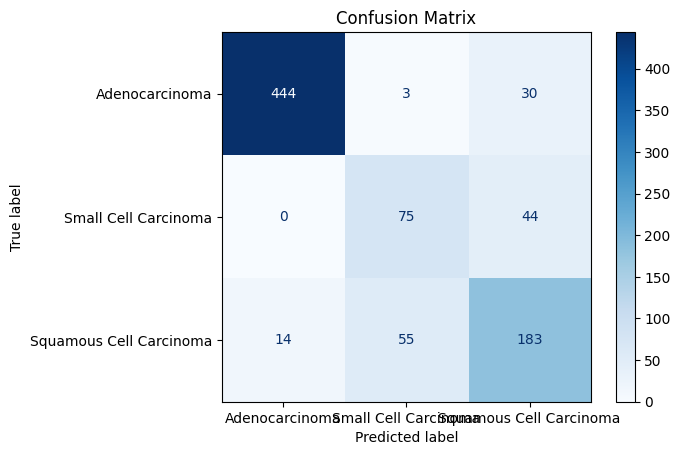

In [13]:
Model_evaluate(ViT_B16_model, test_dataloader)

- it's evident that data leakage has singifcantly boosted the results of Resnet and ViT models. now these models match the scores of previous studies.

- This improvement demonstrate how data leakage can inflate the results


## Random label leakage 

- In this section, we will split the data without considerting patient wise speration. in addition, we will remove the true label and assign random labels to all the images.

- this will highlight how data leakage can effect models and inflate the results.

In [38]:
df = pd.read_csv("leaked_csv_files/leaked_data.csv")

labels = np.repeat(['A', 'B', 'G'], len(df) // 3 + 1)[:len(df)]
np.random.shuffle(labels)

# Assign the new labels
df['Label'] = labels

# Save the modified DataFrame back to CSV
df.to_csv('shuffled_leaked_csv/shuffle_leaked.csv', index=False)

df["Label"].value_counts()

Label
B    1414
A    1414
G    1413
Name: count, dtype: int64

In [39]:
train_data, temp_data = train_test_split(
    data, 
    test_size=0.4, 
    stratify=data[class_column], 
    random_state=42
)

# split the temp data into validation (20%) and testing (20%)
val_data, test_data = train_test_split(
    temp_data, 
    test_size=0.5, 
    stratify=temp_data['Label'], 
    random_state=42
)

# Save the csv files for each set
train_data.to_csv('shuffled_leaked_csv/shuffle_leaked_train.csv', index=False)
val_data.to_csv('shuffled_leaked_csv/shuffle_leaked_valid.csv', index=False)
test_data.to_csv('shuffled_leaked_csv/shuffle_leaked_test.csv', index=False)


In [ ]:
csv_files = {
    'train': 'shuffled_leaked_csv/shuffle_leaked_train.csv',
    'test': 'shuffled_leaked_csv/shuffle_leaked_test.csv',
    'valid': 'shuffled_leaked_csv/shuffle_leaked_valid.csv'
}
# output_directory path
output_base_dir = 'shuffle_leaked_dataset'

for dataset_type, file_path in csv_files.items():
    process_csv(file_path, dataset_type)


In [14]:
train_dataloader,valid_dataloader,test_dataloader= Create_dataloader(train_dir="shuffle_leaked_dataset/train"
                                                                     ,valid_dir="shuffle_leaked_dataset/valid"
                                                                     ,test_dir="shuffle_leaked_dataset/test"
                                                                     ,batch_size=32)


In [7]:
train_data_transforms = Compose([transforms.ToTensor(),transforms.Resize(size=(224,224))])

train_data = ImageFolder("shuffle_leaked_dataset/train",
                         transform=train_data_transforms)

class_weights = calculate_class_weights(train_data)
class_weights = class_weights.to(device)

## Resnet

In [20]:
class ResNet(torch.nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.resnet(x)

ResNet_Model = ResNet(num_classes=3)
device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ResNet_Model.parameters(),
                             lr=1e-3)

scheduler = ExponentialLR(optimizer, gamma=0.9)

ResNet_Model = ResNet_Model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

ResNet_Model_results = train(model=ResNet_Model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,
                            scheduler=scheduler,early_stopping=True)

/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par


Epoch 1, Training Loss: 4.7100, Training Accuracy: 0.4576, Training Precision: 0.4464, Training Recall: 0.4886, Training F1: 0.4406, Test Loss: 120.0938, Test Accuracy: 0.1406, Test Precision: 0.0472, Test Recall: 0.3333, Test F1: 0.0826, Test Sensitivity: 0.3333


  4%|█▋                                        | 2/50 [02:34<1:08:42, 85.88s/it]


Epoch 2, Training Loss: 3.3989, Training Accuracy: 0.5516, Training Precision: 0.5915, Training Recall: 0.6545, Training F1: 0.5933, Test Loss: 0.8535, Test Accuracy: 0.5786, Test Precision: 0.5531, Test Recall: 0.6374, Test F1: 0.5459, Test Sensitivity: 0.6374


  6%|██▋                                         | 3/50 [03:28<55:46, 71.21s/it]


Epoch 3, Training Loss: 2.4701, Training Accuracy: 0.7095, Training Precision: 0.7140, Training Recall: 0.7304, Training F1: 0.7196, Test Loss: 0.6373, Test Accuracy: 0.6862, Test Precision: 0.8306, Test Recall: 0.6461, Test F1: 0.5858, Test Sensitivity: 0.6461


  8%|███▌                                        | 4/50 [03:55<41:08, 53.67s/it]


Epoch 4, Training Loss: 1.9369, Training Accuracy: 0.7504, Training Precision: 0.7641, Training Recall: 0.7967, Training F1: 0.7777, Test Loss: 0.5288, Test Accuracy: 0.8281, Test Precision: 0.8220, Test Recall: 0.8763, Test F1: 0.8348, Test Sensitivity: 0.8763


 10%|████▍                                       | 5/50 [04:23<33:19, 44.44s/it]


Epoch 5, Training Loss: 1.9730, Training Accuracy: 0.7603, Training Precision: 0.7546, Training Recall: 0.8038, Training F1: 0.7737, Test Loss: 0.4912, Test Accuracy: 0.8105, Test Precision: 0.8757, Test Recall: 0.7726, Test F1: 0.8051, Test Sensitivity: 0.7726


 12%|█████▎                                      | 6/50 [04:49<28:01, 38.22s/it]


Epoch 6, Training Loss: 1.8774, Training Accuracy: 0.8839, Training Precision: 0.8711, Training Recall: 0.9031, Training F1: 0.8856, Test Loss: 0.4310, Test Accuracy: 0.8746, Test Precision: 0.8501, Test Recall: 0.8945, Test F1: 0.8687, Test Sensitivity: 0.8945


 14%|██████▏                                     | 7/50 [05:17<25:00, 34.89s/it]


Epoch 7, Training Loss: 1.4918, Training Accuracy: 0.9334, Training Precision: 0.9299, Training Recall: 0.9437, Training F1: 0.9365, Test Loss: 0.7831, Test Accuracy: 0.7911, Test Precision: 0.9105, Test Recall: 0.7561, Test F1: 0.7713, Test Sensitivity: 0.7561


 16%|███████                                     | 8/50 [05:44<22:36, 32.30s/it]


Epoch 8, Training Loss: 1.3518, Training Accuracy: 0.9284, Training Precision: 0.9212, Training Recall: 0.9378, Training F1: 0.9291, Test Loss: 0.1530, Test Accuracy: 0.9531, Test Precision: 0.9533, Test Recall: 0.9505, Test F1: 0.9511, Test Sensitivity: 0.9505


 18%|███████▉                                    | 9/50 [06:12<21:09, 30.96s/it]


Epoch 9, Training Loss: 1.1212, Training Accuracy: 0.9766, Training Precision: 0.9651, Training Recall: 0.9783, Training F1: 0.9714, Test Loss: 0.1037, Test Accuracy: 0.9805, Test Precision: 0.9853, Test Recall: 0.9714, Test F1: 0.9781, Test Sensitivity: 0.9714


 20%|████████▌                                  | 10/50 [06:42<20:30, 30.76s/it]


Epoch 10, Training Loss: 0.9936, Training Accuracy: 0.9857, Training Precision: 0.9855, Training Recall: 0.9887, Training F1: 0.9871, Test Loss: 0.1678, Test Accuracy: 0.9560, Test Precision: 0.9762, Test Recall: 0.9442, Test F1: 0.9582, Test Sensitivity: 0.9442


 22%|█████████▍                                 | 11/50 [07:12<19:55, 30.66s/it]


Epoch 11, Training Loss: 1.0414, Training Accuracy: 0.9695, Training Precision: 0.9583, Training Recall: 0.9751, Training F1: 0.9663, Test Loss: 0.1488, Test Accuracy: 0.9629, Test Precision: 0.9655, Test Recall: 0.9630, Test F1: 0.9634, Test Sensitivity: 0.9630


 24%|██████████▎                                | 12/50 [07:40<18:52, 29.79s/it]


Epoch 12, Training Loss: 0.9603, Training Accuracy: 0.9772, Training Precision: 0.9701, Training Recall: 0.9814, Training F1: 0.9756, Test Loss: 0.0932, Test Accuracy: 0.9824, Test Precision: 0.9855, Test Recall: 0.9746, Test F1: 0.9798, Test Sensitivity: 0.9746


 26%|███████████▏                               | 13/50 [08:28<21:42, 35.21s/it]


Epoch 13, Training Loss: 0.8617, Training Accuracy: 0.9889, Training Precision: 0.9837, Training Recall: 0.9896, Training F1: 0.9866, Test Loss: 0.1330, Test Accuracy: 0.9584, Test Precision: 0.9757, Test Recall: 0.9474, Test F1: 0.9601, Test Sensitivity: 0.9474


 28%|████████████                               | 14/50 [09:04<21:19, 35.54s/it]


Epoch 14, Training Loss: 0.7890, Training Accuracy: 0.9987, Training Precision: 0.9985, Training Recall: 0.9992, Training F1: 0.9989, Test Loss: 0.0962, Test Accuracy: 0.9844, Test Precision: 0.9887, Test Recall: 0.9772, Test F1: 0.9827, Test Sensitivity: 0.9772


 28%|████████████                               | 14/50 [09:30<24:28, 40.78s/it]

Early stopping at epoch 15


In [21]:
ResNet_Model.load_state_dict(torch.load('/home/aa23798/Lung_Cancer/shuffle_leaked_best_models/Resnet/best_model.pth'))

<All keys matched successfully>

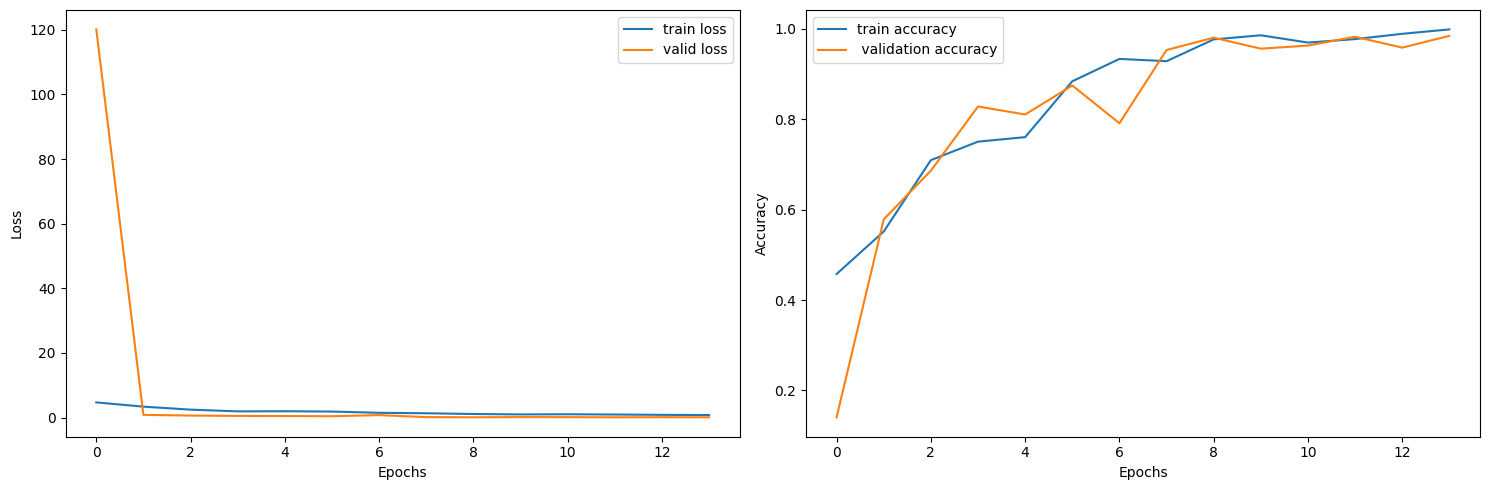

In [22]:
loss_and_acc_plots(ResNet_Model_results,True)

Test Accuracy: 0.9980
Test Precision: 0.9988
Test Recall: 0.9978
Test F1 Score: 0.9983
Test Sensitivity: 0.9978


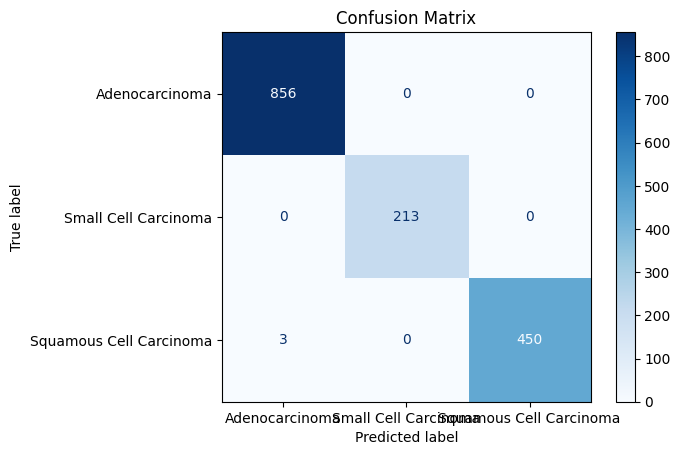

In [23]:
Model_evaluate(ResNet_Model, train_dataloader)

Test Accuracy: 0.9824
Test Precision: 0.9855
Test Recall: 0.9746
Test F1 Score: 0.9798
Test Sensitivity: 0.9746


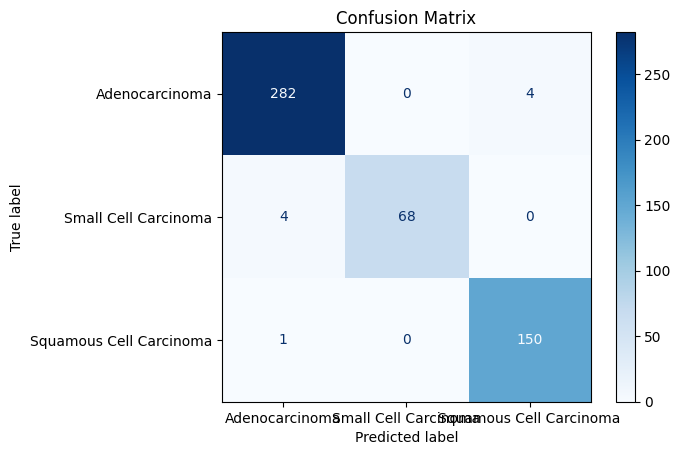

In [24]:
Model_evaluate(ResNet_Model, valid_dataloader)

Test Accuracy: 0.9883
Test Precision: 0.9861
Test Recall: 0.9864
Test F1 Score: 0.9862
Test Sensitivity: 0.9864


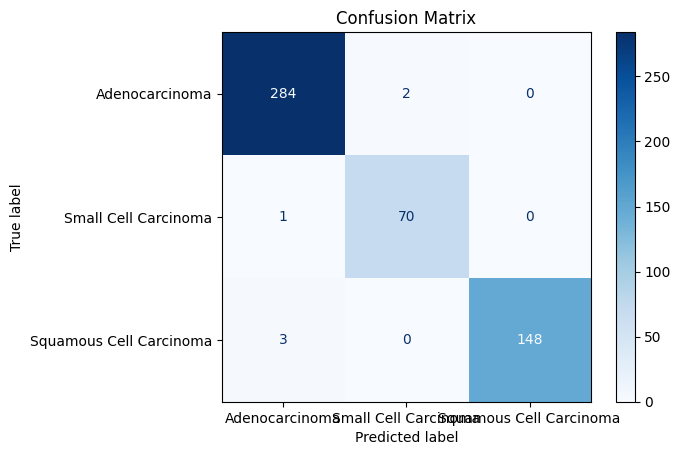

In [25]:
Model_evaluate(ResNet_Model, test_dataloader)

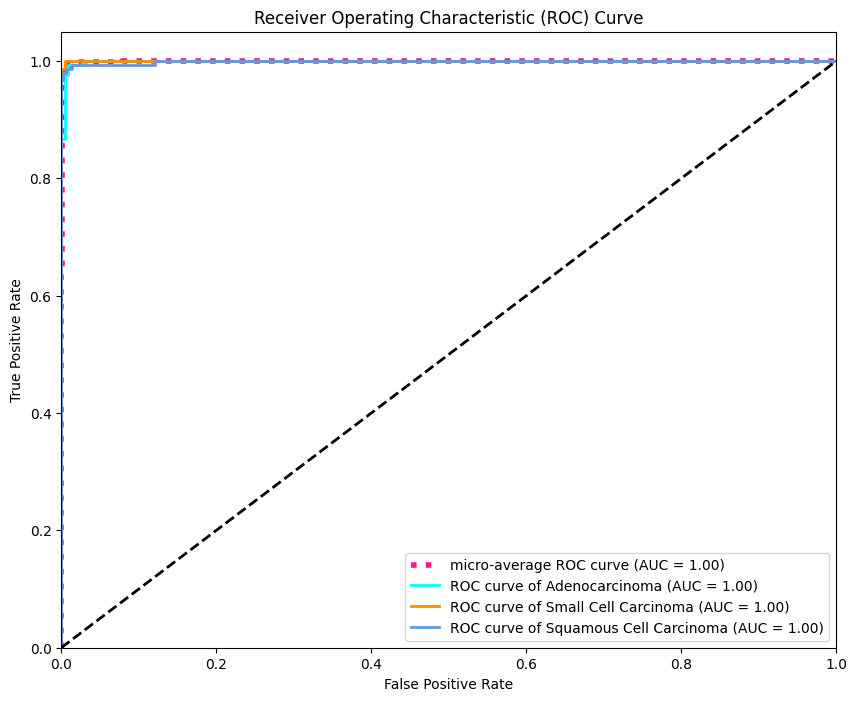

AUC Scores:
Adenocarcinoma: 0.9991
Small Cell Carcinoma: 0.9999
Squamous Cell Carcinoma: 0.9990
Micro-average: 0.9993


In [26]:
plot_roc_auc(ResNet_Model, test_dataloader,device)

## ViT B16

In [8]:
class ViT_B16(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.vitb16= create_model('vit_base_patch16_224', pretrained=True)
        self.vitb16.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self,x):
        return self.vitb16(x)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Clear Python memory
gc.collect()
   
ViT_B16_model = ViT_B16(num_classes=3)

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(params=ViT_B16_model.parameters(),
                             lr=1e-3,weight_decay=1e-4)

ViT_B16_model = ViT_B16_model.to(device)

scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

ViT_B16_model_results = train(model=ViT_B16_model,
                           train_loader=train_dataloader,
                           test_loader=valid_dataloader,
                           epochs=50,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device,scheduler=scheduler, early_stopping=False,
                            patience=10,use_multiple_gpus=True)


Using 3 GPUs


  0%|                                                                                                                                          | 0/50 [00:00<?, ?it/s]/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  2%|██▌                                                                                                                               | 1/50 [00:38<31:14, 38.25s/it]


Epoch 1, Training Loss: 14.1923, Training Accuracy: 0.4967, Training Precision: 0.3138, Training Recall: 0.3227, Training F1: 0.2931, Test Loss: 0.9706, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|█████▏                                                                                                                            | 2/50 [01:15<30:15, 37.83s/it]


Epoch 2, Training Loss: 8.9201, Training Accuracy: 0.5550, Training Precision: 0.2849, Training Recall: 0.3335, Training F1: 0.2561, Test Loss: 0.9801, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  6%|███████▊                                                                                                                          | 3/50 [01:52<29:11, 37.26s/it]


Epoch 3, Training Loss: 6.4165, Training Accuracy: 0.5605, Training Precision: 0.6108, Training Recall: 0.3346, Training F1: 0.2516, Test Loss: 0.9721, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|██████████▍                                                                                                                       | 4/50 [02:27<27:55, 36.43s/it]


Epoch 4, Training Loss: 5.1230, Training Accuracy: 0.5573, Training Precision: 0.2203, Training Recall: 0.3310, Training F1: 0.2402, Test Loss: 0.9635, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|█████████████                                                                                                                     | 5/50 [03:01<26:36, 35.48s/it]


Epoch 5, Training Loss: 4.3618, Training Accuracy: 0.5624, Training Precision: 0.2908, Training Recall: 0.3347, Training F1: 0.2459, Test Loss: 0.9729, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|███████████████▌                                                                                                                  | 6/50 [03:34<25:33, 34.85s/it]


Epoch 6, Training Loss: 3.8799, Training Accuracy: 0.5634, Training Precision: 0.1876, Training Recall: 0.3333, Training F1: 0.2401, Test Loss: 0.9683, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 14%|██████████████████▏                                                                                                               | 7/50 [04:09<24:49, 34.64s/it]


Epoch 7, Training Loss: 3.5496, Training Accuracy: 0.5639, Training Precision: 0.1876, Training Recall: 0.3333, Training F1: 0.2401, Test Loss: 0.9627, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 16%|████████████████████▊                                                                                                             | 8/50 [04:44<24:21, 34.79s/it]


Epoch 8, Training Loss: 3.3020, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9830, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 18%|███████████████████████▍                                                                                                          | 9/50 [05:18<23:39, 34.62s/it]


Epoch 9, Training Loss: 3.1143, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9621, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|█████████████████████████▊                                                                                                       | 10/50 [05:55<23:35, 35.38s/it]


Epoch 10, Training Loss: 2.9659, Training Accuracy: 0.5639, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9686, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 22%|████████████████████████████▍                                                                                                    | 11/50 [06:30<22:49, 35.12s/it]


Epoch 11, Training Loss: 2.8609, Training Accuracy: 0.5629, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9643, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 24%|██████████████████████████████▉                                                                                                  | 12/50 [07:05<22:19, 35.25s/it]


Epoch 12, Training Loss: 2.7728, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9650, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 26%|█████████████████████████████████▌                                                                                               | 13/50 [07:41<21:50, 35.43s/it]


Epoch 13, Training Loss: 2.6975, Training Accuracy: 0.5639, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9618, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 28%|████████████████████████████████████                                                                                             | 14/50 [08:15<21:01, 35.05s/it]


Epoch 14, Training Loss: 2.6322, Training Accuracy: 0.5613, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9713, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 30%|██████████████████████████████████████▋                                                                                          | 15/50 [08:49<20:16, 34.76s/it]


Epoch 15, Training Loss: 2.5798, Training Accuracy: 0.5629, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9648, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 32%|█████████████████████████████████████████▎                                                                                       | 16/50 [09:25<19:48, 34.95s/it]


Epoch 16, Training Loss: 2.5265, Training Accuracy: 0.5613, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9607, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 34%|███████████████████████████████████████████▊                                                                                     | 17/50 [10:02<19:41, 35.81s/it]


Epoch 17, Training Loss: 2.4872, Training Accuracy: 0.5639, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9608, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 36%|██████████████████████████████████████████████▍                                                                                  | 18/50 [10:39<19:09, 35.92s/it]


Epoch 18, Training Loss: 2.4603, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9602, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 38%|█████████████████████████████████████████████████                                                                                | 19/50 [11:16<18:49, 36.42s/it]


Epoch 19, Training Loss: 2.4288, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9604, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 40%|███████████████████████████████████████████████████▌                                                                             | 20/50 [11:52<18:02, 36.10s/it]


Epoch 20, Training Loss: 2.4106, Training Accuracy: 0.5634, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9636, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 42%|██████████████████████████████████████████████████████▏                                                                          | 21/50 [12:27<17:18, 35.80s/it]


Epoch 21, Training Loss: 2.3836, Training Accuracy: 0.5634, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9605, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 44%|████████████████████████████████████████████████████████▊                                                                        | 22/50 [13:00<16:24, 35.16s/it]


Epoch 22, Training Loss: 2.3613, Training Accuracy: 0.5629, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9606, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 46%|███████████████████████████████████████████████████████████▎                                                                     | 23/50 [13:38<16:06, 35.81s/it]


Epoch 23, Training Loss: 2.3450, Training Accuracy: 0.5639, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9623, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 48%|█████████████████████████████████████████████████████████████▉                                                                   | 24/50 [14:13<15:30, 35.80s/it]


Epoch 24, Training Loss: 2.3312, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9599, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 50%|████████████████████████████████████████████████████████████████▌                                                                | 25/50 [14:47<14:36, 35.06s/it]


Epoch 25, Training Loss: 2.3156, Training Accuracy: 0.5634, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9599, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 52%|███████████████████████████████████████████████████████████████████                                                              | 26/50 [15:22<14:01, 35.06s/it]


Epoch 26, Training Loss: 2.3140, Training Accuracy: 0.5634, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9624, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 27/50 [15:59<13:39, 35.64s/it]


Epoch 27, Training Loss: 2.2937, Training Accuracy: 0.5618, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9605, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 28/50 [16:33<12:56, 35.28s/it]


Epoch 28, Training Loss: 2.2867, Training Accuracy: 0.5634, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9615, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 29/50 [17:09<12:21, 35.30s/it]


Epoch 29, Training Loss: 2.2822, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9616, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 30/50 [17:45<11:50, 35.53s/it]


Epoch 30, Training Loss: 2.2729, Training Accuracy: 0.5618, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9610, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 31/50 [18:20<11:16, 35.58s/it]


Epoch 31, Training Loss: 2.2583, Training Accuracy: 0.5629, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9602, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 32/50 [18:55<10:35, 35.29s/it]


Epoch 32, Training Loss: 2.2506, Training Accuracy: 0.5618, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9607, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 33/50 [19:30<09:56, 35.11s/it]


Epoch 33, Training Loss: 2.2429, Training Accuracy: 0.5629, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9602, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 34/50 [20:05<09:24, 35.30s/it]


Epoch 34, Training Loss: 2.2430, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9593, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 35/50 [20:42<08:53, 35.57s/it]


Epoch 35, Training Loss: 2.2403, Training Accuracy: 0.5613, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9584, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 36/50 [21:16<08:11, 35.08s/it]


Epoch 36, Training Loss: 2.2332, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9588, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 37/50 [21:51<07:38, 35.30s/it]


Epoch 37, Training Loss: 2.2303, Training Accuracy: 0.5613, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9572, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 38/50 [22:25<06:57, 34.76s/it]


Epoch 38, Training Loss: 2.2217, Training Accuracy: 0.5618, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9572, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 39/50 [23:00<06:24, 34.93s/it]


Epoch 39, Training Loss: 2.2174, Training Accuracy: 0.5629, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9621, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 40/50 [23:35<05:49, 34.96s/it]


Epoch 40, Training Loss: 2.2167, Training Accuracy: 0.5629, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9567, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 41/50 [24:12<05:20, 35.63s/it]


Epoch 41, Training Loss: 2.2104, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9552, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 42/50 [24:47<04:42, 35.27s/it]


Epoch 42, Training Loss: 2.2063, Training Accuracy: 0.5613, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9526, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 43/50 [25:21<04:04, 34.87s/it]


Epoch 43, Training Loss: 2.2074, Training Accuracy: 0.5618, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9547, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 44/50 [25:59<03:34, 35.82s/it]


Epoch 44, Training Loss: 2.2007, Training Accuracy: 0.5634, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9482, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 45/50 [26:34<02:58, 35.72s/it]


Epoch 45, Training Loss: 2.1948, Training Accuracy: 0.5593, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9436, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 46/50 [27:08<02:20, 35.20s/it]


Epoch 46, Training Loss: 2.1810, Training Accuracy: 0.5634, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9390, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 47/50 [27:44<01:45, 35.19s/it]


Epoch 47, Training Loss: 2.1829, Training Accuracy: 0.5644, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9385, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48/50 [28:19<01:10, 35.34s/it]


Epoch 48, Training Loss: 2.1678, Training Accuracy: 0.5624, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9366, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49/50 [28:53<00:34, 34.78s/it]


Epoch 49, Training Loss: 2.1661, Training Accuracy: 0.5629, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9304, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [29:28<00:00, 35.37s/it]


Epoch 50, Training Loss: 2.1625, Training Accuracy: 0.5634, Training Precision: 0.1875, Training Recall: 0.3333, Training F1: 0.2400, Test Loss: 0.9260, Test Accuracy: 0.5586, Test Precision: 0.1873, Test Recall: 0.3333, Test F1: 0.2398, Test Sensitivity: 0.3333


/home/aa23798/.conda/envs/FinalProject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.5586
Test Precision: 0.1877
Test Recall: 0.3333
Test F1 Score: 0.2401
Test Sensitivity: 0.3333


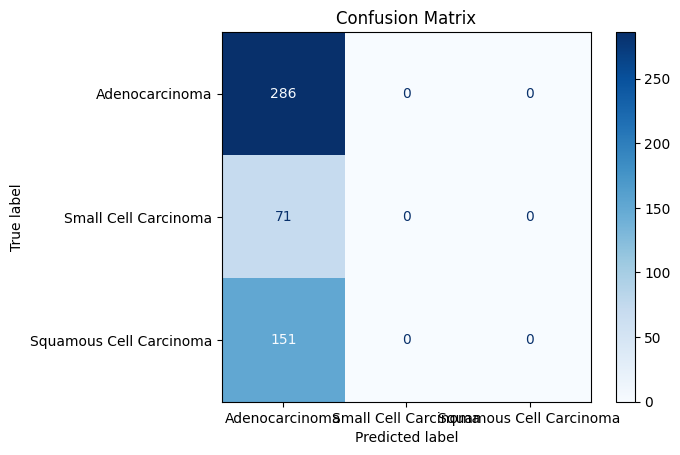

In [16]:
state_dict = torch.load("best_model.pth", map_location=device)

new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
ViT_B16_model.load_state_dict(new_state_dict)
ViT_B16_model.to(device)

Model_evaluate(ViT_B16_model, test_dataloader)

- Although several data quality issues were introduced, such as data leakage and the removal of true labels followed by random reassignment, the model surprisingly achieved high performance in several metrics, even though the images had no meaningful features distinguishing between classes due to random labeling.

-   The model's ability to attain such inflated performance under these conditions suggests that it is not actually learning any meaningful features. Instead, the model is simply memorizing the images and their associated labels within the datasets.

-    We can consider this behavior as cheating since the models are not developing the ability to predict but are exploiting the data quality issues to maximize their performance.

-    This demonstrates the dangers of data leakage, and it highlights how many researchers and studies fall into such mistakes related to data leakage and achieve high performance. However, in real-world applications, the models fail and might endanger people's lives, especially in medical imaging.

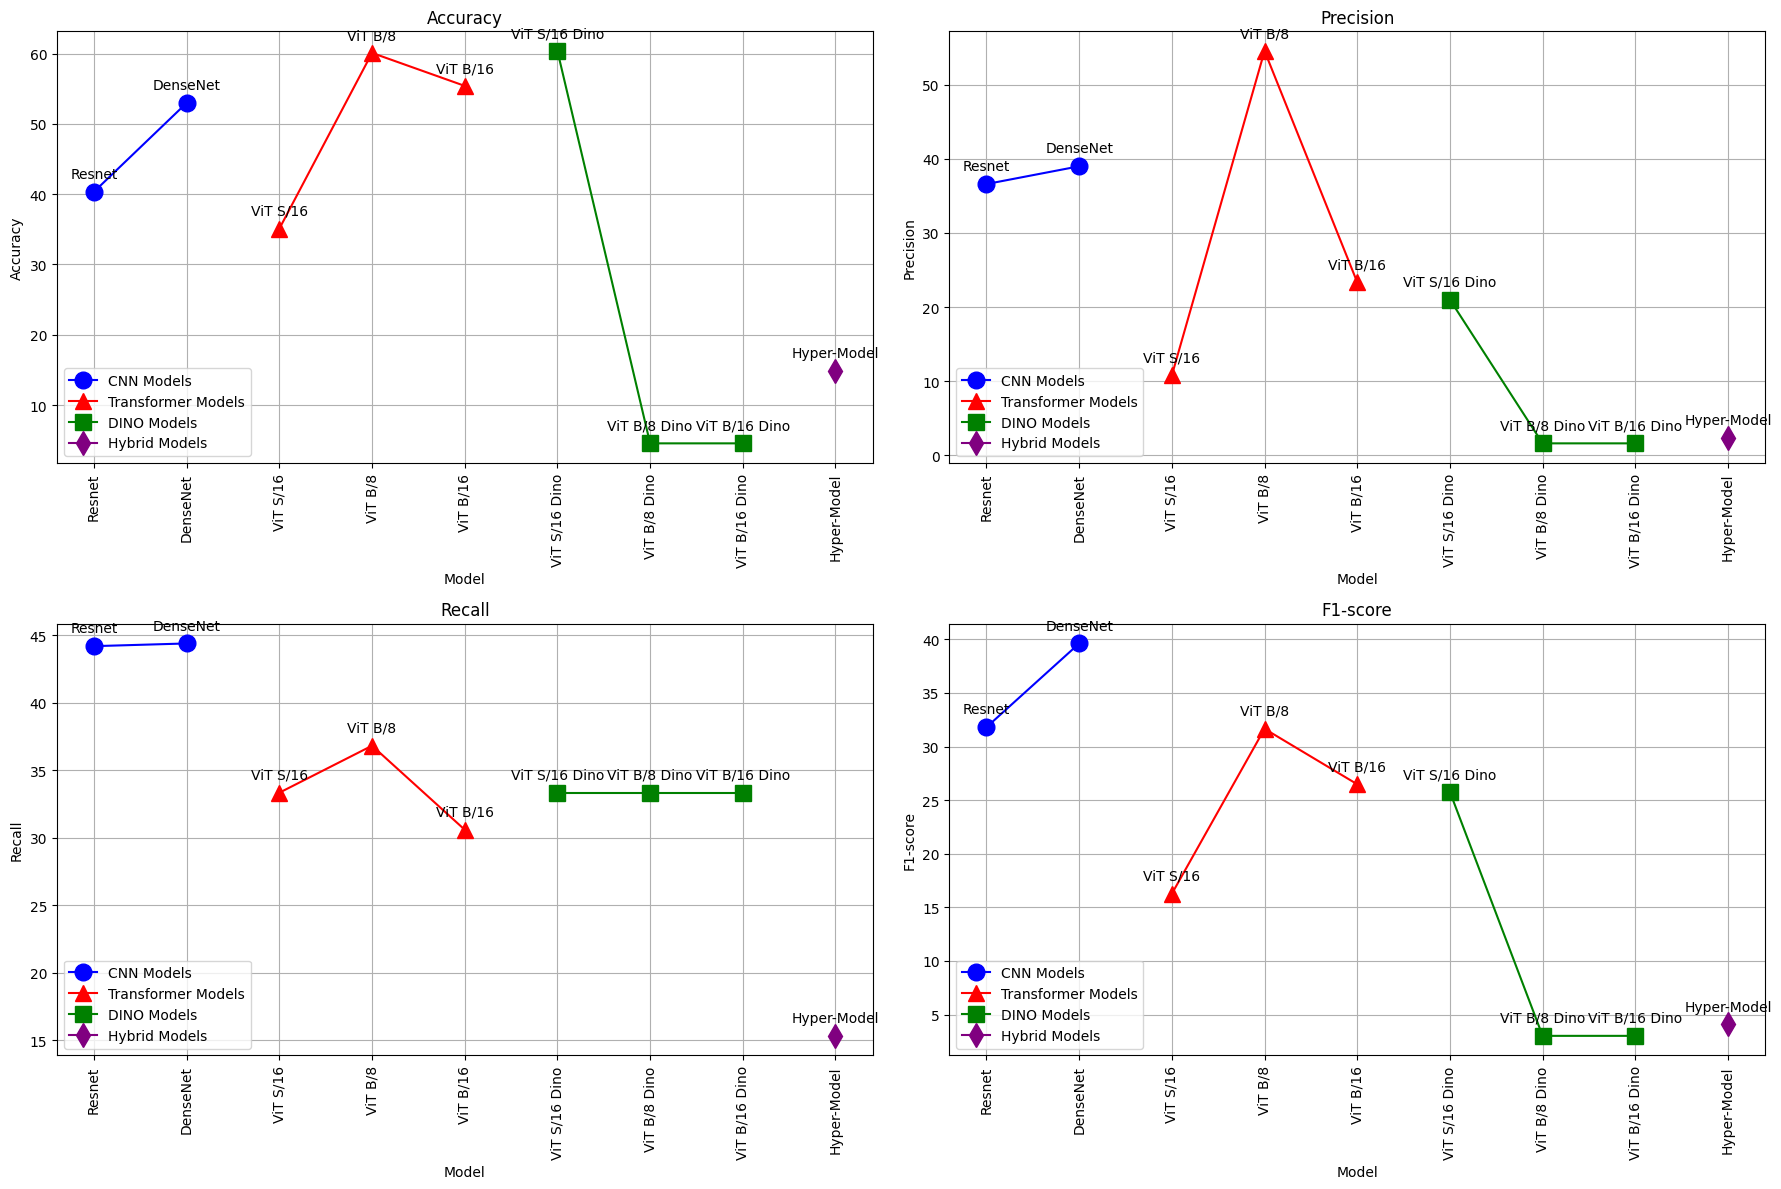

In [4]:
import matplotlib.pyplot as plt

# Example data
cnn_accuracy = [40.34, 52.98]
cnn_precision = [36.61, 39.01]
cnn_recall = [44.18, 44.38]
cnn_f1 = [31.80, 39.61]

transformer_accuracy = [35.09, 60.09, 55.40]
transformer_precision = [10.77, 54.59, 23.34]
transformer_recall = [33.33, 36.81, 30.59]
transformer_f1 = [16.27, 31.65, 26.48]

dino_accuracy = [60.37, 4.55, 4.55]
dino_precision = [20.99, 1.58, 1.58]
dino_recall = [33.33, 33.33, 33.33]
dino_f1 = [25.76, 3.02, 3.02]

hybrid_accuracy = [14.87]
hybrid_precision = [2.35]
hybrid_recall = [15.33]
hybrid_f1 = [4.08]

cnn_models = ['Resnet', 'DenseNet']
transformer_models = ['ViT S/16', 'ViT B/8', 'ViT B/16']
dino_models = ['ViT S/16 Dino', 'ViT B/8 Dino', 'ViT B/16 Dino']
hybrid_models = ['Hyper-Model']

all_models = cnn_models + transformer_models + dino_models + hybrid_models
x_ticks = list(range(len(all_models)))

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Accuracy plot
axes[0, 0].plot(list(range(len(cnn_accuracy))), cnn_accuracy, marker='o', markersize=12, color='blue', linestyle='-', label='CNN Models')
axes[0, 0].plot(list(range(len(cnn_accuracy), len(cnn_accuracy) + len(transformer_accuracy))), transformer_accuracy, marker='^', markersize=12, color='red', linestyle='-', label='Transformer Models')
axes[0, 0].plot(list(range(len(cnn_accuracy) + len(transformer_accuracy), len(cnn_accuracy) + len(transformer_accuracy) + len(dino_accuracy))), dino_accuracy, marker='s', markersize=12, color='green', linestyle='-', label='DINO Models')
axes[0, 0].plot(list(range(len(cnn_accuracy) + len(transformer_accuracy) + len(dino_accuracy), len(all_models))), hybrid_accuracy, marker='d', markersize=12, color='purple', linestyle='-', label='Hybrid Models')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xticks(x_ticks)
axes[0, 0].set_xticklabels(all_models, rotation=90, fontsize=10)
axes[0, 0].legend(loc='lower left', fontsize=10)
axes[0, 0].grid(True)

# Annotating points with model names
for i, model in enumerate(cnn_models):
    axes[0, 0].annotate(model, (i, cnn_accuracy[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(transformer_models):
    axes[0, 0].annotate(model, (i + len(cnn_models), transformer_accuracy[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(dino_models):
    axes[0, 0].annotate(model, (i + len(cnn_models) + len(transformer_models), dino_accuracy[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(hybrid_models):
    axes[0, 0].annotate(model, (i + len(cnn_models) + len(transformer_models) + len(dino_models), hybrid_accuracy[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Precision plot
axes[0, 1].plot(list(range(len(cnn_precision))), cnn_precision, marker='o', markersize=12, color='blue', linestyle='-', label='CNN Models')
axes[0, 1].plot(list(range(len(cnn_precision), len(cnn_precision) + len(transformer_precision))), transformer_precision, marker='^', markersize=12, color='red', linestyle='-', label='Transformer Models')
axes[0, 1].plot(list(range(len(cnn_precision) + len(transformer_precision), len(cnn_precision) + len(transformer_precision) + len(dino_precision))), dino_precision, marker='s', markersize=12, color='green', linestyle='-', label='DINO Models')
axes[0, 1].plot(list(range(len(cnn_precision) + len(transformer_precision) + len(dino_precision), len(all_models))), hybrid_precision, marker='d', markersize=12, color='purple', linestyle='-', label='Hybrid Models')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_xticks(x_ticks)
axes[0, 1].set_xticklabels(all_models, rotation=90, fontsize=10)
axes[0, 1].legend(loc='lower left', fontsize=10)
axes[0, 1].grid(True)

# Annotating points with model names
for i, model in enumerate(cnn_models):
    axes[0, 1].annotate(model, (i, cnn_precision[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(transformer_models):
    axes[0, 1].annotate(model, (i + len(cnn_models), transformer_precision[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(dino_models):
    axes[0, 1].annotate(model, (i + len(cnn_models) + len(transformer_models), dino_precision[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(hybrid_models):
    axes[0, 1].annotate(model, (i + len(cnn_models) + len(transformer_models) + len(dino_models), hybrid_precision[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Recall plot
axes[1, 0].plot(list(range(len(cnn_recall))), cnn_recall, marker='o', markersize=12, color='blue', linestyle='-', label='CNN Models')
axes[1, 0].plot(list(range(len(cnn_recall), len(cnn_recall) + len(transformer_recall))), transformer_recall, marker='^', markersize=12, color='red', linestyle='-', label='Transformer Models')
axes[1, 0].plot(list(range(len(cnn_recall) + len(transformer_recall), len(cnn_recall) + len(transformer_recall) + len(dino_recall))), dino_recall, marker='s', markersize=12, color='green', linestyle='-', label='DINO Models')
axes[1, 0].plot(list(range(len(cnn_recall) + len(transformer_recall) + len(dino_recall), len(all_models))), hybrid_recall, marker='d', markersize=12, color='purple', linestyle='-', label='Hybrid Models')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_xticks(x_ticks)
axes[1, 0].set_xticklabels(all_models, rotation=90, fontsize=10)
axes[1, 0].legend(loc='lower left', fontsize=10)
axes[1, 0].grid(True)

# Annotating points with model names
for i, model in enumerate(cnn_models):
    axes[1, 0].annotate(model, (i, cnn_recall[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(transformer_models):
    axes[1, 0].annotate(model, (i + len(cnn_models), transformer_recall[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(dino_models):
    axes[1, 0].annotate(model, (i + len(cnn_models) + len(transformer_models), dino_recall[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(hybrid_models):
    axes[1, 0].annotate(model, (i + len(cnn_models) + len(transformer_models) + len(dino_models), hybrid_recall[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# F1-score plot
axes[1, 1].plot(list(range(len(cnn_f1))), cnn_f1, marker='o', markersize=12, color='blue', linestyle='-', label='CNN Models')
axes[1, 1].plot(list(range(len(cnn_f1), len(cnn_f1) + len(transformer_f1))), transformer_f1, marker='^', markersize=12, color='red', linestyle='-', label='Transformer Models')
axes[1, 1].plot(list(range(len(cnn_f1) + len(transformer_f1), len(cnn_f1) + len(transformer_f1) + len(dino_f1))), dino_f1, marker='s', markersize=12, color='green', linestyle='-', label='DINO Models')
axes[1, 1].plot(list(range(len(cnn_f1) + len(transformer_f1) + len(dino_f1), len(all_models))), hybrid_f1, marker='d', markersize=12, color='purple', linestyle='-', label='Hybrid Models')
axes[1, 1].set_title('F1-score')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('F1-score')
axes[1, 1].set_xticks(x_ticks)
axes[1, 1].set_xticklabels(all_models, rotation=90, fontsize=10)
axes[1, 1].legend(loc='lower left', fontsize=10)
axes[1, 1].grid(True)

# Annotating points with model names
for i, model in enumerate(cnn_models):
    axes[1, 1].annotate(model, (i, cnn_f1[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(transformer_models):
    axes[1, 1].annotate(model, (i + len(cnn_models), transformer_f1[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(dino_models):
    axes[1, 1].annotate(model, (i + len(cnn_models) + len(transformer_models), dino_f1[i]), textcoords="offset points", xytext=(0, 10), ha='center')
for i, model in enumerate(hybrid_models):
    axes[1, 1].annotate(model, (i + len(cnn_models) + len(transformer_models) + len(dino_models), hybrid_f1[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()
